


[Time split] train_len=175, val_len=25, test_len=51
[Pairs] train=15210 | val=4225 | test=SKIP
[Gap range] min=1 max=169 | val_cross=True | test_pairs=False
✅ Saved run meta: data/resnetdz1111_best1_meta.npz
✅ Saved config snapshot: data/resnetdz1111_best1_config.json
✅ Saved run meta: data/resnetdz1111_final1_meta.npz
✅ Saved config snapshot: data/resnetdz1111_final1_config.json
✅ Warm-start LV prior with empirical (r, A).
Epoch 0001 | loss=179.284790 | val_loss=97.306635 | distortion=176.092070 | val_distortion=94.113916
Epoch 1: val_loss improved from inf to 97.30664, saving model to data\resnetdz1111_best1.h5
Epoch 0002 | loss=107.166548 | val_loss=62.366643 | distortion=103.973828 | val_distortion=59.173924
Epoch 2: val_loss improved from 97.30664 to 62.36664, saving model to data\resnetdz1111_best1.h5
Epoch 0003 | loss=76.436614 | val_loss=50.885297 | distortion=73.243894 | val_distortion=47.692577
Epoch 3: val_loss improved from 62.36664 to 50.88530, saving model to data\resn

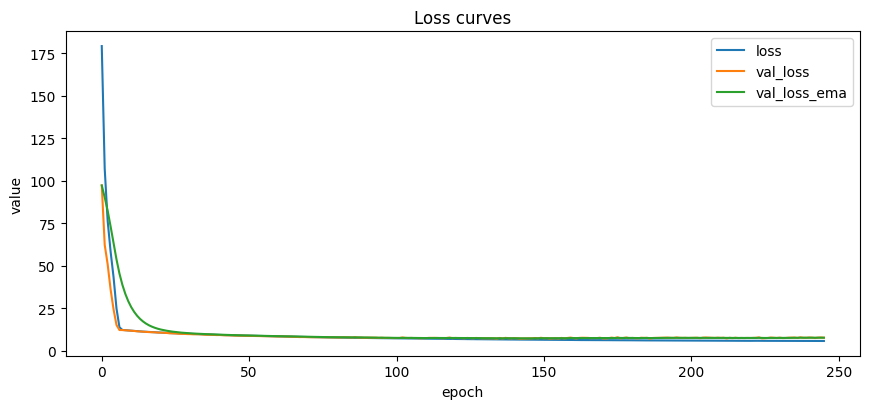

🖼 saved: out_pdf_like/plots\curve_loss.png


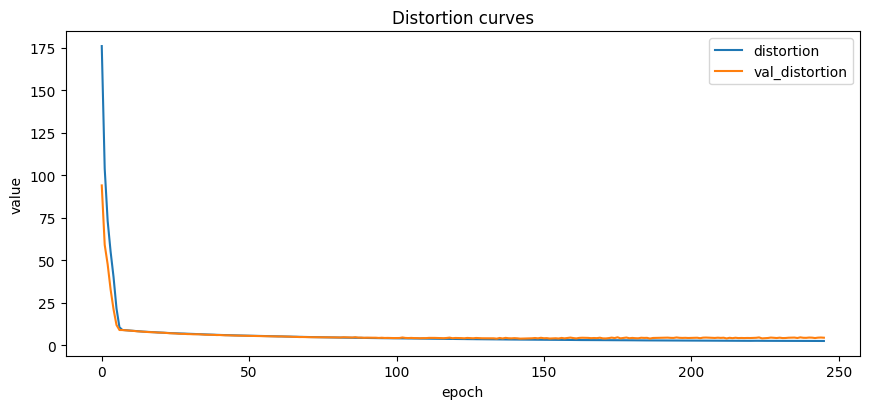

🖼 saved: out_pdf_like/plots\curve_distortion.png
📄 history saved: out_pdf_like/plots\training_history.csv
✅ Reloaded best weights from ckpt: data/resnetdz1111_best1.h5
✅ Test pairs skipped: only rollout evaluation will be produced.
✅ 保存权重到：data/resnetdz1111_final1.h5
⭐ 训练期间保存的最佳 ckpt 路径：data/resnetdz1111_best1.h5
⭐ best meta: data/resnetdz1111_best1_meta.npz
⭐ final meta: data/resnetdz1111_final1_meta.npz
📌 Rollout RMSE: {'x1': 0.6056056406114695, 'x2': 0.3836559940027869}
📌 Rollout MAE : {'x1': 0.4838251044698668, 'x2': 0.28524834863443127}


In [2]:
# ============================================
# AW-AOB-NOB
# ============================================

# ========= 在导入 TensorFlow 之前：固定种子/确定性 =========
import os, random, json
import numpy as np

GLOBAL_SEED = int(os.environ.get("GLOBAL_SEED", "42"))
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # 极致复现可强制 CPU

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
# =========================================================

import sys, csv
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

try:
    tf.config.experimental.enable_op_determinism()
except TypeError:
    try:
        tf.config.experimental.enable_op_determinism(True)
    except Exception:
        pass

tf.random.set_seed(GLOBAL_SEED)

import tensorflow_probability as tfp
from tensorflow.keras import layers, regularizers
import keras
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

tf.keras.backend.set_floatx('float64')
NUMBER_TYPE = tf.float64
tfd = tfp.distributions
np.set_printoptions(suppress=True, precision=6)


# ==================== 全局数值控制 ====================

class Numerics:
    STD_FLOOR = tf.cast(1e-13, NUMBER_TYPE)

    @staticmethod
    def set_std_floor(v):
        Numerics.STD_FLOOR = tf.cast(v, NUMBER_TYPE)

    @staticmethod
    def get_std_floor():
        return Numerics.STD_FLOOR


def softplus_floor(x):
    return tf.nn.softplus(x) + Numerics.get_std_floor()


# ==================== (新增) meta 保存/加载工具 ====================

def _default_meta_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_meta.npz"

def _default_cfg_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_config.json"

def save_run_meta_npz(meta_path: str,
                      idx_tr, idx_va, idx_te,
                      mu_x, sd_x, mu_z, sd_z,
                      cfg: dict,
                      N: int):
    os.makedirs(os.path.dirname(meta_path) or ".", exist_ok=True)

    def _pack(arr):
        return np.array([]) if arr is None else np.asarray(arr)

    # 只保存对“加载复现/画图”关键的字段（避免 meta 太大/太脆弱）
    meta = dict(
        N=int(N),
        idx_tr=np.asarray(idx_tr, dtype=np.int64),
        idx_va=np.asarray(idx_va, dtype=np.int64),
        idx_te=np.asarray(idx_te, dtype=np.int64),
        mu_x=_pack(mu_x),
        sd_x=_pack(sd_x),
        mu_z=_pack(mu_z),
        sd_z=_pack(sd_z),

        # 关键开关/结构（用于 sanity check）
        standardize_x=bool(cfg.get("standardize_x", True)),
        standardize_z=bool(cfg.get("standardize_z", True)),
        cond_mode=str(cfg.get("cond_mode", "mean")),
        diff_type=str(cfg.get("diff_type", "diagonal")),

        # 维度信息（后续构建模型用）
        n_x=int(len(cfg["state_cols"])),
        n_z=int(len(cfg["param_cols"])),
        n_param=int(2 * len(cfg["param_cols"])),  # C=[z_agg, dz]
        state_cols=np.array(cfg["state_cols"], dtype=object),
        param_cols=np.array(cfg["param_cols"], dtype=object),
        step_col=str(cfg.get("step_col", "step")),
        split_ratios=np.array(cfg.get("split_ratios", (0.8, 0.1, 0.1)), dtype=np.float64),
        gaps=np.array(cfg.get("gaps", []), dtype=np.int64),
        rollout_gap=int(cfg.get("rollout_gap", 1)),
        seed=int(cfg.get("seed", GLOBAL_SEED)),
        data_xlsx=str(cfg.get("data_xlsx", "")),
        use_synthetic=bool(cfg.get("use_synthetic", False)),
    )
    np.savez(meta_path, **meta)
    print(f"✅ Saved run meta: {meta_path}")

def save_cfg_snapshot_json(cfg_path: str, cfg: dict):
    os.makedirs(os.path.dirname(cfg_path) or ".", exist_ok=True)
    # json 可序列化的浅拷贝
    def _jsonable(x):
        if isinstance(x, (np.integer, np.floating)):
            return x.item()
        if isinstance(x, (np.ndarray,)):
            return x.tolist()
        return x
    cfg_dump = {k: _jsonable(v) for k, v in cfg.items()}
    with open(cfg_path, "w", encoding="utf-8") as f:
        json.dump(cfg_dump, f, ensure_ascii=False, indent=2)
    print(f"✅ Saved config snapshot: {cfg_path}")

def load_run_meta_npz(meta_path: str) -> dict:
    meta = np.load(meta_path, allow_pickle=True)
    out = {k: meta[k] for k in meta.files}

    # 还原 None
    def _maybe_none(arr):
        arr = np.asarray(arr)
        return None if arr.size == 0 else arr
    out["mu_x"] = _maybe_none(out.get("mu_x", np.array([])))
    out["sd_x"] = _maybe_none(out.get("sd_x", np.array([])))
    out["mu_z"] = _maybe_none(out.get("mu_z", np.array([])))
    out["sd_z"] = _maybe_none(out.get("sd_z", np.array([])))
    return out


# ==================== 数据合成（可选） ====================

def generate_fluctuating_params(n_steps, mutation_step=10000, rng=None):
    if rng is None:
        rng = np.random.default_rng(GLOBAL_SEED)
    Z1_stable = 15 + 0.1 * rng.standard_normal(n_steps)
    Z2_stable = 1 + 0.1 * rng.standard_normal(n_steps)
    Z3_before = 5 + 0.1 * rng.standard_normal(mutation_step)
    Z3_after = 0.1 + 0.1 * rng.standard_normal(n_steps - mutation_step)
    Z3_mut = np.concatenate([Z3_before, Z3_after])
    return np.vstack([Z1_stable, Z2_stable, Z3_mut]).T


def generate_sde_time_series(total_steps=20000, step_size=0.01,
                             mutation_step=10000,
                             out_path="data/sde_time_series_mutationz3.xlsx",
                             seed=42):
    os.makedirs("data", exist_ok=True)
    rng = np.random.default_rng(seed)
    a_aob, NTm_aob, p_aob = 139, 55, 0.39
    a_het, NTm_het, p_het = 520, 199, 0.06
    params = generate_fluctuating_params(total_steps, mutation_step, rng)

    x1 = [rng.uniform(0.1, 0.9)]
    x2 = [rng.uniform(0.1, 0.9)]
    for i in range(total_steps - 1):
        Z1, Z2, Z3 = params[i]
        alpha_aob = 0.027 * Z1 - 0.026 * Z2
        drift_aob = ((NTm_aob * p_aob) / a_aob
                     - (NTm_aob / a_aob) * x1[-1]
                     + (2 * alpha_aob / a_aob) * x1[-1] * (1 - x1[-1]))
        diffusion_aob = np.sqrt(2 * x1[-1] * (1 - x1[-1]) / a_aob)
        dW = rng.normal(0, np.sqrt(step_size))
        x1_new = x1[-1] + drift_aob * step_size + diffusion_aob * dW

        alpha_het = -0.08 * Z3
        drift_het = ((NTm_het * p_het) / a_het
                     - (NTm_het / a_het) * x2[-1]
                     + (2 * alpha_het / a_het) * x2[-1] * (1 - x2[-1]))
        diffusion_het = np.sqrt(2 * x2[-1] * (1 - x2[-1]) / a_het)
        dW = rng.normal(0, np.sqrt(step_size))
        x2_new = x2[-1] + drift_het * step_size + diffusion_het * dW

        x1.append(np.clip(x1_new, 0, 1))
        x2.append(np.clip(x2_new, 0, 1))

    df = pd.DataFrame({
        "step": np.arange(total_steps) * step_size,
        "x1": x1,
        "x2": x2,
        "Z1": params[:, 0],
        "Z2": params[:, 1],
        "Z3": params[:, 2],
    })

    B = df["x1"] + df["x2"] + 1e-12
    df["x1_frac"] = df["x1"] / B
    df["x2_frac"] = df["x2"] / B
    df["Z2_log"] = np.log1p(df["Z2"])

    df.to_excel(out_path, index=False)
    print(f"✅ Synthetic series saved: {out_path}")
    return df


# ==================== LV 先验层 ====================

class LVDrift(tf.keras.layers.Layer):
    def __init__(self, n_x, trainable=True, dtype=tf.float64, name="lv_prior"):
        super().__init__(name=name, dtype=dtype)
        self.n_x = n_x
        self.r = self.add_weight("r", shape=(n_x,),
                                 initializer="zeros",
                                 trainable=trainable, dtype=dtype)
        self.A = self.add_weight("A", shape=(n_x, n_x),
                                 initializer="zeros",
                                 trainable=trainable, dtype=dtype)

    def call(self, x):
        v = self.r + tf.linalg.matvec(self.A, x, transpose_a=True)
        return x * v


# ==================== Normal 近似分布构造 ====================

class ModelBuilder:
    @staticmethod
    def define_normal_distribution(yn_, step_size_, drift_, diffusivity_, diffusivity_type):
        safe_step = tf.maximum(step_size_, tf.cast(1e-12, step_size_.dtype))
        floor = Numerics.get_std_floor()

        if diffusivity_type == "diagonal":
            std = tf.maximum(diffusivity_, floor)
            return tfd.MultivariateNormalDiag(
                loc=(yn_ + step_size_ * drift_),
                scale_diag=tf.math.sqrt(safe_step) * std,
                name="approx_normal"
            )

        elif diffusivity_type == "triangular":
            tril_step_size = tf.math.sqrt(safe_step)
            n_dim = K.shape(yn_)[-1]
            full_shape = n_dim * n_dim
            step_size_matrix = tf.broadcast_to(
                tril_step_size, [K.shape(step_size_)[0], full_shape]
            )
            step_size_matrix = tf.reshape(step_size_matrix, (-1, n_dim, n_dim))

            L = diffusivity_
            d = tf.linalg.diag_part(L)
            L = L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + floor)

            return tfd.MultivariateNormalTriL(
                loc=(yn_ + step_size_ * drift_),
                scale_tril=tf.multiply(step_size_matrix, L),
                name="approx_normal"
            )

        elif diffusivity_type == "spd":
            spd_step = tf.math.sqrt(safe_step)
            n_dim = K.shape(yn_)[-1]
            full_shape = n_dim * n_dim
            step_size_matrix = tf.broadcast_to(
                spd_step, [K.shape(step_size_)[0], full_shape]
            )
            step_size_matrix = tf.reshape(step_size_matrix, (-1, n_dim, n_dim))

            L = diffusivity_
            d = tf.linalg.diag_part(L)
            L = L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + floor)
            cov = tf.linalg.matmul(L, L, transpose_b=True)

            eye = tf.eye(tf.shape(cov)[-1], dtype=cov.dtype)[None, :, :]
            cov = cov + (floor ** 2) * eye
            cov = tf.multiply(step_size_matrix, cov)
            chol = tf.linalg.cholesky(cov)

            return tfd.MultivariateNormalTriL(
                loc=(yn_ + step_size_ * drift_),
                scale_tril=chol,
                name="approx_normal"
            )

        elif diffusivity_type == "auto":
            n_dim = int(yn_.shape[-1] or K.int_shape(yn_)[-1])
            k = n_dim * (n_dim + 1) // 2

            d_raw = diffusivity_[:, 0:n_dim]
            tri_flat = diffusivity_[:, n_dim:n_dim + k]
            spd_flat = diffusivity_[:, n_dim + k:n_dim + 2 * k]
            gate_logits = diffusivity_[:, n_dim + 2 * k:n_dim + 2 * k + 3]
            w = tf.nn.softmax(gate_logits, axis=-1)

            sig = softplus_floor(d_raw)
            D = tf.linalg.diag(sig)
            cov_diag = tf.linalg.matmul(D, D, transpose_b=True)

            L1 = tfp.math.fill_triangular(tri_flat)
            d1 = tf.linalg.diag_part(L1)
            L1 = L1 - tf.linalg.diag(d1) + tf.linalg.diag(tf.abs(d1) + floor)
            cov_tri = tf.linalg.matmul(L1, L1, transpose_b=True)

            L2 = tfp.math.fill_triangular(spd_flat)
            d2 = tf.linalg.diag_part(L2)
            L2 = L2 - tf.linalg.diag(d2) + tf.linalg.diag(tf.abs(d2) + floor)
            cov_spd = tf.linalg.matmul(L2, L2, transpose_b=True)

            cov = (w[:, 0][:, None, None] * cov_diag +
                   w[:, 1][:, None, None] * cov_tri +
                   w[:, 2][:, None, None] * cov_spd)
            eye = tf.eye(n_dim, dtype=yn_.dtype)[None, :, :]
            cov = cov + (floor ** 2) * eye
            cov = cov * tf.reshape(safe_step, (-1, 1, 1))
            scale_tril = tf.linalg.cholesky(cov)

            return tfd.MultivariateNormalTriL(
                loc=(yn_ + step_size_ * drift_),
                scale_tril=scale_tril,
                name="approx_normal"
            )

        else:
            raise ValueError(f"Unsupported diffusivity_type {diffusivity_type}")


# ==================== ResNet SDE 子模型（均值=LV+残差） ====================

def define_sde_with_lv(n_input_dimensions,
                       n_output_dimensions,
                       n_layers,
                       n_dim_per_layer,
                       name,
                       diffusivity_type="diagonal",
                       activation="tanh",
                       dtype=tf.float64,
                       n_parameter_dimensions=0,
                       lv_trainable=True,
                       dropout_rate=0.05,
                       l2_weight=1e-4,
                       seed=GLOBAL_SEED):
    reg = regularizers.l2(l2_weight) if l2_weight and l2_weight > 0 else None
    act_fn = tf.keras.activations.get(activation)

    inputs = layers.Input((n_input_dimensions + n_parameter_dimensions,),
                          dtype=dtype, name=name + "_inputs")

    x_only = layers.Lambda(lambda u: u[:, :n_input_dimensions],
                           name=f"{name}_x_only")(inputs)
    lv_term = LVDrift(n_x=n_input_dimensions,
                      trainable=lv_trainable,
                      dtype=dtype,
                      name=f"{name}_lv_prior")(x_only)

    dense_init = tf.keras.initializers.GlorotUniform(seed=seed)

    h = layers.Dense(n_dim_per_layer,
                     activation=act_fn,
                     kernel_initializer=dense_init,
                     bias_initializer="zeros",
                     kernel_regularizer=reg,
                     dtype=dtype,
                     name=f"{name}_mean_res_in")(inputs)

    for i in range(n_layers):
        h_res = layers.Dense(n_dim_per_layer,
                             activation=act_fn,
                             kernel_initializer=dense_init,
                             bias_initializer="zeros",
                             kernel_regularizer=reg,
                             dtype=dtype,
                             name=f"{name}_mean_res_block{i}_dense1")(h)
        if dropout_rate and dropout_rate > 0:
            h_res = layers.Dropout(dropout_rate, seed=seed,
                                   name=f"{name}_mean_res_block{i}_dropout")(h_res)
        h_res = layers.Dense(n_dim_per_layer,
                             activation=None,
                             kernel_initializer=dense_init,
                             bias_initializer="zeros",
                             kernel_regularizer=reg,
                             dtype=dtype,
                             name=f"{name}_mean_res_block{i}_dense2")(h_res)
        h = layers.Add(name=f"{name}_mean_res_block{i}_add")([h, h_res])
        h = layers.Activation(act_fn, name=f"{name}_mean_res_block{i}_act")(h)

    mean_residual = layers.Dense(n_output_dimensions,
                                 activation=None,
                                 kernel_initializer=dense_init,
                                 bias_initializer="zeros",
                                 kernel_regularizer=reg,
                                 dtype=dtype,
                                 name=f"{name}_mean_res_out")(h)
    out_mean = layers.Add(name=f"{name}_output_mean")([lv_term, mean_residual])

    small_init = 1e-2
    ru_init = tf.keras.initializers.RandomUniform(minval=-small_init,
                                                  maxval=small_init,
                                                  seed=seed)

    h2 = layers.Dense(n_dim_per_layer,
                      activation=act_fn,
                      kernel_initializer=ru_init,
                      bias_initializer=ru_init,
                      kernel_regularizer=reg,
                      dtype=dtype,
                      name=f"{name}_std_in")(inputs)

    for i in range(n_layers):
        h2_res = layers.Dense(n_dim_per_layer,
                              activation=act_fn,
                              kernel_initializer=ru_init,
                              bias_initializer=ru_init,
                              kernel_regularizer=reg,
                              dtype=dtype,
                              name=f"{name}_std_block{i}_dense1")(h2)
        if dropout_rate and dropout_rate > 0:
            h2_res = layers.Dropout(dropout_rate, seed=seed,
                                    name=f"{name}_std_block{i}_dropout")(h2_res)
        h2_res = layers.Dense(n_dim_per_layer,
                              activation=None,
                              kernel_initializer=ru_init,
                              bias_initializer=ru_init,
                              kernel_regularizer=reg,
                              dtype=dtype,
                              name=f"{name}_std_block{i}_dense2")(h2_res)
        h2 = layers.Add(name=f"{name}_std_block{i}_add")([h2, h2_res])
        h2 = layers.Activation(act_fn, name=f"{name}_std_block{i}_act")(h2)

    if diffusivity_type == "diagonal":
        out_std = layers.Dense(
            n_output_dimensions,
            activation=lambda x: softplus_floor(x),
            kernel_initializer=ru_init,
            bias_initializer=ru_init,
            kernel_regularizer=reg,
            dtype=dtype,
            name=f"{name}_output_std"
        )(h2)

    elif diffusivity_type == "triangular":
        out_tril = layers.Dense(
            n_output_dimensions * (n_output_dimensions + 1) // 2,
            activation="linear",
            kernel_initializer=ru_init,
            bias_initializer=ru_init,
            kernel_regularizer=reg,
            dtype=dtype,
            name=f"{name}_output_cholesky"
        )(h2)

        def make_tri_matrix(z):
            L = tfp.math.fill_triangular(z)
            d = tf.linalg.diag_part(L)
            return L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + Numerics.get_std_floor())

        out_std = layers.Lambda(make_tri_matrix, name=f"{name}_std_tril")(out_tril)

    elif diffusivity_type == "spd":
        out_tril = layers.Dense(
            n_output_dimensions * (n_output_dimensions + 1) // 2,
            activation="linear",
            kernel_initializer=ru_init,
            bias_initializer=ru_init,
            kernel_regularizer=reg,
            dtype=dtype,
            name=f"{name}_output_spd"
        )(h2)

        def make_spd(z):
            L = tfp.math.fill_triangular(z)
            d = tf.linalg.diag_part(L)
            L = L - tf.linalg.diag(d) + tf.linalg.diag(tf.abs(d) + Numerics.get_std_floor())
            return tf.linalg.matmul(L, L, transpose_b=True)

        out_std = layers.Lambda(make_spd, name=f"{name}_std_spd")(out_tril)

    elif diffusivity_type == "auto":
        diag_std = layers.Dense(n_output_dimensions, activation="linear",
                                kernel_initializer=ru_init, bias_initializer=ru_init,
                                kernel_regularizer=reg, dtype=dtype,
                                name=f"{name}_auto_diag_raw")(h2)
        tri_flat = layers.Dense(n_output_dimensions * (n_output_dimensions + 1) // 2,
                                activation="linear", kernel_initializer=ru_init,
                                bias_initializer=ru_init, kernel_regularizer=reg,
                                dtype=dtype, name=f"{name}_auto_tri_flat")(h2)
        spd_flat = layers.Dense(n_output_dimensions * (n_output_dimensions + 1) // 2,
                                activation="linear", kernel_initializer=ru_init,
                                bias_initializer=ru_init, kernel_regularizer=reg,
                                dtype=dtype, name=f"{name}_auto_spd_flat")(h2)
        gate_logits = layers.Dense(3, activation="linear",
                                   kernel_initializer=ru_init, bias_initializer="zeros",
                                   kernel_regularizer=reg, dtype=dtype,
                                   name=f"{name}_auto_gate_logits")(h2)
        out_std = layers.Concatenate(name=f"{name}_auto_concat")(
            [diag_std, tri_flat, spd_flat, gate_logits]
        )
    else:
        raise ValueError(f"Unsupported diffusivity_type {diffusivity_type}")

    return tf.keras.Model(inputs, [out_mean, out_std], name=name + "_gaussian_process")


# ==================== PDF 一步似然网络 ====================

class SDEApproximationNetwork(tf.keras.Model):
    def __init__(self, sde_model: tf.keras.Model,
                 step_size=None, n_parameters=0,
                 method="euler", diffusivity_type="diagonal",
                 gate_entropy_lambda=0.0, **kwargs):
        super().__init__(**kwargs)
        assert method == "euler"
        self.sde_model = sde_model
        self.step_size = step_size
        self.n_parameters = n_parameters
        self.method = method
        self.diffusivity_type = diffusivity_type
        self.gate_entropy_lambda = float(gate_entropy_lambda)

    @staticmethod
    def split_inputs(inputs, step_size=None, n_parameters=0):
        if step_size is None:
            total_cols = inputs.shape[1]
            n_size = (total_cols - 1 - n_parameters) // 2
            step = inputs[:, :1]
            rem = inputs[:, 1:]
            if n_parameters > 0:
                x_n, p_n, x_np1 = tf.split(
                    rem, num_or_size_splits=[n_size, n_parameters, n_size], axis=1
                )
            else:
                x_n, x_np1 = tf.split(rem, num_or_size_splits=2, axis=1)
                p_n = None
            return step, x_n, p_n, x_np1
        else:
            if n_parameters > 0:
                n_size = inputs.shape[1] // 2
                x_n, p_n, x_np1 = tf.split(
                    inputs,
                    num_or_size_splits=[n_size - n_parameters,
                                        n_parameters,
                                        n_size - n_parameters],
                    axis=1
                )
            else:
                x_n, x_np1 = tf.split(inputs, num_or_size_splits=2, axis=1)
                p_n = None
            return step_size, x_n, p_n, x_np1

    def call_xn(self, inputs_xn, param_xn=None):
        if param_xn is not None:
            return self.sde_model(tf.concat([inputs_xn, param_xn], axis=1))
        return self.sde_model(inputs_xn)

    def call(self, inputs):
        step_size, x_n, p_n, x_np1 = SDEApproximationNetwork.split_inputs(
            inputs, self.step_size, self.n_parameters
        )
        if p_n is not None:
            drift_, diff_ = self.sde_model(tf.concat([x_n, p_n], axis=1))
        else:
            drift_, diff_ = self.sde_model(x_n)

        approx_normal = ModelBuilder.define_normal_distribution(
            x_n, step_size, drift_, diff_, self.diffusivity_type
        )
        log_prob = approx_normal.log_prob(x_np1)
        sample_distortion = -tf.reduce_mean(log_prob, axis=-1)
        distortion = tf.reduce_mean(sample_distortion)
        loss = distortion + 2 * np.log(2 * np.pi) / np.log(10) * tf.cast(tf.shape(x_n)[1], NUMBER_TYPE)

        if self.diffusivity_type == "auto":
            n_dim = int(x_n.shape[-1])
            k = n_dim * (n_dim + 1) // 2
            gate_logits = diff_[:, n_dim + 2 * k:n_dim + 2 * k + 3]
            w = tf.nn.softmax(gate_logits, axis=-1)
            self.add_metric(tf.reduce_mean(w[:, 0]), name="gate_diag", aggregation="mean")
            self.add_metric(tf.reduce_mean(w[:, 1]), name="gate_tri", aggregation="mean")
            self.add_metric(tf.reduce_mean(w[:, 2]), name="gate_spd", aggregation="mean")
            if self.gate_entropy_lambda > 0.0:
                entropy = -tf.reduce_mean(tf.reduce_sum(w * tf.math.log(w + 1e-8), axis=-1))
                loss = loss + self.gate_entropy_lambda * entropy

        self.add_loss(loss)
        self.add_metric(distortion, name="distortion", aggregation="mean")

        if p_n is not None:
            x_n = tf.concat([x_n, p_n], axis=1)
        return self.sde_model(x_n)


# ==================== 训练包装 & rollout ====================

class EMASmoothingCallback(keras.callbacks.Callback):
    def __init__(self, monitor="val_loss", alpha=0.2):
        super().__init__()
        self.monitor = monitor
        self.alpha = float(alpha)
        self.ema = None

    def on_epoch_end(self, epoch, logs=None):
        if logs is None or self.monitor not in logs:
            return
        val = float(logs[self.monitor])
        self.ema = val if self.ema is None else self.alpha * val + (1 - self.alpha) * self.ema
        logs[self.monitor + "_ema"] = self.ema


class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def __init__(self, monitor_keys=("loss", "val_loss",
                                     "distortion", "val_distortion",
                                     "gate_diag", "gate_tri", "gate_spd")):
        super().__init__()
        self.keys = monitor_keys

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        msg = [f"Epoch {epoch + 1:04d}"]
        for k in self.keys:
            if k in logs:
                try:
                    v = float(logs[k])
                    msg.append(f"{k}={v:.6f}")
                except Exception:
                    msg.append(f"{k}={logs[k]}")
        sys.stdout.write("\r" + " | ".join(msg))
        sys.stdout.flush()


class SDEIdentification:
    def __init__(self, model: SDEApproximationNetwork,
                 lr=1e-4, weight_decay=1e-4, clipnorm=1.0):
        self.model = model
        opt = tf.keras.optimizers.AdamW(
            learning_rate=lr,
            weight_decay=weight_decay,
            global_clipnorm=clipnorm
        )
        self.model.compile(optimizer=opt)

    def train_model_matrix(self, train_full, val_full,
                           epochs=1000, batch_size=512,
                           es_cfg=None, rlrop_cfg=None, ckpt_cfg=None):
        callbacks = [LossAndErrorPrintingCallback()]

        if es_cfg and es_cfg.get("use_ema", False):
            callbacks.append(EMASmoothingCallback(
                monitor=es_cfg.get("monitor", "val_loss"),
                alpha=es_cfg.get("ema_alpha", 0.2)
            ))

        if es_cfg:
            monitor_name = es_cfg.get("monitor", "val_loss")
            if es_cfg.get("use_ema", False):
                monitor_name = monitor_name + "_ema"
            es_kwargs = dict(
                monitor=monitor_name,
                min_delta=es_cfg.get("min_delta", 0.0),
                patience=es_cfg.get("patience", 200),
                mode=es_cfg.get("mode", "min"),
                restore_best_weights=es_cfg.get("restore_best_weights", True),
                baseline=es_cfg.get("baseline", None)
            )
            try:
                es = EarlyStopping(start_from_epoch=es_cfg.get("start_from_epoch", 0), **es_kwargs)
            except TypeError:
                es = EarlyStopping(**es_kwargs)
            callbacks.append(es)

        if rlrop_cfg and rlrop_cfg.get("enabled", False):
            monitor_name = rlrop_cfg.get("monitor", "val_loss")
            if (rlrop_cfg.get("use_ema_as_monitor", False) and es_cfg and es_cfg.get("use_ema", False)):
                monitor_name = es_cfg.get("monitor", "val_loss") + "_ema"
            rlp = ReduceLROnPlateau(
                monitor=monitor_name,
                factor=rlrop_cfg.get("factor", 0.5),
                patience=rlrop_cfg.get("patience", 200),
                mode=rlrop_cfg.get("mode", "min"),
                cooldown=rlrop_cfg.get("cooldown", 0),
                min_delta=rlrop_cfg.get("min_delta", 1e-6),
                min_lr=rlrop_cfg.get("min_lr", 1e-6),
                verbose=1
            )
            callbacks.append(rlp)

        if ckpt_cfg and ckpt_cfg.get("enabled", False):
            os.makedirs(os.path.dirname(ckpt_cfg["filepath"]), exist_ok=True)
            mc = ModelCheckpoint(
                filepath=ckpt_cfg["filepath"],
                monitor=ckpt_cfg.get("monitor", "val_loss"),
                mode=ckpt_cfg.get("mode", "min"),
                save_best_only=True,
                save_weights_only=True,
                verbose=1
            )
            callbacks.append(mc)

        hist = self.model.fit(
            x=train_full, y=None,
            epochs=epochs, batch_size=batch_size, verbose=0,
            validation_data=(val_full, None),
            callbacks=callbacks,
            shuffle=False
        )
        print("\n✅ Training done.")
        return hist

    def sample_path(self, x0, step_size, NT, N_iterates,
                    param0=None, diffusivity_type="diagonal",
                    map_every_iteration=None):
        step_size = tf.cast(np.ones((N_iterates, 1)) * np.array(step_size), dtype=NUMBER_TYPE)
        paths = [np.ones((N_iterates, 1)) @ np.array(x0).reshape(1, -1)]
        for _ in range(NT):
            x_n = paths[-1]
            if param0 is not None:
                mu, sig = self.model.call_xn(tf.concat([x_n, param0], axis=1))
            else:
                mu, sig = self.model.call_xn(x_n)
            approx_normal = ModelBuilder.define_normal_distribution(x_n, step_size, mu, sig, diffusivity_type)
            x_np1 = approx_normal.sample()
            x_i = keras.backend.eval(x_np1)
            if map_every_iteration is not None:
                x_i = map_every_iteration(x_i)
            paths.append(x_i)
        return [np.row_stack([paths[k][i] for k in range(len(paths))])
                for i in range(N_iterates)]


# ====================== 数据对构造/切分等 ======================

def aggregate_z_segment(Z, t, gap, mode='mean'):
    seg = Z[t:t + gap]
    if mode == 'mean':
        return seg.mean(axis=0)
    if mode == 'sum':
        return seg.sum(axis=0)
    if mode == 'last':
        return seg[-1]
    if mode == 'start':
        return seg[0]
    return seg.mean(axis=0)


def build_multi_h_pairs_on_block(X_blk, Z_blk, T_blk, gaps,
                                 max_per_gap=3000,
                                 cond_mode='mean', rng=None):
    if rng is None:
        rng = np.random.default_rng(GLOBAL_SEED)
    Xn_list, Xnp1_list, C_list, H_list = [], [], [], []
    M = len(X_blk)
    for gap in gaps:
        avail = M - gap
        if avail <= 0:
            continue
        idx = np.arange(avail)
        if len(idx) > max_per_gap:
            idx = rng.choice(idx, size=max_per_gap, replace=False)
        h_vals = (T_blk[idx + gap] - T_blk[idx]).reshape(-1, 1)

        C_rows = []
        for t in idx:
            z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
            dz = Z_blk[t + gap - 1] - Z_blk[t]
            C_rows.append(np.concatenate([z_agg, dz]))
        C_seg = np.vstack(C_rows)

        Xn_list.append(X_blk[idx])
        Xnp1_list.append(X_blk[idx + gap])
        C_list.append(C_seg)
        H_list.append(h_vals)

    if not Xn_list:
        raise RuntimeError("该块没有可用 (t, t+gap) 样本；检查 GAPS 或块长度。")

    return (np.vstack(Xn_list).astype(np.float64),
            np.vstack(Xnp1_list).astype(np.float64),
            np.vstack(C_list).astype(np.float64),
            np.vstack(H_list).astype(np.float64))


def build_multi_h_pairs_cross(X_all, Z_all, T_all,
                              start_idx, end_idx, gaps,
                              max_per_gap=3000,
                              cond_mode='mean', rng=None):
    if rng is None:
        rng = np.random.default_rng(GLOBAL_SEED)

    start_idx = np.asarray(start_idx)
    end_mask = np.zeros(len(X_all), dtype=bool)
    end_mask[np.asarray(end_idx)] = True

    Xn_list, Xnp1_list, C_list, H_list = [], [], [], []

    for gap in gaps:
        ok = (start_idx + gap < len(X_all))
        t_candidates = start_idx[ok]
        t_candidates = t_candidates[end_mask[t_candidates + gap]]
        if len(t_candidates) == 0:
            continue
        if len(t_candidates) > max_per_gap:
            t_candidates = rng.choice(t_candidates, size=max_per_gap, replace=False)

        h_vals = (T_all[t_candidates + gap] - T_all[t_candidates]).reshape(-1, 1)

        C_rows = []
        for t in t_candidates:
            z_agg = aggregate_z_segment(Z_all, t, gap, cond_mode)
            dz = Z_all[t + gap - 1] - Z_all[t]
            C_rows.append(np.concatenate([z_agg, dz]))
        C_seg = np.vstack(C_rows)

        Xn_list.append(X_all[t_candidates])
        Xnp1_list.append(X_all[t_candidates + gap])
        C_list.append(C_seg)
        H_list.append(h_vals)

    if not Xn_list:
        raise RuntimeError("跨段没有可用 (t, t+gap) 样本；检查 gaps、split 或 max_per_gap。")

    return (np.vstack(Xn_list).astype(np.float64),
            np.vstack(Xnp1_list).astype(np.float64),
            np.vstack(C_list).astype(np.float64),
            np.vstack(H_list).astype(np.float64))


def fit_stats(arr):
    mu = arr.mean(axis=0, keepdims=True)
    sd = arr.std(axis=0, keepdims=True) + 1e-12
    return mu, sd


def apply_stats(arr, mu, sd):
    return (arr - mu) / sd


def pack_inputs(H, Xn, C, Xnp1):
    left = np.column_stack([H, Xn, C])
    return np.column_stack([left, Xnp1])


def warm_start_lv_from_paired_data(train_full, sde_model,
                                   n_x, n_z,
                                   lv_layer_name="sde_lv_prior",
                                   ridge=1e-4):
    # 这里 n_z 实际上传的是 n_param（即 C 的维度），与你原脚本保持一致
    h = train_full[:, :1]
    xn = train_full[:, 1:1 + n_x]
    xp = train_full[:, 1 + n_x + n_z:1 + 2 * n_x + n_z]
    eps = 1e-12
    y = (xp - xn) / (h + eps)

    R = np.zeros((n_x,), dtype=np.float64)
    A = np.zeros((n_x, n_x), dtype=np.float64)

    for i in range(n_x):
        xi = xn[:, i:i + 1]
        Phi = np.concatenate([xi, xi * xn], axis=1)
        y_i = y[:, i:i + 1]
        I = np.eye(Phi.shape[1], dtype=np.float64)
        w = np.linalg.solve(Phi.T @ Phi + ridge * I, Phi.T @ y_i).ravel()
        R[i] = w[0]
        A[i, :] = w[1:]

    lv_layers = [l for l in sde_model.layers if l.name == lv_layer_name]
    if not lv_layers:
        raise RuntimeError(f"Didn't find LV layer named '{lv_layer_name}'.")
    lv_layer = lv_layers[0]
    lv_layer.r.assign(R)
    lv_layer.A.assign(A)
    print("✅ Warm-start LV prior with empirical (r, A).")


def simulate_path_block(solver: SDEIdentification,
                        X_blk, Z_blk, T_blk,
                        gap=1, cond_mode='mean',
                        diffusivity_type="diagonal",
                        mu_x=None, sd_x=None,
                        mu_z=None, sd_z=None):
    X0 = X_blk[0].copy()
    X0_s = ((X0[None, :] - mu_x) / sd_x)[0] if (mu_x is not None) else X0.copy()

    Nblk = len(T_blk)
    steps = (Nblk - 1) // gap
    x_pred_s = [X0_s.copy()]
    x_curr_s = X0_s.copy()

    for j in range(steps):
        t = j * gap
        if t + gap >= Nblk:
            break
        dt = T_blk[t + gap] - T_blk[t]

        z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
        dz = Z_blk[t + gap - 1] - Z_blk[t]
        zseg = np.concatenate([z_agg, dz]).reshape(1, -1)
        zseg_s = (zseg - mu_z) / sd_z if (mu_z is not None) else zseg

        path_j = solver.sample_path(
            x0=x_curr_s,
            step_size=dt,
            NT=1,
            N_iterates=1,
            param0=zseg_s,
            diffusivity_type=diffusivity_type
        )[0]
        x_next_s = path_j[1]
        x_pred_s.append(x_next_s)
        x_curr_s = x_next_s

    Xsim = np.array(x_pred_s)
    if mu_x is not None:
        Xsim = Xsim * sd_x + mu_x

    Tsim = np.r_[T_blk[0],
                 np.array([T_blk[(k + 1) * gap] for k in range(len(x_pred_s) - 1)])]
    return Xsim, Tsim


def plot_training_curves(history, out_dir, diff_type):
    os.makedirs(out_dir, exist_ok=True)
    H = history.history

    def _maybe_plot(keys, title, fname):
        keys = [k for k in keys if k in H]
        if not keys:
            return
        plt.figure(figsize=(8.8, 4.2))
        for k in keys:
            plt.plot(H[k], label=k)
        plt.xlabel("epoch")
        plt.ylabel("value")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        fpath = os.path.join(out_dir, fname)
        plt.savefig(fpath, dpi=180)
        plt.show()
        print(f"🖼 saved: {fpath}")

    _maybe_plot(["loss", "val_loss", "loss_ema", "val_loss_ema"], "Loss curves", "curve_loss.png")
    _maybe_plot(["distortion", "val_distortion"], "Distortion curves", "curve_distortion.png")
    if diff_type == "auto":
        _maybe_plot(["gate_diag", "gate_tri", "gate_spd"], "Auto-gate (train mean)", "curve_gate.png")

    csv_path = os.path.join(out_dir, "training_history.csv")
    all_keys = sorted(H.keys())
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch"] + all_keys)
        Tlen = len(next(iter(H.values())))
        for i in range(Tlen):
            writer.writerow([i + 1] + [H[k][i] if i < len(H[k]) else "" for k in all_keys])
    print(f"📄 history saved: {csv_path}")


# ==================== (新增) 数据读取函数，绘图/检验复用 ====================

def load_data_arrays(cfg):
    if cfg["use_synthetic"] or (not os.path.exists(cfg["data_xlsx"])):
        df = generate_sde_time_series(
            total_steps=cfg["synthetic_total_steps"],
            step_size=cfg["synthetic_dt"],
            mutation_step=cfg["synthetic_mutation_step"],
            out_path=cfg["synthetic_out_path"],
            seed=cfg["seed"]
        )
    else:
        df = pd.read_excel(cfg["data_xlsx"])

    step_col = cfg["step_col"]
    if step_col in df.columns:
        df = df.sort_values(step_col).reset_index(drop=True)
    else:
        df[step_col] = np.arange(len(df))

    if "Z2" in df.columns and ("Z2_log" in cfg["param_cols"]):
        df["Z2_log"] = np.log1p(df["Z2"])

    X = df[cfg["state_cols"]].to_numpy(np.float64)
    Z = df[cfg["param_cols"]].to_numpy(np.float64)
    T = (df[step_col].to_numpy(np.float64)
         if step_col in df.columns
         else np.arange(len(df), dtype=np.float64))
    return df, X, Z, T


# ==================== (新增) 后续绘图/检验：一行加载训练好的模型 ====================

def load_trained_model_for_plots(cfg,
                                weights_path=None,
                                prefer_best=True,
                                meta_path=None,
                                build_solver=True):
    """
    用于后续绘图/检验 cell 的“最简单入口”：
    model, solver, meta, (df,X,Z,T) = load_trained_model_for_plots(CONFIG)

    - 自动选择权重：prefer_best=True 时优先 best，否则 final
    - 自动读取 meta：默认和权重同名 *_meta.npz（也可传 meta_path）
    - 不重算 split/stats，确保和训练一致
    """
    # 选权重
    if weights_path is None:
        cand = []
        if prefer_best and cfg.get("ckpt_enabled", False):
            cand.append(cfg.get("save_best_weights_path", ""))
        cand.append(cfg.get("save_weights_path", ""))
        weights_path = None
        for p in cand:
            if p and os.path.exists(p):
                weights_path = p
                break
        if weights_path is None:
            raise FileNotFoundError(f"❌ 找不到权重文件，候选：{cand}")

    # 选 meta
    if meta_path is None:
        meta_path = cfg.get("meta_path", _default_meta_path_from_weight(weights_path))
    if not os.path.exists(meta_path):
        raise FileNotFoundError(f"❌ 找不到 meta 文件：{meta_path}（请先用 main(CONFIG) 训练/生成 meta）")

    meta = load_run_meta_npz(meta_path)

    # 读取数据（画图一般也需要）
    df, X, Z, T = load_data_arrays(cfg)

    # 构建网络（不需要 pairs，只需要维度）
    n_x = int(meta["n_x"])
    n_param = int(meta["n_param"])  # 2*n_z

    sde_model = define_sde_with_lv(
        n_input_dimensions=n_x,
        n_output_dimensions=n_x,
        n_layers=cfg["mean_num_layers"],
        n_dim_per_layer=cfg["mean_hidden_dim"],
        name="sde",
        activation=cfg["mean_activation"],
        diffusivity_type=cfg["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=n_param,
        lv_trainable=cfg["lv_trainable"],
        dropout_rate=cfg.get("dropout_rate", 0.05),
        l2_weight=cfg.get("l2_weight", 1e-4),
        seed=cfg["seed"]
    )

    model = SDEApproximationNetwork(
        sde_model,
        step_size=None,
        n_parameters=n_param,
        method="euler",
        diffusivity_type=cfg["diff_type"],
        gate_entropy_lambda=cfg.get("gate_entropy_lambda", 0.0)
    )

    # build
    dummy_cols = 1 + n_x + n_param + n_x
    _ = model(tf.zeros((1, dummy_cols), dtype=NUMBER_TYPE))

    # load weights
    model.load_weights(weights_path)
    print(f"✅ Loaded weights: {weights_path}")
    print(f"✅ Loaded meta   : {meta_path}")
    print(f"[Time split(meta)] train={len(meta['idx_tr'])}, val={len(meta['idx_va'])}, test={len(meta['idx_te'])}")

    solver = None
    if build_solver:
        solver = SDEIdentification(
            model,
            lr=cfg.get("lr", 1e-4),
            weight_decay=cfg.get("weight_decay", 1e-4),
            clipnorm=cfg.get("global_clipnorm", 1.0)
        )

    return model, solver, meta, (df, X, Z, T)


# ============================== 主流程 ==============================

def main(cfg):
    import gc
    tf.keras.backend.clear_session()
    gc.collect()
    plt.close('all')

    Numerics.set_std_floor(cfg.get("std_min_value", 1e-13))

    np.random.seed(cfg["seed"])
    tf.random.set_seed(cfg["seed"])

    # -------- 读数据 / 合成数据 --------
    df, X, Z, T = load_data_arrays(cfg)

    # ----- 按时间划分：train / val / test -----
    R_TR, R_VA, R_TE = cfg["split_ratios"]
    assert abs(R_TR + R_VA + R_TE - 1.0) < 1e-8
    N = len(T)
    MAXG = max(cfg["gaps"])
    split_tr = int(N * R_TR)
    split_va = int(N * (R_TR + R_VA))

    # train 段内训练一定要 > MAXG（否则 train 内无法做最大 gap 的配对）
    if split_tr <= MAXG:
        split_tr = MAXG + 1

    # val：只有在 val 要段内配对时才需要 > MAXG
    if (not cfg.get("val_cross_pairs", True)) and (split_va - split_tr <= MAXG):
        split_va = split_tr + (MAXG + 1)

    # ✅ test 不做配对时，不要用 MAXG 约束 test_len
    if cfg.get("use_test_pairs", True):
        if (not cfg.get("test_cross_pairs", True)) and (N - split_va <= MAXG):
            split_va = N - (MAXG + 1)

    idx_tr = np.arange(0, split_tr)
    idx_va = np.arange(split_tr, split_va)
    idx_te = np.arange(split_va, N)

    rng = np.random.default_rng(cfg["seed"])

    # ====== 构造 train / val 配对 ======
    Xn_tr, Xnp1_tr, C_tr, H_tr = build_multi_h_pairs_on_block(
        X[idx_tr], Z[idx_tr], T[idx_tr],
        cfg["gaps"], cfg["max_per_gap"], cfg["cond_mode"], rng=rng
    )

    # ====== 构造 val 配对：cross(train->val) + within(val->val) 二者兼有 ======
    val_mode = cfg.get("val_pairs_mode", "cross")  # "cross" | "within" | "both"

    Xn_va_list, Xnp1_va_list, C_va_list, H_va_list = [], [], [], []

    if val_mode in ("cross", "both"):
        Xn_va1, Xnp1_va1, C_va1, H_va1 = build_multi_h_pairs_cross(
            X_all=X, Z_all=Z, T_all=T,
            start_idx=idx_tr, end_idx=idx_va,
            gaps=cfg["gaps"], max_per_gap=cfg["max_per_gap"],
            cond_mode=cfg["cond_mode"], rng=rng
        )
        Xn_va_list.append(Xn_va1); Xnp1_va_list.append(Xnp1_va1)
        C_va_list.append(C_va1);   H_va_list.append(H_va1)

    if val_mode in ("within", "both"):
        Xn_va2, Xnp1_va2, C_va2, H_va2 = build_multi_h_pairs_on_block(
            X[idx_va], Z[idx_va], T[idx_va],
            cfg["gaps"], cfg["max_per_gap"], cfg["cond_mode"], rng=rng
    )
        Xn_va_list.append(Xn_va2); Xnp1_va_list.append(Xnp1_va2)
        C_va_list.append(C_va2);   H_va_list.append(H_va2)

    if not Xn_va_list:
        raise RuntimeError(f"val_pairs_mode={val_mode} produced no validation pairs.")

    Xn_va   = np.vstack(Xn_va_list).astype(np.float64)
    Xnp1_va = np.vstack(Xnp1_va_list).astype(np.float64)
    C_va    = np.vstack(C_va_list).astype(np.float64)
    H_va    = np.vstack(H_va_list).astype(np.float64)


    # ====== test 配对：按开关决定是否跳过 ======
    use_test_pairs = cfg.get("use_test_pairs", True)
    if use_test_pairs:
        if cfg.get("test_cross_pairs", True):
            idx_trva = np.arange(0, split_va)
            Xn_te, Xnp1_te, C_te, H_te = build_multi_h_pairs_cross(
                X_all=X, Z_all=Z, T_all=T,
                start_idx=idx_trva, end_idx=idx_te,
                gaps=cfg["gaps"], max_per_gap=cfg["max_per_gap"],
                cond_mode=cfg["cond_mode"], rng=rng
            )
        else:
            Xn_te, Xnp1_te, C_te, H_te = build_multi_h_pairs_on_block(
                X[idx_te], Z[idx_te], T[idx_te],
                cfg["gaps"], cfg["max_per_gap"], cfg["cond_mode"], rng=rng
            )
    else:
        Xn_te = Xnp1_te = C_te = H_te = None

    print(f"[Time split] train_len={len(idx_tr)}, val_len={len(idx_va)}, test_len={len(idx_te)}")
    print(f"[Pairs] train={len(Xn_tr)} | val={len(Xn_va)} | test={'SKIP' if Xn_te is None else len(Xn_te)}")
    print(f"[Gap range] min={min(cfg['gaps'])} max={max(cfg['gaps'])} | "
          f"val_cross={cfg.get('val_cross_pairs', True)} | test_pairs={use_test_pairs}")

    # ----- 标准化（仅用 Train 统计量） -----
    if cfg["standardize_x"]:
        mu_x, sd_x = fit_stats(np.vstack([Xn_tr, Xnp1_tr]))
        Xn_tr_s, Xnp1_tr_s = apply_stats(Xn_tr, mu_x, sd_x), apply_stats(Xnp1_tr, mu_x, sd_x)
        Xn_va_s, Xnp1_va_s = apply_stats(Xn_va, mu_x, sd_x), apply_stats(Xnp1_va, mu_x, sd_x)
        if use_test_pairs:
            Xn_te_s, Xnp1_te_s = apply_stats(Xn_te, mu_x, sd_x), apply_stats(Xnp1_te, mu_x, sd_x)
    else:
        mu_x = sd_x = None
        Xn_tr_s, Xnp1_tr_s = Xn_tr, Xnp1_tr
        Xn_va_s, Xnp1_va_s = Xn_va, Xnp1_va
        if use_test_pairs:
            Xn_te_s, Xnp1_te_s = Xn_te, Xnp1_te

    if cfg["standardize_z"]:
        mu_z, sd_z = fit_stats(C_tr)
        C_tr_s = apply_stats(C_tr, mu_z, sd_z)
        C_va_s = apply_stats(C_va, mu_z, sd_z)
        if use_test_pairs:
            C_te_s = apply_stats(C_te, mu_z, sd_z)
    else:
        mu_z = sd_z = None
        C_tr_s, C_va_s = C_tr, C_va
        if use_test_pairs:
            C_te_s = C_te

    H_tr_s, H_va_s = H_tr, H_va

    train_full = pack_inputs(H_tr_s, Xn_tr_s, C_tr_s, Xnp1_tr_s)
    val_full = pack_inputs(H_va_s, Xn_va_s, C_va_s, Xnp1_va_s)

    if use_test_pairs:
        H_te_s = H_te
        test_full = pack_inputs(H_te_s, Xn_te_s, C_te_s, Xnp1_te_s)
    else:
        test_full = None

    # ----- (新增) 在训练前就保存 meta（split+stats）到 best/final 对应文件名 -----
    # 这样后续画图永远读 meta，不会被你后续改 CONFIG 影响
    meta_best = _default_meta_path_from_weight(cfg["save_best_weights_path"]) if cfg.get("ckpt_enabled", False) else None
    meta_final = _default_meta_path_from_weight(cfg["save_weights_path"])

    if meta_best is not None:
        save_run_meta_npz(meta_best, idx_tr, idx_va, idx_te, mu_x, sd_x, mu_z, sd_z, cfg, N)
        save_cfg_snapshot_json(_default_cfg_path_from_weight(cfg["save_best_weights_path"]), cfg)
    save_run_meta_npz(meta_final, idx_tr, idx_va, idx_te, mu_x, sd_x, mu_z, sd_z, cfg, N)
    save_cfg_snapshot_json(_default_cfg_path_from_weight(cfg["save_weights_path"]), cfg)

    # ----- 构建模型 -----
    n_in = Xn_tr.shape[1]
    n_out = Xnp1_tr.shape[1]
    n_param = C_tr.shape[1]

    sde_model = define_sde_with_lv(
        n_input_dimensions=n_in,
        n_output_dimensions=n_out,
        n_layers=cfg["mean_num_layers"],
        n_dim_per_layer=cfg["mean_hidden_dim"],
        name="sde",
        activation=cfg["mean_activation"],
        diffusivity_type=cfg["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=n_param,
        lv_trainable=cfg["lv_trainable"],
        dropout_rate=cfg.get("dropout_rate", 0.05),
        l2_weight=cfg.get("l2_weight", 1e-4),
        seed=cfg["seed"]
    )

    model = SDEApproximationNetwork(
        sde_model,
        step_size=None,
        n_parameters=n_param,
        method="euler",
        diffusivity_type=cfg["diff_type"],
        gate_entropy_lambda=cfg.get("gate_entropy_lambda", 0.0)
    )

    _ = model(tf.zeros((1, train_full.shape[1]), dtype=NUMBER_TYPE))

    if cfg["lv_warm_start"]:
        warm_start_lv_from_paired_data(
            train_full=train_full,
            sde_model=sde_model,
            n_x=n_in,
            n_z=n_param,
            lv_layer_name="sde_lv_prior",
            ridge=cfg["lv_warm_start_ridge"]
        )

    solver = SDEIdentification(
        model,
        lr=cfg["lr"],
        weight_decay=cfg.get("weight_decay", 1.0e-4),
        clipnorm=cfg.get("global_clipnorm", 1.0)
    )

    history = solver.train_model_matrix(
        train_full, val_full,
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        es_cfg=dict(
            monitor=cfg["es_monitor"],
            mode=cfg["es_mode"],
            min_delta=cfg["es_min_delta"],
            patience=cfg["es_patience"],
            start_from_epoch=cfg["es_start_from_epoch"],
            restore_best_weights=cfg["es_restore_best_weights"],
            baseline=cfg.get("es_baseline", None),
            use_ema=cfg["es_use_ema"],
            ema_alpha=cfg["es_ema_alpha"],
        ),
        rlrop_cfg=dict(
            enabled=cfg["rlrop_enabled"],
            monitor=cfg["rlrop_monitor"],
            mode=cfg["rlrop_mode"],
            factor=cfg["rlrop_factor"],
            patience=cfg["rlrop_patience"],
            cooldown=cfg["rlrop_cooldown"],
            min_delta=cfg["rlrop_min_delta"],
            min_lr=cfg["rlrop_min_lr"],
            use_ema_as_monitor=cfg["rlrop_use_ema_as_monitor"],
        ),
        ckpt_cfg=dict(
            enabled=cfg["ckpt_enabled"],
            filepath=cfg["save_best_weights_path"],
            monitor=cfg["ckpt_monitor"],
            mode=cfg["ckpt_mode"]
        )
    )

    plot_training_curves(history, cfg["plots_dir"], cfg["diff_type"])

    if cfg["ckpt_enabled"]:
        try:
            model.load_weights(cfg["save_best_weights_path"])
            print(f"✅ Reloaded best weights from ckpt: {cfg['save_best_weights_path']}")
        except Exception as e:
            print("⚠️ Failed to load best ckpt, using final weights in memory instead:", e)

    # ✅ test 不做配对：不 evaluate
    if test_full is not None:
        test_logs = model.evaluate(test_full, y=None, verbose=0, return_dict=True)
        print(f"Test metrics (best weights): {test_logs}")
    else:
        print("✅ Test pairs skipped: only rollout evaluation will be produced.")

    os.makedirs("data", exist_ok=True)
    model.save_weights(cfg["save_weights_path"])
    print(f"✅ 保存权重到：{cfg['save_weights_path']}")
    if cfg["ckpt_enabled"]:
        print(f"⭐ 训练期间保存的最佳 ckpt 路径：{cfg['save_best_weights_path']}")
        # best 权重对应的 meta 已经写过；这里再提示一下
        print(f"⭐ best meta: {_default_meta_path_from_weight(cfg['save_best_weights_path'])}")
    print(f"⭐ final meta: {_default_meta_path_from_weight(cfg['save_weights_path'])}")

    # ----- test 段 rollout + 误差 -----
    Xtest_blk, Ztest_blk, Ttest_blk = X[idx_te], Z[idx_te], T[idx_te]
    pred1, t_pred1 = simulate_path_block(
        solver, Xtest_blk, Ztest_blk, Ttest_blk,
        gap=cfg["rollout_gap"],
        cond_mode=cfg["cond_mode"],
        diffusivity_type=cfg["diff_type"],
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z
    )

    # rollout RMSE/MAE（按共同长度截断）
    L = min(len(pred1), len(Xtest_blk))
    err = pred1[:L] - Xtest_blk[:L]
    rmse = np.sqrt(np.mean(err ** 2, axis=0))
    mae = np.mean(np.abs(err), axis=0)
    print("📌 Rollout RMSE:", dict(zip(cfg["state_cols"], rmse)))
    print("📌 Rollout MAE :", dict(zip(cfg["state_cols"], mae)))


    return model  # 可选：返回训练好的 model（not required）


# =========================== 配置 ===========================

CONFIG = {
    "seed": GLOBAL_SEED,

    # —— 数据来源 ——
    "data_xlsx": "data/AW - 251 - 4.xlsx",
    "use_synthetic": False,
    "synthetic_total_steps": 20000,
    "synthetic_dt": 0.01,
    "synthetic_mutation_step": 10000,
    "synthetic_out_path": "data/sde_time_series_mutationz3.xlsx",

    # —— 列名配置 ——
    "state_cols": ["x1", "x2"],
    "param_cols": ["z1", "z2", "z3", "z4", "z5", "z6", "z7", "z8", "z9", "z10",
                  "z11", "z12", "z13", "z14", "z15", "z16", "z17", "z18", "z19"],
    "step_col": "step",

    # —— 多间隔采样 ——
    "gaps": list(range(1, 170)),
    "max_per_gap": 2000,
    "cond_mode": "mean",

    # —— 切分比例 ——
    "split_ratios": (0.7, 0.1, 0.2),

    # ✅ val 仍可用跨段 pairs（推荐）
    "val_cross_pairs": True,

    # ✅ test 不做 pairs：只 rollout
    "use_test_pairs": False,
    "test_cross_pairs": True,   # use_test_pairs=False 时无所谓

    # —— 标准化 ——
    "standardize_x": True,
    "standardize_z": True,

    # —— 模型结构 ——
    "mean_num_layers": 4,
    "mean_hidden_dim": 256,
    "mean_activation": "elu",
    "diff_type": "diagonal",
    "lv_trainable": False,
    "dropout_rate": 0.1,
    "l2_weight": 0,

    # —— 先验暖启动 ——
    "lv_warm_start": True,
    "lv_warm_start_ridge": 1e-4,

    # —— 数值稳定 ——
    "std_min_value": 1e-14,

    # —— 训练超参 ——
    "epochs": 8000,
    "batch_size": 512,
    "lr": 2e-5,
    "weight_decay": 2e-4,
    "global_clipnorm": 1.0,

    # —— 精细早停 ——
    "es_monitor": "val_loss",
    "es_mode": "min",
    "es_min_delta": 1e-4,
    "es_patience": 100,
    "es_start_from_epoch": 50,
    "es_restore_best_weights": True,
    "es_baseline": None,
    "es_use_ema": True,
    "es_ema_alpha": 0.2,

    # —— 自适应降学习率 ——
    "rlrop_enabled": True,
    "rlrop_monitor": "val_loss",
    "rlrop_use_ema_as_monitor": True,
    "rlrop_mode": "min",
    "rlrop_factor": 0.5,
    "rlrop_patience": 50,
    "rlrop_cooldown": 0,
    "rlrop_min_delta": 1e-6,
    "rlrop_min_lr": 1e-5,

    # —— 最佳权重保存 ——
    "ckpt_enabled": True,
    "ckpt_monitor": "val_loss",
    "ckpt_mode": "min",
    "save_best_weights_path": "data/resnetdz1111_best1.h5",

    # —— auto-gate 熵正则 ——
    "gate_entropy_lambda": 1e-3,

    # —— 推理/绘图 ——
    "rollout_gap": 1,
    "plots_dir": "out_pdf_like/plots",
    
    "val_pairs_mode": "both",   # "cross" | "within" | "both"


    # —— 最终权重保存 ——
    "save_weights_path": "data/resnetdz1111_final1.h5",

    # （可选）如果你想强行指定 meta 文件名
    # "meta_path": "data/resnetdz111_best1_meta.npz",
}


if __name__ == "__main__":
    main(CONFIG)

# ============================================================
# ✅ 训练完之后，在任何后续“绘图/检验”cell 里，你只需要：
# model, solver, meta, (df, X, Z, T) = load_trained_model_for_plots(CONFIG)
#
# meta 里有：idx_tr/idx_va/idx_te + mu_x/sd_x/mu_z/sd_z
# 你原来的 plots_only_show 也可以改成优先用 meta，而不用重算 split/stats
# ============================================================


In [3]:
# ==============================
# Model loading
# ==============================

import os, random, json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# ---------- 0) seeds / determinism ----------
GLOBAL_SEED = int(os.environ.get("GLOBAL_SEED", "42"))
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

NUMBER_TYPE = tf.float64
tfd = tfp.distributions

# ---------- 0.5) 依赖检查 ----------
need = ["Numerics", "ModelBuilder", "define_sde_with_lv", "SDEApproximationNetwork", "SDEIdentification"]
for n in need:
    assert n in globals(), f"❌ 缺少依赖：{n}。请先运行训练脚本中定义这些类/函数的 cell。"

# ---------- 1) loader：一行加载（不重算 split/stats） ----------
def _meta_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_meta.npz"

def _cfg_path_from_weight(weight_path: str) -> str:
    base, _ = os.path.splitext(weight_path)
    return base + "_config.json"

def _load_meta_npz(meta_path: str) -> dict:
    m = np.load(meta_path, allow_pickle=True)
    meta = {k: m[k] for k in m.files}

    def _maybe_none(a):
        a = np.asarray(a)
        return None if a.size == 0 else a

    for k in ["mu_x", "sd_x", "mu_z", "sd_z"]:
        if k in meta:
            meta[k] = _maybe_none(meta[k])

    return meta

def load_trained_bundle(cfg: dict, which: str = "best"):
    """
    ✅ 与训练 cell 配套的一行加载：
      - 自动选择 best/final 权重
      - 读取 *_meta.npz（含 idx_tr/idx_va/idx_te + 标准化统计量 + n_param）
      - 优先读取 *_config.json（训练时的 cfg 快照），防止你改了 CONFIG 之后结构不一致

    返回 dict:
      {
        "cfg","model","solver",
        "df","X","Z","T",
        "idx_tr","idx_va","idx_te",
        "mu_x","sd_x","mu_z","sd_z",
        "weights_path","meta_path","run_dir"
      }
    """
    which = which.lower().strip()
    assert which in ["best", "final"], "which 只能是 'best' 或 'final'"

    # --- 1) 定位权重文件 ---
    if which == "best":
        weights_path = cfg.get("save_best_weights_path", "")
        if not weights_path or (not os.path.exists(weights_path)):
            # best 不存在就回退 final
            weights_path = cfg.get("save_weights_path", "")
    else:
        weights_path = cfg.get("save_weights_path", "")

    assert weights_path and os.path.exists(weights_path), f"❌ 找不到权重文件：{weights_path}"
    run_dir = os.path.dirname(weights_path) if os.path.dirname(weights_path) else "."

    # --- 2) 读取 meta（split+stats，不重算） ---
    meta_path = cfg.get("meta_path", None)
    if meta_path is None:
        meta_path = _meta_path_from_weight(weights_path)
    assert os.path.exists(meta_path), f"❌ 找不到 meta 文件：{meta_path}"

    meta = _load_meta_npz(meta_path)

    # --- 3) 读取 cfg 快照（防止你改了 CONFIG 造成结构不一致） ---
    cfg_saved = None
    cfg_snap = _cfg_path_from_weight(weights_path)
    if os.path.exists(cfg_snap):
        with open(cfg_snap, "r", encoding="utf-8") as f:
            cfg_saved = json.load(f)
    else:
        # 没有快照就退回当前 cfg（不推荐）
        cfg_saved = cfg

    # --- 4) 读数据（必须与训练一致） ---
    assert "data_xlsx" in cfg_saved and os.path.exists(cfg_saved["data_xlsx"]), \
        f"❌ data_xlsx 不存在：{cfg_saved.get('data_xlsx', None)}"

    df = pd.read_excel(cfg_saved["data_xlsx"])
    step_col = cfg_saved.get("step_col", "step")
    if step_col in df.columns:
        df = df.sort_values(step_col).reset_index(drop=True)
    else:
        df[step_col] = np.arange(len(df))

    state_cols = list(cfg_saved["state_cols"])
    param_cols  = list(cfg_saved["param_cols"])

    X = df[state_cols].to_numpy(np.float64)
    Z = df[param_cols].to_numpy(np.float64)
    T = df[step_col].to_numpy(np.float64)

    # --- 5) split idx（直接用 meta，不重算） ---
    idx_tr = meta["idx_tr"].astype(np.int64)
    idx_va = meta["idx_va"].astype(np.int64)
    idx_te = meta["idx_te"].astype(np.int64)

    # sanity：meta 的 N 应与数据一致
    if "N" in meta:
        assert int(meta["N"]) == len(T), f"❌ meta.N={int(meta['N'])} 但当前数据长度={len(T)}，检查 data_xlsx 是否与训练一致"

    mu_x, sd_x = meta.get("mu_x", None), meta.get("sd_x", None)
    mu_z, sd_z = meta.get("mu_z", None), meta.get("sd_z", None)

    # --- 6) rebuild model 并 load weights ---
    Numerics.set_std_floor(cfg_saved.get("std_min_value", 1e-13))

    n_x = int(meta.get("n_x", X.shape[1]))
    n_param = int(meta.get("n_param", 2 * Z.shape[1]))  # C=[z_agg, dz]

    sde_model = define_sde_with_lv(
        n_input_dimensions=n_x,
        n_output_dimensions=n_x,
        n_layers=cfg_saved["mean_num_layers"],
        n_dim_per_layer=cfg_saved["mean_hidden_dim"],
        name="sde",
        activation=cfg_saved["mean_activation"],
        diffusivity_type=cfg_saved["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=n_param,
        lv_trainable=cfg_saved["lv_trainable"],
        dropout_rate=cfg_saved.get("dropout_rate", 0.0),
        l2_weight=cfg_saved.get("l2_weight", 0.0),
        seed=cfg_saved.get("seed", 42),
    )

    model = SDEApproximationNetwork(
        sde_model,
        step_size=None,
        n_parameters=n_param,
        method="euler",
        diffusivity_type=cfg_saved["diff_type"],
        gate_entropy_lambda=cfg_saved.get("gate_entropy_lambda", 0.0),
    )

    _ = model(tf.zeros((1, 1 + n_x + n_param + n_x), dtype=NUMBER_TYPE))
    model.load_weights(weights_path)

    # solver（方便复用你旧的 simulate_path_block 等）
    solver = SDEIdentification(model)

    return dict(
        cfg=cfg_saved,
        model=model,
        solver=solver,
        df=df, X=X, Z=Z, T=T,
        idx_tr=idx_tr, idx_va=idx_va, idx_te=idx_te,
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z,
        weights_path=weights_path,
        meta_path=meta_path,
        run_dir=run_dir
    )

# ---------- 2) 一行加载 ----------
bundle = load_trained_bundle(CONFIG, which="best")
full_model = bundle["model"]
solver = bundle["solver"]
X, Z, T_arr = bundle["X"], bundle["Z"], bundle["T"]
idx_tr, idx_va, idx_te = bundle["idx_tr"], bundle["idx_va"], bundle["idx_te"]
mu_x, sd_x, mu_z, sd_z = bundle["mu_x"], bundle["sd_x"], bundle["mu_z"], bundle["sd_z"]
cfg = bundle["cfg"]

print(f"✅ Bundle loaded from: {bundle['run_dir']}")
print(f"✅ Weights: {bundle['weights_path']}")
print(f"✅ Meta   : {bundle['meta_path']}")
print(f"[Time split] train_len={len(idx_tr)}, val_len={len(idx_va)}, test_len={len(idx_te)}")

# ---------- 3) 复用 C=[Z_agg, ΔZ] ----------
def aggregate_z_segment(Z_blk, t, gap, mode='mean'):
    seg = Z_blk[t:t + gap]
    if mode == 'mean':
        return seg.mean(axis=0)
    if mode == 'sum':
        return seg.sum(axis=0)
    if mode == 'last':
        return seg[-1]
    if mode == 'start':
        return seg[0]
    return seg.mean(axis=0)

# ---------- 4) seeded rollout（完全可复现） ----------
def simulate_path_block_seeded(
    model,
    X_blk, Z_blk, T_blk,
    gap=1,
    cond_mode="mean",
    diffusivity_type="diagonal",
    mu_x=None, sd_x=None,
    mu_z=None, sd_z=None,
    seed_base=42,
):
    x0 = X_blk[0].copy()
    x_curr = ((x0[None, :] - mu_x) / sd_x)[0] if (mu_x is not None) else x0.copy()

    Nblk = len(T_blk)
    steps = (Nblk - 1) // gap
    x_pred = [x_curr.copy()]
    t_pred = [T_blk[0]]

    for j in range(steps):
        t = j * gap
        if t + gap >= Nblk:
            break

        dt = float(T_blk[t + gap] - T_blk[t])

        z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
        dz    = Z_blk[t + gap - 1] - Z_blk[t]
        zseg  = np.concatenate([z_agg, dz], axis=0).reshape(1, -1)
        zseg  = (zseg - mu_z) / sd_z if (mu_z is not None) else zseg

        x_tf  = tf.constant(x_curr.reshape(1, -1), dtype=NUMBER_TYPE)
        z_tf  = tf.constant(zseg, dtype=NUMBER_TYPE)
        dt_tf = tf.constant([[dt]], dtype=NUMBER_TYPE)

        drift, diff = model.call_xn(x_tf, z_tf)
        approx = ModelBuilder.define_normal_distribution(x_tf, dt_tf, drift, diff, diffusivity_type)

        # 关键：为每一步提供确定性 seed
        step_seed = tf.constant([int(seed_base), int(j)], dtype=tf.int32)
        x_next = approx.sample(seed=step_seed).numpy()[0]

        x_pred.append(x_next)
        t_pred.append(T_blk[t + gap])
        x_curr = x_next

    Xsim = np.asarray(x_pred, dtype=np.float64)
    Tsim = np.asarray(t_pred, dtype=np.float64)

    if mu_x is not None:
        Xsim = Xsim * sd_x + mu_x

    return Xsim, Tsim





print("✅ Done. 反复运行本 cell 会得到完全相同的仿真轨迹（同权重+同数据+同 GLOBAL_SEED）。")


✅ Bundle loaded from: data
✅ Weights: data/resnetdz1111_best1.h5
✅ Meta   : data/resnetdz1111_best1_meta.npz
[Time split] train_len=175, val_len=25, test_len=51
✅ Done. 反复运行本 cell 会得到完全相同的仿真轨迹（同权重+同数据+同 GLOBAL_SEED）。


✅ Loaded weights: data/resnetdz1111_best1.h5
✅ Loaded meta   : data/resnetdz1111_best1_meta.npz
[Time split(meta)] train=175, val=25, test=51
✅ meta split sizes: train=175 val=25 test=51
✅ standardize_x=True, standardize_z=True, cond_mode=mean
✅ Analyze block=all, K_WIN=1, M_WIN=1
✅ SIM_SOURCE=full, N_SIM=200, SEED_SIM=1111
===== s0 extracted (standardized space) =====
S0_GLOBAL_MEAN_ALLSPECIES = 0.2082410911950021
S0_SPECIES_MEAN           = [0.207432 0.209051]


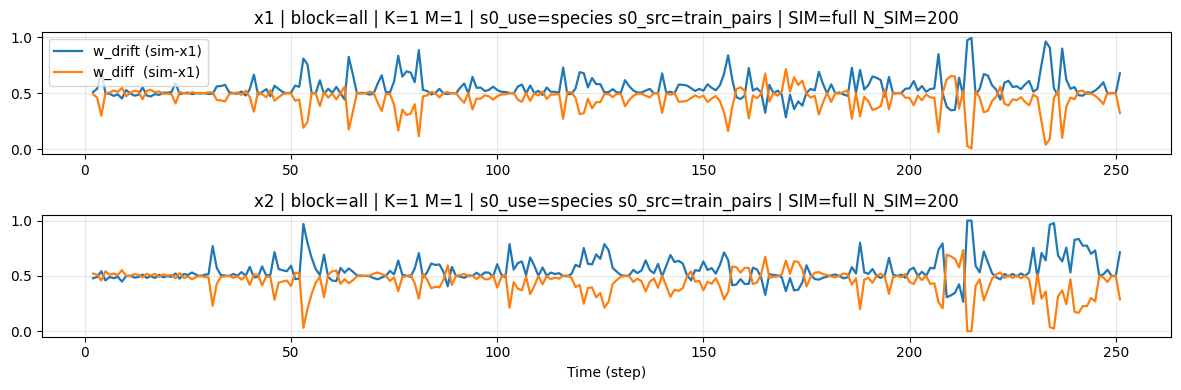

Done.
w_drift shape: (250, 2) w_diff shape: (250, 2)
✅ Saved plot data: out_excel_like/weights_only_sim\weights_plotdata_SIM=full_N200_block=all_K=1_M=1_s0use=species_s0src=train_pairs.xlsx
diag check: sigma std over time = [0.059508 0.06103 ]
diag check: s0 (species)        = [0.207432 0.209051]
diag check: max |sigma - s0|    = [0.226513 0.237811]


In [4]:
#============================================================
# LLD
# ============================================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions

# ===========================
# 0) 配置
# ===========================
ANALYZE_BLOCK   = "all"      # "all" / "train" / "val" / "test"
K_WIN           = 1
M_WIN           = 1

S0_SOURCE       = "train_pairs"   # "train_pairs" or "match_window"
S0_USE          = "species"       # "global" or "species"

TAU             = 1.0
EPS_DT          = 1e-12
USE_STUDENT_T   = False
NU_STUDENT_T    = 3

# ====== NEW: 模拟设置 ======
SIM_SOURCE      = "full"     # "full" / "drift_only" / "diff_only"
N_SIM           = 200          # 每个时刻采样次数（>1更稳但慢）
SEED_SIM        = 1111       # 随机种子

cfg = CONFIG
EPS_FLOOR = float(cfg.get("std_min_value", 1e-14))

# 输出目录
OUT_DIR = "out_excel_like/weights_only_sim"
os.makedirs(OUT_DIR, exist_ok=True)

# ===========================
# 1) 加载模型 + meta
# ===========================
model_use, solver, meta, (df, X_all, Z_all, T_all) = load_trained_model_for_plots(cfg)

idx_tr = meta["idx_tr"].astype(int)
idx_va = meta["idx_va"].astype(int)
idx_te = meta["idx_te"].astype(int)

mu_x = meta.get("mu_x", None)
sd_x = meta.get("sd_x", None)
mu_z = meta.get("mu_z", None)
sd_z = meta.get("sd_z", None)

standardize_x = bool(meta.get("standardize_x", True))
standardize_z = bool(meta.get("standardize_z", True))
cond_mode     = str(meta.get("cond_mode", cfg.get("cond_mode", "mean")))

if not standardize_x:
    mu_x = sd_x = None
if not standardize_z:
    mu_z = sd_z = None

names = list(cfg["state_cols"])

def _apply_stats(arr, mu, sd):
    return (arr - mu) / sd

def _pick_block_indices_from_meta(block: str):
    if block == "train":
        return idx_tr
    if block == "val":
        return idx_va
    if block == "test":
        return idx_te
    return np.arange(len(T_all), dtype=int)

def _build_C_rows(Z_blk, starts, K, cond_mode="mean"):
    C_rows = []
    for t0 in starts:
        seg = Z_blk[t0:t0 + K]
        if cond_mode == "mean":
            z_agg = seg.mean(axis=0)
        elif cond_mode == "sum":
            z_agg = seg.sum(axis=0)
        elif cond_mode == "last":
            z_agg = seg[-1]
        elif cond_mode == "start":
            z_agg = seg[0]
        else:
            z_agg = seg.mean(axis=0)

        dz = Z_blk[t0 + K - 1] - Z_blk[t0]
        C_rows.append(np.concatenate([z_agg, dz]))
    return np.vstack(C_rows).astype(np.float64)

def _logprob_per_dim(x, loc, scale, use_student_t=False, nu=3):
    scale = tf.maximum(scale, tf.cast(EPS_FLOOR, tf.float64))
    if use_student_t:
        dist = tfd.StudentT(df=tf.cast(nu, tf.float64), loc=loc, scale=scale)
    else:
        dist = tfd.Normal(loc=loc, scale=scale)
    return dist.log_prob(x)  # (N,d)

print(f"✅ meta split sizes: train={len(idx_tr)} val={len(idx_va)} test={len(idx_te)}")
print(f"✅ standardize_x={standardize_x}, standardize_z={standardize_z}, cond_mode={cond_mode}")
print(f"✅ Analyze block={ANALYZE_BLOCK}, K_WIN={K_WIN}, M_WIN={M_WIN}")
print(f"✅ SIM_SOURCE={SIM_SOURCE}, N_SIM={N_SIM}, SEED_SIM={SEED_SIM}")

# ===========================
# 2) s0 提取（严格对齐训练/或对齐窗口，二选一）
# ===========================
def extract_s0_train_pairs():
    rng = np.random.default_rng(int(meta.get("seed", cfg.get("seed", 42))))
    X_blk = X_all[idx_tr]
    Z_blk = Z_all[idx_tr]
    T_blk = T_all[idx_tr]

    Xn_tr, Xnp1_tr, C_tr, H_tr = build_multi_h_pairs_on_block(
        X_blk, Z_blk, T_blk,
        cfg["gaps"], cfg["max_per_gap"], cond_mode, rng=rng
    )

    if mu_x is not None:
        Xn_tr_s = _apply_stats(Xn_tr, mu_x, sd_x)
    else:
        Xn_tr_s = Xn_tr

    if mu_z is not None:
        C_tr_s = _apply_stats(C_tr, mu_z, sd_z)
    else:
        C_tr_s = C_tr

    Xn_tf = tf.convert_to_tensor(Xn_tr_s, dtype=tf.float64)
    C_tf  = tf.convert_to_tensor(C_tr_s,  dtype=tf.float64)

    _, sig_pred = model_use.call_xn(Xn_tf, C_tf)
    if len(sig_pred.shape) != 2:
        raise ValueError(f"Need diagonal sigma (N,d). got {sig_pred.shape}")

    sig_pred = tf.maximum(sig_pred, tf.cast(EPS_FLOOR, tf.float64))
    sig_np = sig_pred.numpy()
    return float(sig_np.mean()), sig_np.mean(axis=0)

def extract_s0_match_window():
    idx_blk = idx_tr
    X_blk = X_all[idx_blk]
    Z_blk = Z_all[idx_blk]
    T_blk = T_all[idx_blk]

    Tlen = len(T_blk)
    starts = np.arange(0, Tlen - K_WIN, M_WIN)
    ends   = starts + K_WIN
    if len(starts) == 0:
        raise RuntimeError("TRAIN block 太短，无法构造窗口；调小 K_WIN/M_WIN")

    x0 = X_blk[starts]
    C  = _build_C_rows(Z_blk, starts, K_WIN, cond_mode=cond_mode)

    if mu_x is not None:
        x0_s = _apply_stats(x0, mu_x, sd_x)
    else:
        x0_s = x0

    if mu_z is not None:
        C_s  = _apply_stats(C, mu_z, sd_z)
    else:
        C_s = C

    x0_tf = tf.convert_to_tensor(x0_s, dtype=tf.float64)
    C_tf  = tf.convert_to_tensor(C_s,  dtype=tf.float64)

    _, sig_pred = model_use.call_xn(x0_tf, C_tf)
    if len(sig_pred.shape) != 2:
        raise ValueError(f"Need diagonal sigma (N,d). got {sig_pred.shape}")

    sig_pred = tf.maximum(sig_pred, tf.cast(EPS_FLOOR, tf.float64))
    sig_np = sig_pred.numpy()
    return float(sig_np.mean()), sig_np.mean(axis=0)

if S0_SOURCE == "train_pairs":
    S0_GLOBAL_MEAN_ALLSPECIES, S0_SPECIES_MEAN = extract_s0_train_pairs()
elif S0_SOURCE == "match_window":
    S0_GLOBAL_MEAN_ALLSPECIES, S0_SPECIES_MEAN = extract_s0_match_window()
else:
    raise ValueError("S0_SOURCE must be 'train_pairs' or 'match_window'")

print("===== s0 extracted (standardized space) =====")
print("S0_GLOBAL_MEAN_ALLSPECIES =", S0_GLOBAL_MEAN_ALLSPECIES)
print("S0_SPECIES_MEAN           =", np.array(S0_SPECIES_MEAN))

# ===========================
# 3) 权重分解样本构造（block 用 meta 的 idx）
# ===========================
idx_blk = _pick_block_indices_from_meta(ANALYZE_BLOCK)
X_blk = X_all[idx_blk]
Z_blk = Z_all[idx_blk]
T_blk = T_all[idx_blk]

Tblk = len(T_blk)
starts = np.arange(0, Tblk - K_WIN, M_WIN)
ends   = starts + K_WIN
if len(starts) == 0:
    raise RuntimeError("Block 太短，无法构造窗口；调小 K_WIN 或换 block。")

x0 = X_blk[starts]
x1_obs = X_blk[ends]  # 仍保留：用于对照/导出；但 ll 用 x1_sim
dt = (T_blk[ends] - T_blk[starts])[:, None].astype(np.float64)
dt = np.maximum(dt, EPS_DT)

C  = _build_C_rows(Z_blk, starts, K_WIN, cond_mode=cond_mode)

# 标准化（训练一致）
if mu_x is not None:
    x0_s = _apply_stats(x0, mu_x, sd_x)
    x1_obs_s = _apply_stats(x1_obs, mu_x, sd_x)
else:
    x0_s, x1_obs_s = x0, x1_obs

if mu_z is not None:
    C_s = _apply_stats(C, mu_z, sd_z)
else:
    C_s = C

# ===========================
# 4) forward: μ(x0,C), σ(x0,C)
# ===========================
x0_tf = tf.convert_to_tensor(x0_s, dtype=tf.float64)
C_tf  = tf.convert_to_tensor(C_s,  dtype=tf.float64)
dt_tf = tf.convert_to_tensor(dt,   dtype=tf.float64)

dt_safe = tf.maximum(dt_tf, tf.constant(EPS_DT, dtype=tf.float64))
sqrtdt  = tf.sqrt(dt_safe)

mu_tf, sig_tf = model_use.call_xn(x0_tf, C_tf)
if len(sig_tf.shape) != 2:
    raise ValueError(f"Need diagonal sigma (N,d). got {sig_tf.shape}")

sig_safe = tf.maximum(sig_tf, tf.constant(EPS_FLOOR, dtype=tf.float64))
d = int(mu_tf.shape[1])

# ===========================
# 5) 构造 sig0_safe (N,d)
# ===========================
if S0_USE == "global":
    s0 = tf.cast(S0_GLOBAL_MEAN_ALLSPECIES, tf.float64)  # scalar
    sig0_safe = tf.ones_like(sig_safe) * tf.maximum(s0, tf.constant(EPS_FLOOR, tf.float64))
elif S0_USE == "species":
    s0 = tf.reshape(tf.convert_to_tensor(S0_SPECIES_MEAN, dtype=tf.float64), (1, d))
    sig0_safe = tf.broadcast_to(tf.maximum(s0, tf.constant(EPS_FLOOR, tf.float64)), tf.shape(sig_safe))
else:
    raise ValueError("S0_USE must be 'global' or 'species'.")

# ===========================
# 6) 用模型内部机制生成 x1_sim（关键改动）
# ===========================
tf.random.set_seed(int(SEED_SIM))

loc_full   = x0_tf + mu_tf * dt_safe
scale_full = sqrtdt * sig_safe

# drift-only: μ 保留，σ=s0
loc_drift   = loc_full
scale_drift = sqrtdt * sig0_safe

# diff-only: μ=0，σ 保留
loc_mu0   = x0_tf
scale_mu0 = scale_full

def _sample_x1(loc, scale, n_sim=1, use_student_t=False, nu=3):
    scale = tf.maximum(scale, tf.cast(EPS_FLOOR, tf.float64))
    if use_student_t:
        dist = tfd.StudentT(df=tf.cast(nu, tf.float64), loc=loc, scale=scale)
    else:
        dist = tfd.Normal(loc=loc, scale=scale)

    if n_sim == 1:
        return dist.sample()  # (N,d)
    # 多次采样 -> (n_sim,N,d)
    xs = dist.sample(sample_shape=(n_sim,))
    return xs

if SIM_SOURCE == "full":
    x1_sim = _sample_x1(loc_full, scale_full, n_sim=N_SIM, use_student_t=USE_STUDENT_T, nu=NU_STUDENT_T)
elif SIM_SOURCE == "drift_only":
    x1_sim = _sample_x1(loc_drift, scale_drift, n_sim=N_SIM, use_student_t=USE_STUDENT_T, nu=NU_STUDENT_T)
elif SIM_SOURCE == "diff_only":
    x1_sim = _sample_x1(loc_mu0, scale_mu0, n_sim=N_SIM, use_student_t=USE_STUDENT_T, nu=NU_STUDENT_T)
else:
    raise ValueError("SIM_SOURCE must be 'full' / 'drift_only' / 'diff_only'.")

# 统一成 (N,d)：若多次采样就做平均 logprob（更稳）
def _avg_logprob_over_samples(x_sim, loc, scale):
    if len(x_sim.shape) == 2:
        # (N,d)
        return _logprob_per_dim(x_sim, loc, scale, use_student_t=USE_STUDENT_T, nu=NU_STUDENT_T)
    # (S,N,d): 对每个样本算logprob后在S维平均
    S = int(x_sim.shape[0])
    lls = []
    for s in range(S):
        lls.append(_logprob_per_dim(x_sim[s], loc, scale, use_student_t=USE_STUDENT_T, nu=NU_STUDENT_T))
    return tf.add_n(lls) / tf.cast(S, tf.float64)

# ===========================
# 7) 用 x1_sim 计算 ll: full / drift-only(s0) / diff-only(mu=0)
# ===========================
ll_full  = _avg_logprob_over_samples(x1_sim, loc_full,  scale_full)
ll_drift = _avg_logprob_over_samples(x1_sim, loc_drift, scale_drift)
ll_mu0   = _avg_logprob_over_samples(x1_sim, loc_mu0,   scale_mu0)

# ===========================
# 8) Eq16-17 softmax 权重（逐维）
# ===========================
Lbar_full  = ll_full  / dt_safe
Lbar_drift = ll_drift / dt_safe
Lbar_diff  = ll_mu0   / dt_safe

a = (Lbar_drift - Lbar_full) / float(TAU)
b = (Lbar_diff  - Lbar_full) / float(TAU)
m_ = tf.maximum(a, b)
ea = tf.exp(a - m_)
eb = tf.exp(b - m_)
den = ea + eb + tf.constant(1e-12, tf.float64)

w_drift = ea / den
w_diff  = eb / den

w_drift_np = w_drift.numpy()
w_diff_np  = w_diff.numpy()

# ===========================
# 9) 可视化（与原版一致）
# ===========================
time_axis = T_blk[ends]

plt.figure(figsize=(12, 2*len(names)))
for j, nm in enumerate(names):
    ax = plt.subplot(len(names), 1, j+1)
    y1 = w_drift_np[:, j]
    y2 = w_diff_np[:, j]
    ax.plot(time_axis, y1, label="w_drift (sim-x1)", lw=1.6)
    ax.plot(time_axis, y2, label="w_diff  (sim-x1)", lw=1.6)
    ax.grid(alpha=0.3)

    ymin = float(np.min([y1.min(), y2.min()]))
    ymax = float(np.max([y1.max(), y2.max()]))
    pad = 0.05 * (ymax - ymin + 1e-12)
    ax.set_ylim(ymin - pad, ymax + pad)

    ax.set_title(
        f"{nm} | block={ANALYZE_BLOCK} | K={K_WIN} M={M_WIN} | "
        f"s0_use={S0_USE} s0_src={S0_SOURCE} | SIM={SIM_SOURCE} N_SIM={N_SIM}"
    )
    if j == 0:
        ax.legend()

plt.xlabel("Time (step)")
plt.tight_layout()
plt.show()

print("Done.")
print("w_drift shape:", w_drift_np.shape, "w_diff shape:", w_diff_np.shape)

# ===========================
# 10) 导出 Excel（权重 + 可选对照）
# ===========================
df_plot = pd.DataFrame({"time": np.asarray(time_axis).reshape(-1)})
for j, nm in enumerate(names):
    df_plot[f"w_drift__{nm}"] = w_drift_np[:, j]
    df_plot[f"w_diff__{nm}"]  = w_diff_np[:, j]

    # （可选）导出 obs vs sim 的增量均值，方便你 sanity check
    if len(x1_sim.shape) == 2:
        dx_sim = (x1_sim.numpy() - x0_s)  # standardized space
    else:
        dx_sim = (tf.reduce_mean(x1_sim, axis=0).numpy() - x0_s)

    dx_obs = (x1_obs_s - x0_s)
    df_plot[f"dx_obs__{nm}"] = dx_obs[:, j]
    df_plot[f"dx_sim__{nm}"] = dx_sim[:, j]

xlsx_path = os.path.join(
    OUT_DIR,
    f"weights_plotdata_SIM={SIM_SOURCE}_N{N_SIM}_block={ANALYZE_BLOCK}_K={K_WIN}_M={M_WIN}_s0use={S0_USE}_s0src={S0_SOURCE}.xlsx"
)
df_plot.to_excel(xlsx_path, index=False)
print("✅ Saved plot data:", xlsx_path)

# ---- 诊断：sigma 是否随时间变化、s0大小 ----
sig_np = sig_safe.numpy()
print("diag check: sigma std over time =", sig_np.std(axis=0))
print("diag check: s0 (species)        =", np.array(S0_SPECIES_MEAN))
print("diag check: max |sigma - s0|    =", np.max(np.abs(sig_np - np.array(S0_SPECIES_MEAN)[None,:]), axis=0))


✅ Loaded weights: data/resnetdz1111_final1.h5
✅ Loaded meta   : data/resnetdz1111_final1_meta.npz
[Time split(meta)] train=175, val=25, test=51
✅ Loaded model/meta.
   block=all | gap=3 | cond_mode=mean | diff_type=diagonal
   dims: n_x=2 | n_z=19 | C_dim=38
✅ Z alignment: timepoint (len=|X|)
✅ MU_MODE auto -> drift (median relerr drift=0.435, incr=0.812)
mean(w_mu+w_sigma) = 0.9999999999978129
✅ Saved: out_pdf_like/direct_ratio_norm_em\direct_ratio_gap3_block=all_cond=mean_diff=diagonal_mu=drift.xlsx  rows=496

=== Δt_crit stats (by species) ===
         count          mean            std       min        25%        50%  \
species                                                                       
x1       248.0   7350.937994   57338.960085  3.992022  24.905944  73.793543   
x2       248.0  22290.992663  281890.299081  1.867353  23.548512  74.593129   

                75%           max  
species                            
x1       292.792102  6.398465e+05  
x2       395.360636  4

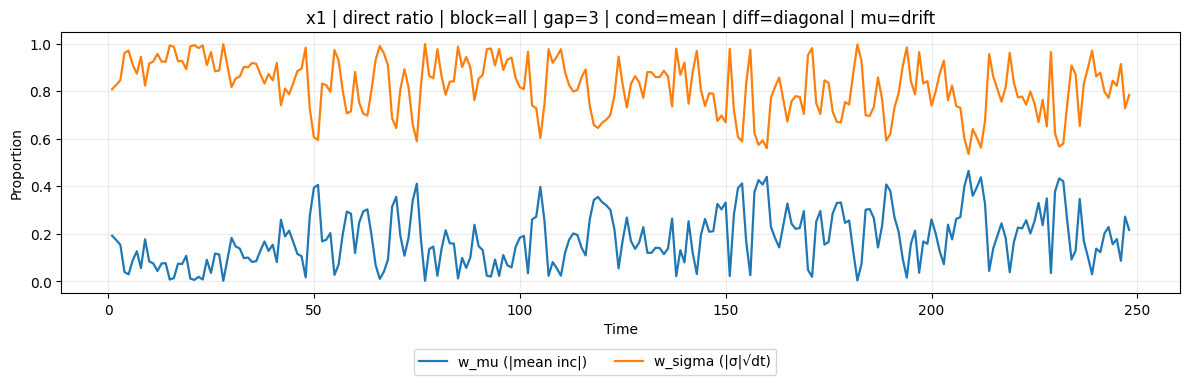

🖼 Saved plot: out_pdf_like/direct_ratio_norm_em\ratio_x1_gap3_block=all_cond=mean_diff=diagonal_mu=drift.png


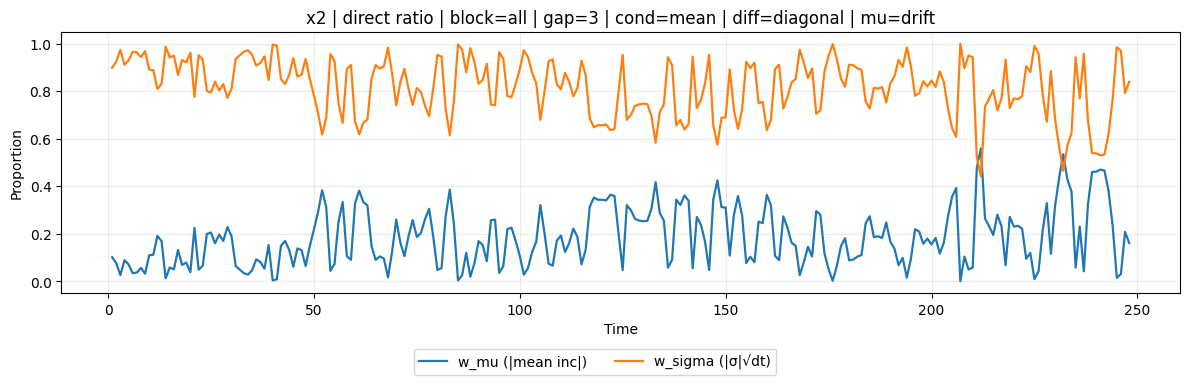

🖼 Saved plot: out_pdf_like/direct_ratio_norm_em\ratio_x2_gap3_block=all_cond=mean_diff=diagonal_mu=drift.png


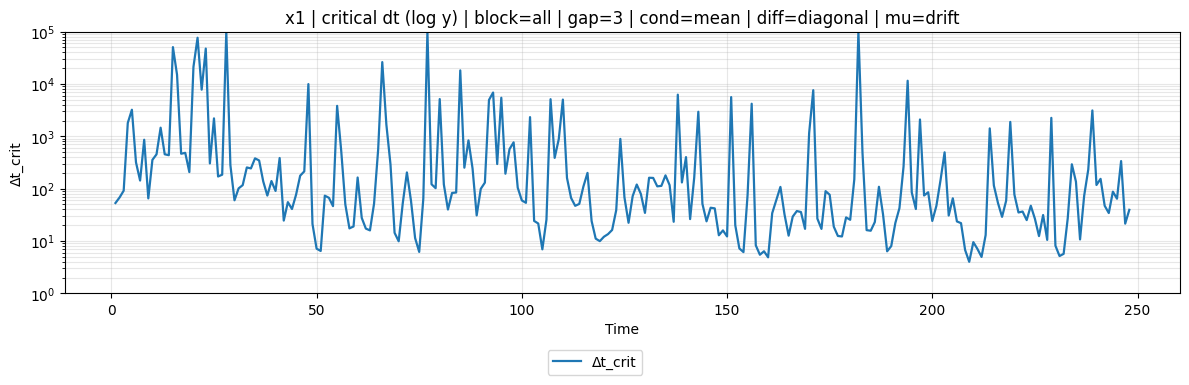

🖼 Saved plot: out_pdf_like/direct_ratio_norm_em\crit_dt_x1_gap3_block=all_cond=mean_diff=diagonal_mu=drift.png


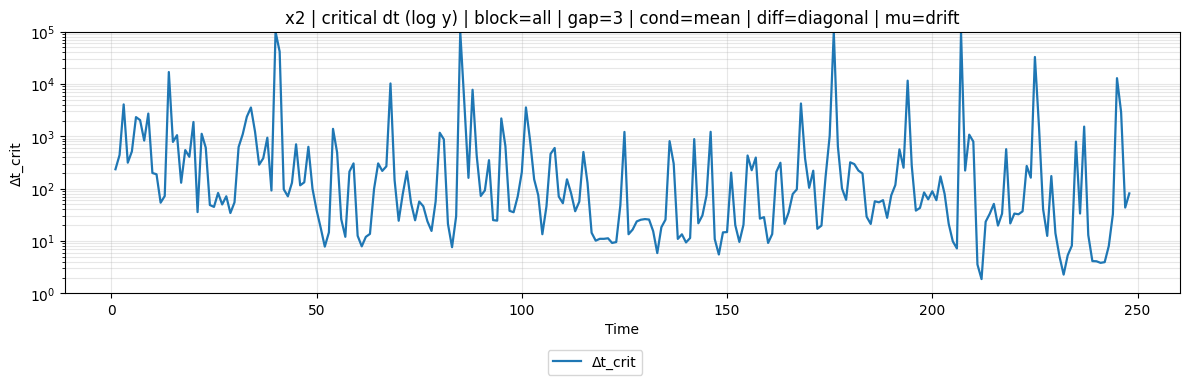

🖼 Saved plot: out_pdf_like/direct_ratio_norm_em\crit_dt_x2_gap3_block=all_cond=mean_diff=diagonal_mu=drift.png


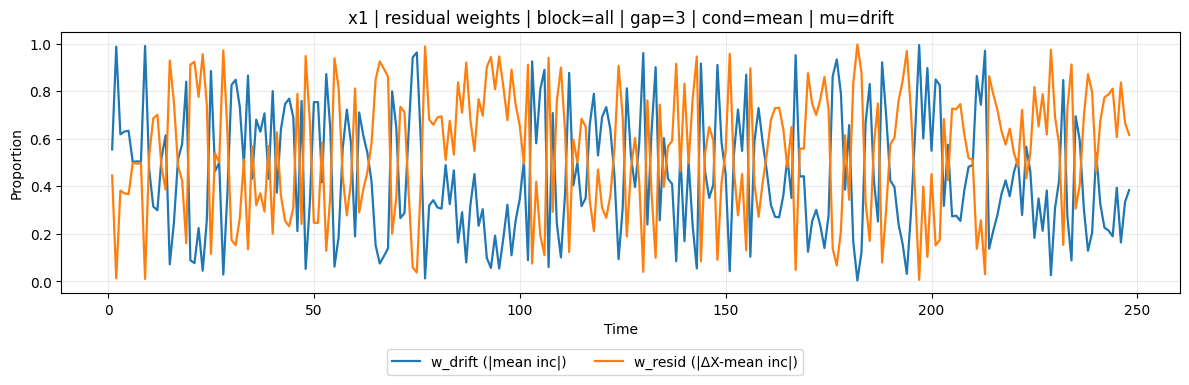

🖼 Saved plot: out_pdf_like/direct_ratio_norm_em\residual_ratio_x1_gap3_block=all_cond=mean_mu=drift.png


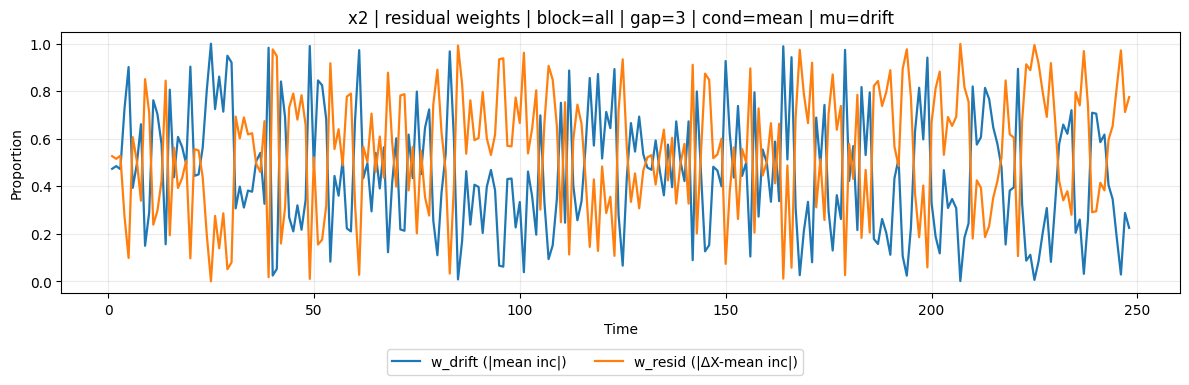

🖼 Saved plot: out_pdf_like/direct_ratio_norm_em\residual_ratio_x2_gap3_block=all_cond=mean_mu=drift.png
✅ Done.


In [5]:
# ============================================================
# direct ratio + Δt_crit + (optional) residual weights
# ============================================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions

# ---------------------------
# 0) Config
# ---------------------------
ANALYZE_BLOCK = "all"
K_GAP         = 3
OUT_DIR       = "out_pdf_like/direct_ratio_norm_em"
PREFER_BEST   = False

COND_MODE     = None    # None or "mean"/"sum"/"last"/"start"

CRIT_YMIN, CRIT_YMAX = 1e0, 1e5
EXPORT_RESIDUAL_WEIGHTS = True

EPS_DT   = 1e-12
EPS_DEN  = 1e-12
EPS_MU   = 1e-12

MU_MODE = "auto"  # "auto" / "drift" / "increment"

os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# 1) Load model/meta
# ---------------------------
model_use, solver, meta, (df, X_all, Z_all, T_all) = load_trained_model_for_plots(
    CONFIG, prefer_best=PREFER_BEST
)

idx_tr = meta["idx_tr"].astype(int)
idx_va = meta["idx_va"].astype(int)
idx_te = meta["idx_te"].astype(int)

mu_x = meta.get("mu_x", None)
sd_x = meta.get("sd_x", None)
mu_z = meta.get("mu_z", None)
sd_z = meta.get("sd_z", None)

standardize_x = bool(meta.get("standardize_x", True))
standardize_z = bool(meta.get("standardize_z", True))
if not standardize_x:
    mu_x = sd_x = None
if not standardize_z:
    mu_z = sd_z = None

state_cols = list(meta.get("state_cols", CONFIG["state_cols"]))
param_cols = list(meta.get("param_cols", CONFIG["param_cols"]))
diff_type  = str(meta.get("diff_type", CONFIG.get("diff_type", "diagonal")))
cond_mode_meta = str(meta.get("cond_mode", CONFIG.get("cond_mode", "mean")))

if COND_MODE is None:
    COND_MODE = cond_mode_meta

if not isinstance(COND_MODE, str):
    raise TypeError(f"COND_MODE must be str, got {type(COND_MODE)}")
COND_MODE = COND_MODE.lower()
assert COND_MODE in ["mean", "sum", "last", "start"], f"Invalid COND_MODE={COND_MODE}"

d = len(state_cols)
p = len(param_cols)
STD_FLOOR = float(CONFIG.get("std_min_value", 1e-14))

print("✅ Loaded model/meta.")
print(f"   block={ANALYZE_BLOCK} | gap={K_GAP} | cond_mode={COND_MODE} | diff_type={diff_type}")
print(f"   dims: n_x={d} | n_z={p} | C_dim={2*p}")

# ---------------------------
# 2) Helpers
# ---------------------------
def _pick_block_indices(block: str):
    block = str(block).lower()
    if block == "train": return idx_tr
    if block == "val":   return idx_va
    if block == "test":  return idx_te
    return np.arange(len(T_all), dtype=int)

def _apply_stats(arr, mu, sd):
    return (arr - mu) / sd

def _softplus_floor_np(x, floor):
    return np.logaddexp(0.0, x) + floor

def _aggregate_z_segment(Z, start, length, mode="mean"):
    seg = Z[start:start+length]
    if mode == "mean":  return seg.mean(axis=0)
    if mode == "sum":   return seg.sum(axis=0)
    if mode == "last":  return seg[-1]
    if mode == "start": return seg[0]
    return seg.mean(axis=0)

# ---- Z alignment detect
Z_is_interval  = (len(Z_all) == len(X_all) - 1)  # interval covariates
Z_is_timepoint = (len(Z_all) == len(X_all))      # timepoint covariates
if not (Z_is_interval or Z_is_timepoint):
    print("⚠️ Unexpected Z length; assuming timepoint-like but will guard indices.")
    Z_is_timepoint = True
    Z_is_interval = False
print(f"✅ Z alignment: {'interval (len=|X|-1)' if Z_is_interval else 'timepoint (len=|X|)'}")

def _build_C_gap(Z_global, starts_global, gap, cond_mode="mean"):
    C_rows = []
    for t in starts_global:
        if Z_is_interval:
            # window = gap intervals: t..t+gap-1
            z_agg = _aggregate_z_segment(Z_global, t, gap, cond_mode)
            dz    = Z_global[t + gap - 1] - Z_global[t]
        else:
            # window = gap+1 timepoints: t..t+gap (inclusive)
            z_agg = _aggregate_z_segment(Z_global, t, gap + 1, cond_mode)
            dz    = Z_global[t + gap] - Z_global[t]
        C_rows.append(np.concatenate([z_agg, dz]))
    return np.vstack(C_rows).astype(np.float64)

def _contiguous_run_starts(idx_blk, gap):
    """
    Find starts t s.t. X[t..t+gap] contiguous and Z indices valid under alignment.
    """
    idx_sorted = np.sort(np.asarray(idx_blk, dtype=int))
    if idx_sorted.size == 0:
        return np.array([], dtype=int)

    breaks = np.where(np.diff(idx_sorted) != 1)[0]
    run_starts_pos = np.r_[0, breaks + 1]
    run_ends_pos   = np.r_[breaks, idx_sorted.size - 1]

    nX = len(X_all)
    nZ = len(Z_all)
    starts = []

    for a_pos, b_pos in zip(run_starts_pos, run_ends_pos):
        a = idx_sorted[a_pos]
        b = idx_sorted[b_pos]
        if (b - a + 1) < gap + 1:
            continue
        for t in range(a, b - gap + 1):
            end = t + gap
            if end >= nX:
                continue
            if Z_is_interval:
                if (t + gap - 1) >= nZ:
                    continue
            else:
                if (t + gap) >= nZ:
                    continue
            starts.append(t)

    return np.asarray(starts, dtype=int)

# ---------------------------
# 3) diff -> marginal sigma
# ---------------------------
def _fix_tril_diag(L, floor):
    diag = np.diagonal(L, axis1=1, axis2=2)
    diag_fixed = np.abs(diag) + floor
    L2 = L.copy()
    idx = np.arange(L.shape[1])
    L2[:, idx, idx] = diag_fixed
    return L2

def _sigma_marginal_from_diff(diff_raw, diff_type, floor=1e-14):
    diff_type = str(diff_type).lower()

    if diff_type == "diagonal":
        # ✅ robust positivity
        sig = _softplus_floor_np(diff_raw, floor)
        return sig[:, :d]

    if diff_type == "triangular":
        # accept (N,d,d) or (N,k)
        if diff_raw.ndim == 2:
            L = tfp.math.fill_triangular(diff_raw).numpy()
        else:
            L = diff_raw
        L = _fix_tril_diag(L, floor)
        var = np.sum(L**2, axis=2)
        return np.sqrt(np.maximum(var, floor**2))

    if diff_type == "spd":
        # accept (N,d,d) covariance OR (N,k) cholesky-flat
        if diff_raw.ndim == 2:
            L = tfp.math.fill_triangular(diff_raw).numpy()
            L = _fix_tril_diag(L, floor)
            var = np.sum(L**2, axis=2)
            return np.sqrt(np.maximum(var, floor**2))

        M = diff_raw
        sym_err = np.max(np.abs(M - np.swapaxes(M, 1, 2)))
        scale   = np.max(np.abs(M)) + 1e-12
        if sym_err > 1e-6 * scale:
            L = _fix_tril_diag(M, floor)
            var = np.sum(L**2, axis=2)
            return np.sqrt(np.maximum(var, floor**2))

        cov = M + (floor**2) * np.eye(M.shape[1])[None, :, :]
        var = np.diagonal(cov, axis1=1, axis2=2)
        return np.sqrt(np.maximum(var, floor**2))

    if diff_type == "auto":
        # keep your original (assumes vector layout)
        N = diff_raw.shape[0]
        d_ = d
        k = d_ * (d_ + 1) // 2

        d_raw     = diff_raw[:, 0:d_]
        tri_flat  = diff_raw[:, d_:d_+k]
        spd_flat  = diff_raw[:, d_+k:d_+2*k]
        gate_log  = diff_raw[:, d_+2*k:d_+2*k+3]

        gate = np.exp(gate_log - np.max(gate_log, axis=1, keepdims=True))
        gate = gate / (np.sum(gate, axis=1, keepdims=True) + 1e-12)

        sig = _softplus_floor_np(d_raw, floor)
        cov_diag = np.zeros((N, d_, d_), dtype=np.float64)
        for i in range(d_):
            cov_diag[:, i, i] = sig[:, i]**2

        L1 = tfp.math.fill_triangular(tri_flat).numpy()
        L1 = _fix_tril_diag(L1, floor)
        cov_tri = np.einsum("nij,nkj->nik", L1, L1)

        L2 = tfp.math.fill_triangular(spd_flat).numpy()
        L2 = _fix_tril_diag(L2, floor)
        cov_spd = np.einsum("nij,nkj->nik", L2, L2)

        cov = (gate[:, 0][:, None, None] * cov_diag +
               gate[:, 1][:, None, None] * cov_tri +
               gate[:, 2][:, None, None] * cov_spd)
        cov = cov + (floor**2) * np.eye(d_)[None, :, :]
        var = np.diagonal(cov, axis1=1, axis2=2)
        return np.sqrt(np.maximum(var, floor**2))

    raise ValueError(f"Unsupported diff_type={diff_type}")

# ---------------------------
# 4) Build gap pairs
# ---------------------------
idx_blk_raw = _pick_block_indices(ANALYZE_BLOCK)
starts_global = _contiguous_run_starts(idx_blk_raw, K_GAP)
if starts_global.size == 0:
    raise ValueError(f"❌ block={ANALYZE_BLOCK} no contiguous runs for gap={K_GAP}")

ends_global = starts_global + K_GAP

x0 = X_all[starts_global].astype(np.float64)
x1 = X_all[ends_global].astype(np.float64)
dt = (T_all[ends_global] - T_all[starts_global]).reshape(-1, 1).astype(np.float64)

dt_safe = np.maximum(dt, EPS_DT)
sqrt_dt = np.sqrt(dt_safe)

C = _build_C_gap(Z_all, starts_global, K_GAP, cond_mode=COND_MODE)
time_axis = T_all[starts_global]

# standardize to training space
x0_s = _apply_stats(x0, mu_x, sd_x) if (mu_x is not None) else x0
x1_s = _apply_stats(x1, mu_x, sd_x) if (mu_x is not None) else x1
C_s  = _apply_stats(C,  mu_z, sd_z) if (mu_z is not None) else C

# ---------------------------
# 5) Forward
# ---------------------------
x0_tf = tf.convert_to_tensor(x0_s, dtype=tf.float64)
C_tf  = tf.convert_to_tensor(C_s,  dtype=tf.float64)

mu_s_tf, diff_tf = model_use.call_xn(x0_tf, C_tf)
mu_s  = mu_s_tf.numpy()
diff  = diff_tf.numpy()

sigma_marg_s = _sigma_marginal_from_diff(diff, diff_type=diff_type, floor=STD_FLOOR)

# map back to original scale (scale only)
sd = (np.asarray(sd_x, dtype=np.float64) if (sd_x is not None) else np.ones((1, d), dtype=np.float64)).reshape(1, -1)

mu_base    = mu_s * sd
sigma_orig = sigma_marg_s * sd  # diffusion coeff (no sqrt(dt))

# ---------------------------
# 6) MU_MODE auto-detect (drift vs increment)
# ---------------------------
actual_inc = x1 - x0

def _robust_median_abs(a):
    a = np.asarray(a)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return np.nan
    return float(np.median(np.abs(a)))

mu_mode_use = MU_MODE.lower()
if mu_mode_use == "auto":
    errs_rate, errs_inc = [], []
    for j in range(d):
        m_mu   = _robust_median_abs(mu_base[:, j])
        m_inc  = _robust_median_abs(actual_inc[:, j])
        m_rate = _robust_median_abs(actual_inc[:, j] / dt_safe[:, 0])

        e_rate = abs(m_mu - m_rate) / (m_rate + 1e-12)
        e_inc  = abs(m_mu - m_inc)  / (m_inc  + 1e-12)

        errs_rate.append(e_rate)
        errs_inc.append(e_inc)

    if float(np.median(errs_rate)) <= float(np.median(errs_inc)):
        mu_mode_use = "drift"
    else:
        mu_mode_use = "increment"
    print(f"✅ MU_MODE auto -> {mu_mode_use} (median relerr drift={np.median(errs_rate):.3g}, incr={np.median(errs_inc):.3g})")
else:
    assert mu_mode_use in ["drift", "increment"]

# mean increment used for ratio/residual
if mu_mode_use == "drift":
    mean_inc = mu_base * dt_safe
    dt_crit  = (np.abs(sigma_orig) / (np.abs(mu_base) + EPS_MU))**2
else:
    mean_inc = mu_base
    # solve |mean_inc| = |sigma| sqrt(dt)  -> dt = (|mean_inc|/|sigma|)^2
    dt_crit  = (np.abs(mean_inc) / (np.abs(sigma_orig) + EPS_MU))**2

# ---------------------------
# 7) direct ratio + residual weights
# ---------------------------
dX_mu    = np.abs(mean_inc)
dX_sigma = np.abs(sigma_orig) * sqrt_dt

den = dX_mu + dX_sigma + EPS_DEN
w_mu    = dX_mu / den
w_sigma = dX_sigma / den

drift_inc = mean_inc
resid_inc = actual_inc - drift_inc

den2 = np.abs(drift_inc) + np.abs(resid_inc) + EPS_DEN
w_drift = np.abs(drift_inc) / den2
w_resid = np.abs(resid_inc) / den2

print("mean(w_mu+w_sigma) =", float(np.mean(w_mu + w_sigma)))

# ---------------------------
# 8) Save Excel
# ---------------------------
rows = []
for j, nm in enumerate(state_cols):
    block_df = pd.DataFrame({
        "time": time_axis,
        "gap": K_GAP,
        "dt": dt[:, 0],
        "species": nm,

        "x_t": x0[:, j],
        "x_tK": x1[:, j],
        "actual_inc": actual_inc[:, j],

        "mu_base": mu_base[:, j],
        "mu_mode": mu_mode_use,
        "mean_inc": mean_inc[:, j],

        "sigma_marg_orig": sigma_orig[:, j],

        "dX_mu": dX_mu[:, j],
        "dX_sigma": dX_sigma[:, j],
        "w_mu": w_mu[:, j],
        "w_sigma": w_sigma[:, j],

        "dt_crit": dt_crit[:, j],

        "drift_inc": drift_inc[:, j],
        "resid_inc": resid_inc[:, j],
        "w_drift": w_drift[:, j],
        "w_resid": w_resid[:, j],
    })
    if not EXPORT_RESIDUAL_WEIGHTS:
        block_df = block_df.drop(columns=["drift_inc","resid_inc","w_drift","w_resid"])
    rows.append(block_df)

out_df = pd.concat(rows, ignore_index=True)

out_xlsx = os.path.join(
    OUT_DIR,
    f"direct_ratio_gap{K_GAP}_block={ANALYZE_BLOCK}_cond={COND_MODE}_diff={diff_type}_mu={mu_mode_use}.xlsx"
)
out_df.to_excel(out_xlsx, index=False)
print(f"✅ Saved: {out_xlsx}  rows={len(out_df)}")

print("\n=== Δt_crit stats (by species) ===")
print(out_df.groupby("species")["dt_crit"].describe())

# ---------------------------
# 9) Plot 1: direct ratio
# ---------------------------
for j, nm in enumerate(state_cols):
    fig, ax = plt.subplots(figsize=(12, 3.8))
    ax.plot(time_axis, w_mu[:, j],    label="w_mu (|mean inc|)", lw=1.6)
    ax.plot(time_axis, w_sigma[:, j], label="w_sigma (|σ|√dt)", lw=1.6)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(f"{nm} | direct ratio | block={ANALYZE_BLOCK} | gap={K_GAP} | cond={COND_MODE} | diff={diff_type} | mu={mu_mode_use}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Proportion")
    ax.grid(alpha=0.25)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.02),
               ncol=2, frameon=True)
    fig.tight_layout(rect=[0.0, 0.06, 1.0, 1.0])

    figpath = os.path.join(OUT_DIR, f"ratio_{nm}_gap{K_GAP}_block={ANALYZE_BLOCK}_cond={COND_MODE}_diff={diff_type}_mu={mu_mode_use}.png")
    plt.savefig(figpath, dpi=180, bbox_inches="tight")
    plt.show()
    print(f"🖼 Saved plot: {figpath}")

# ---------------------------
# 10) Plot 2: critical dt (log y)
# ---------------------------
for j, nm in enumerate(state_cols):
    fig, ax = plt.subplots(figsize=(12, 3.8))
    y = dt_crit[:, j].copy()
    y_plot = np.clip(y, CRIT_YMIN, CRIT_YMAX)

    ax.plot(time_axis, y_plot, label="Δt_crit", lw=1.6)
    ax.set_yscale("log")
    ax.set_ylim(CRIT_YMIN, CRIT_YMAX)
    ax.set_title(f"{nm} | critical dt (log y) | block={ANALYZE_BLOCK} | gap={K_GAP} | cond={COND_MODE} | diff={diff_type} | mu={mu_mode_use}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Δt_crit")
    ax.grid(which="both", alpha=0.3)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.02),
               ncol=1, frameon=True)
    fig.tight_layout(rect=[0.0, 0.06, 1.0, 1.0])

    figpath = os.path.join(OUT_DIR, f"crit_dt_{nm}_gap{K_GAP}_block={ANALYZE_BLOCK}_cond={COND_MODE}_diff={diff_type}_mu={mu_mode_use}.png")
    plt.savefig(figpath, dpi=180, bbox_inches="tight")
    plt.show()
    print(f"🖼 Saved plot: {figpath}")

# ---------------------------
# 11) Plot 3: residual weights
# ---------------------------
if EXPORT_RESIDUAL_WEIGHTS:
    for j, nm in enumerate(state_cols):
        fig, ax = plt.subplots(figsize=(12, 3.8))
        ax.plot(time_axis, w_drift[:, j], label="w_drift (|mean inc|)", lw=1.6)
        ax.plot(time_axis, w_resid[:, j], label="w_resid (|ΔX-mean inc|)", lw=1.6)
        ax.set_ylim(-0.05, 1.05)
        ax.set_title(f"{nm} | residual weights | block={ANALYZE_BLOCK} | gap={K_GAP} | cond={COND_MODE} | mu={mu_mode_use}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Proportion")
        ax.grid(alpha=0.25)

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.02),
                   ncol=2, frameon=True)
        fig.tight_layout(rect=[0.0, 0.06, 1.0, 1.0])

        figpath = os.path.join(OUT_DIR, f"residual_ratio_{nm}_gap{K_GAP}_block={ANALYZE_BLOCK}_cond={COND_MODE}_mu={mu_mode_use}.png")
        plt.savefig(figpath, dpi=180, bbox_inches="tight")
        plt.show()
        print(f"🖼 Saved plot: {figpath}")

print("✅ Done.")


[Time split] train_len=175, val_len=25, test_len=51
[flags] val_cross_pairs=True | use_test_pairs=False | test_cross_pairs=True
[MAXG] max_gap=169
[Pairs for stats] train_pairs=15210 (gaps_used=1..169)
✅ Loaded weights from: data/resnetdz1111_best1.h5


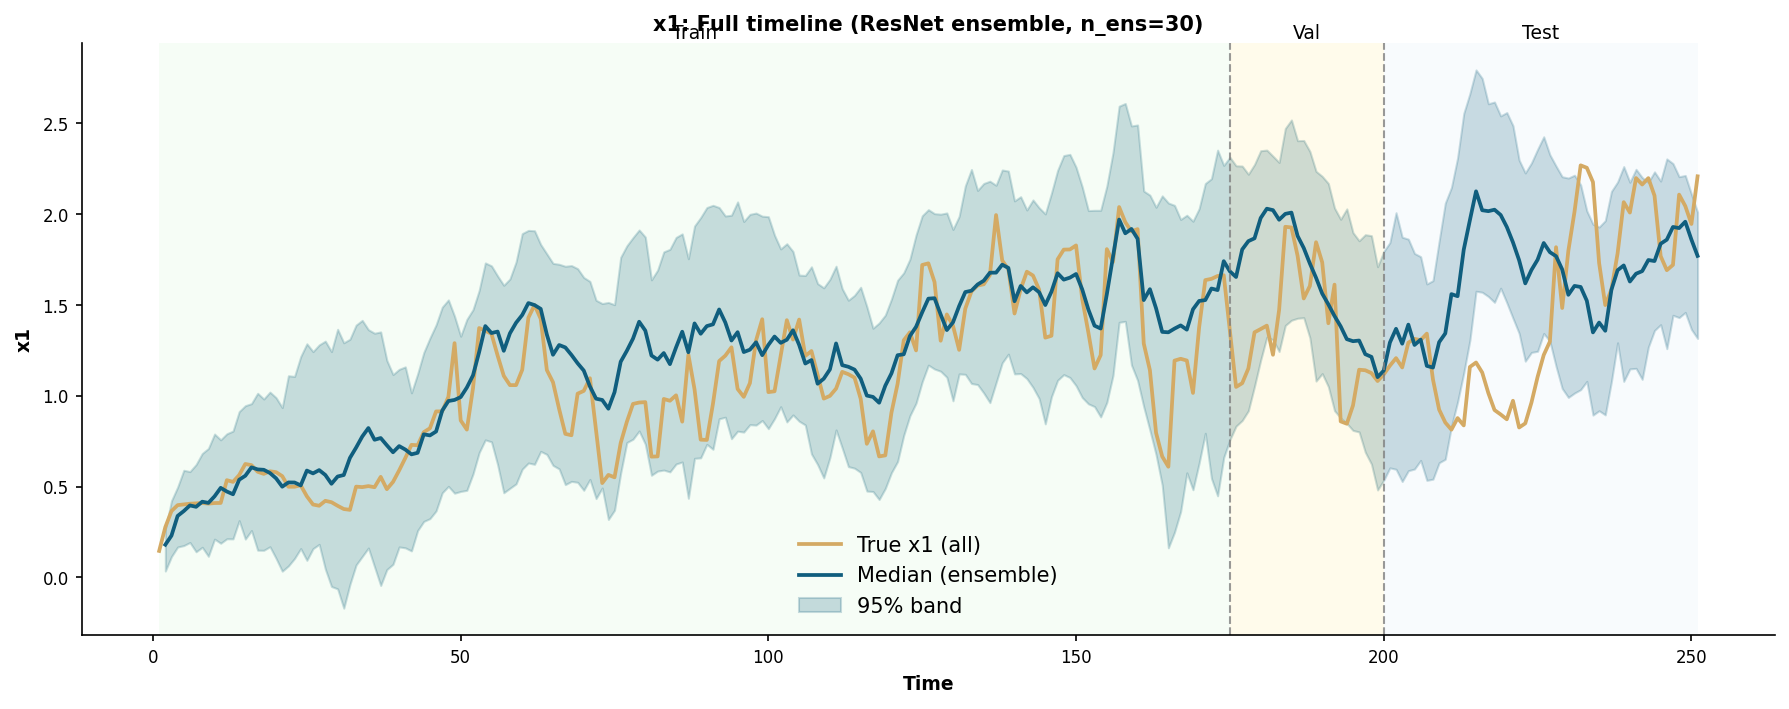

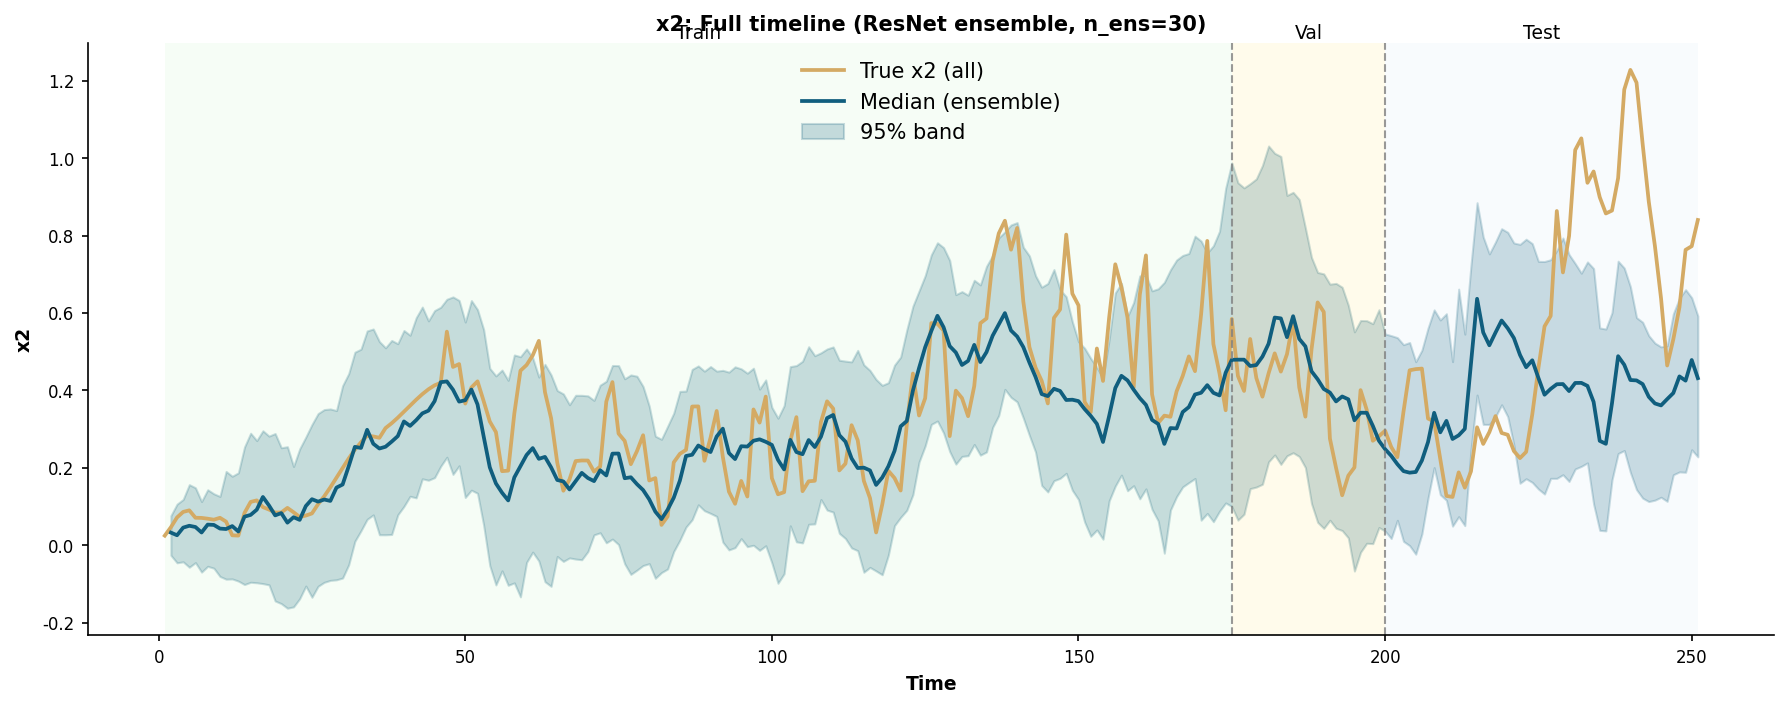


[95% band coverage] overall (希望接近 0.95)：
  x1: coverage=0.896, mean width=1.0831
  x2: coverage=0.844, mean width=0.4820

[95% band coverage] by segment:
  -- Train --
    x1: cov=0.994, width=1.0738
    x2: cov=0.931, width=0.4502
  -- Val --
    x1: cov=0.880, width=1.1437
    x2: cov=1.000, width=0.6794
  -- Test --
    x1: cov=0.569, width=1.0850
    x2: cov=0.471, width=0.4938

[LV drift contribution] mean E[||LV||^2 / ||total||^2] on test (gap=1) = 0.718
  dim x1: mean |LV| / (|LV|+|ResNet|) ≈ 0.248
  dim x2: mean |LV| / (|LV|+|ResNet|) ≈ 0.279


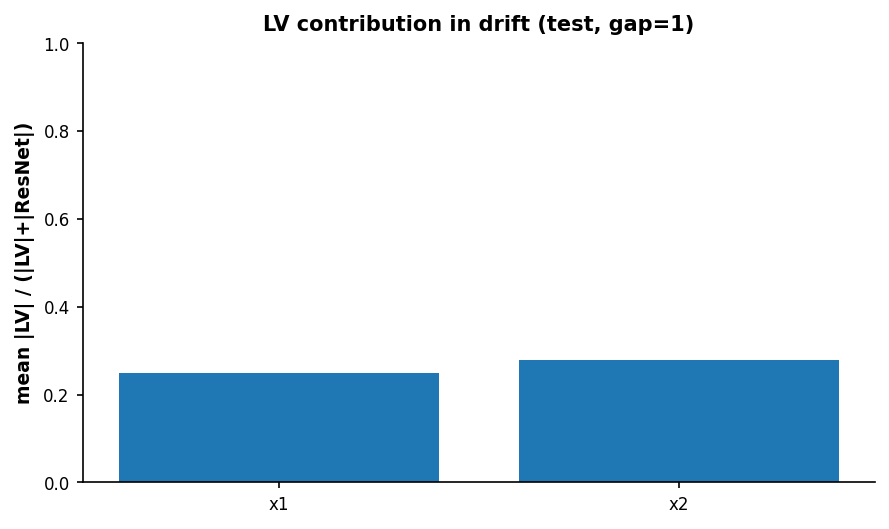

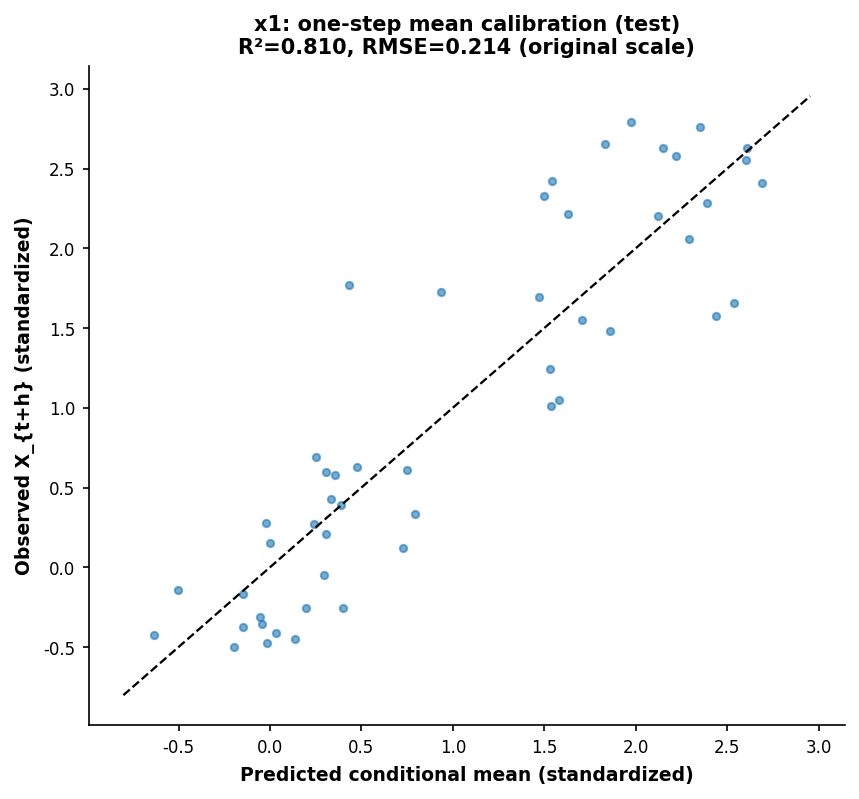

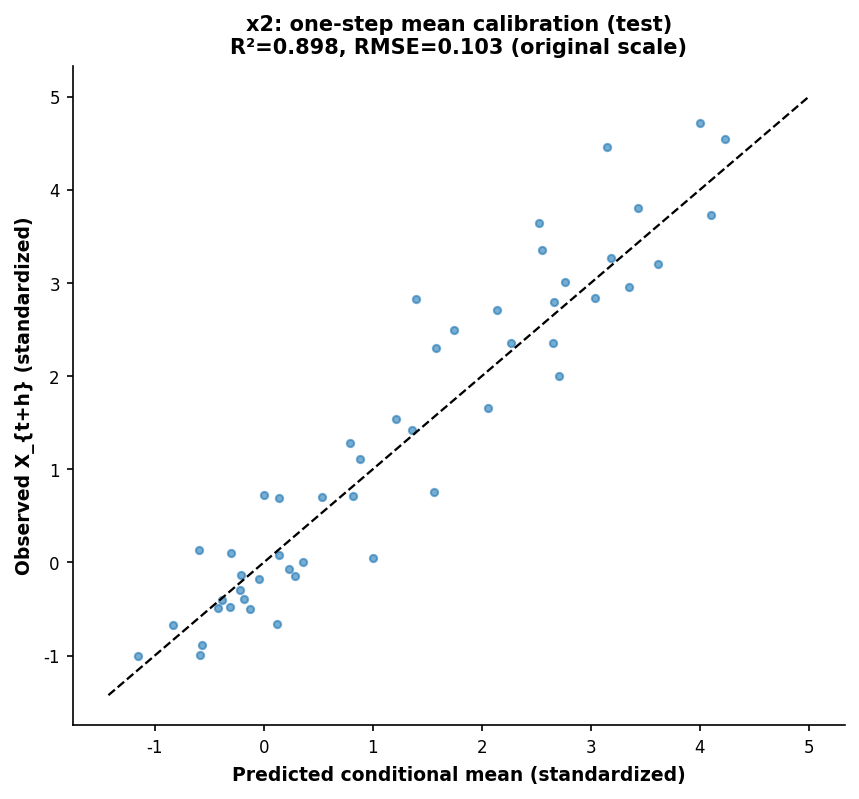

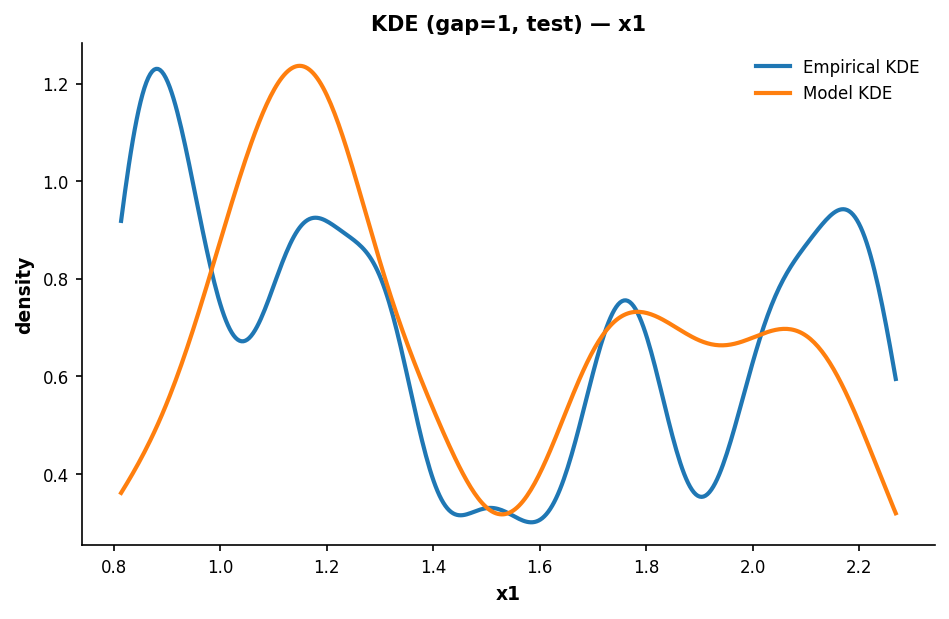

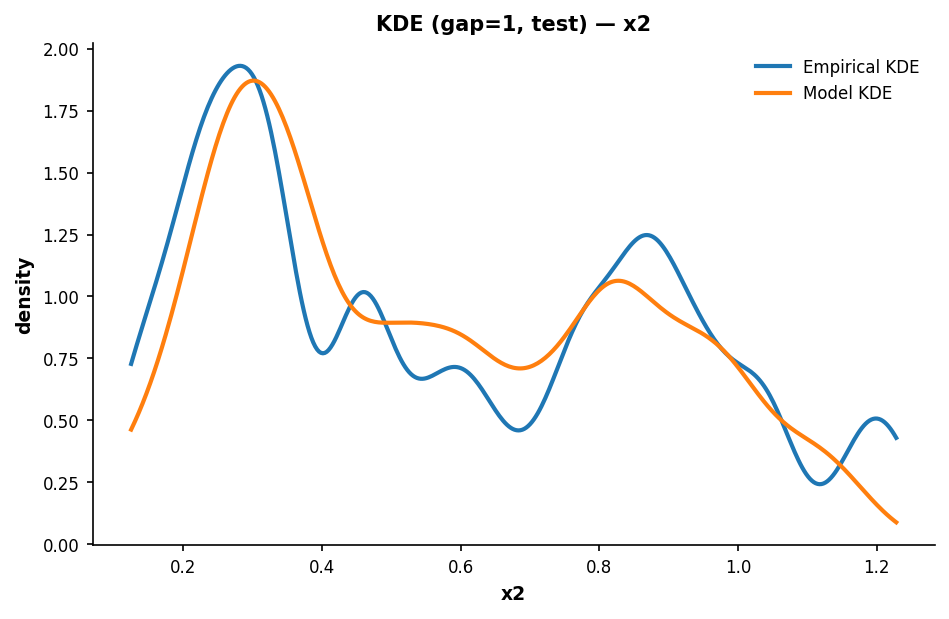

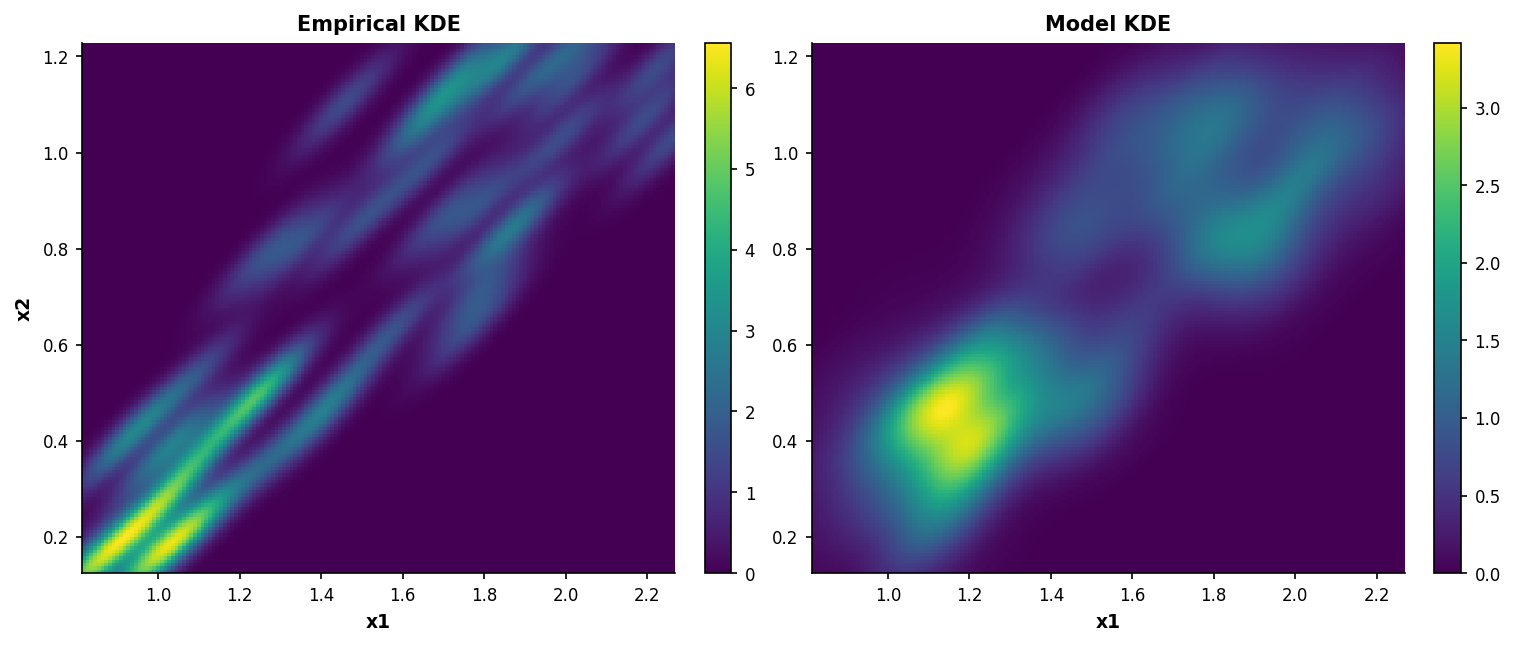

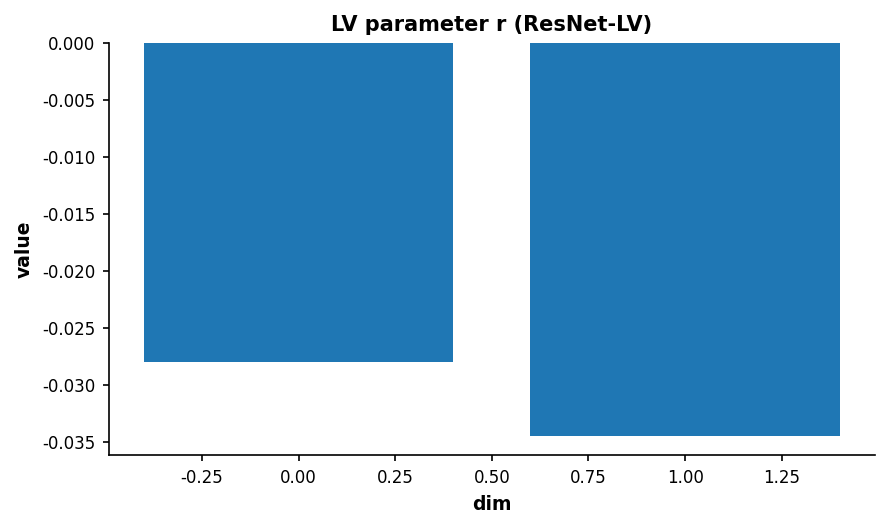

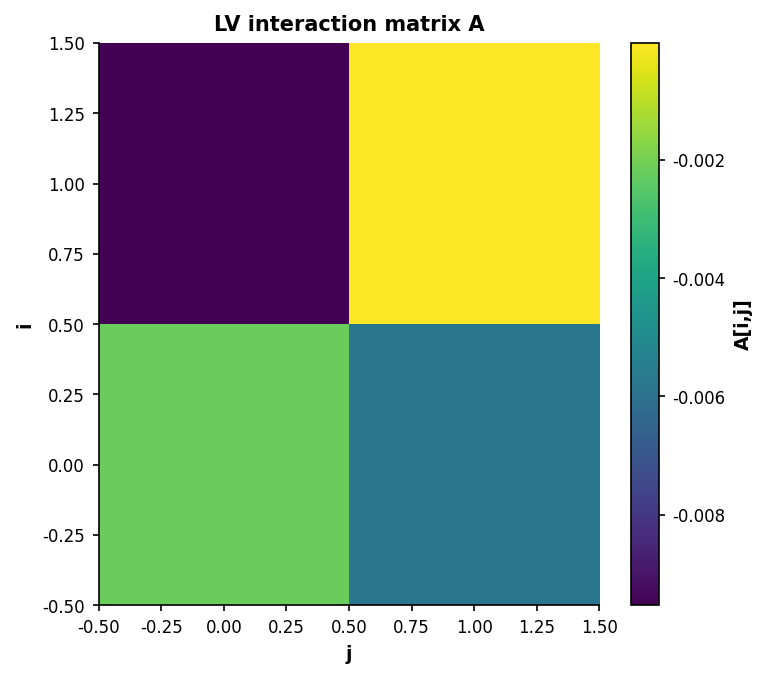


✅ Done drawing all figures & diagnostics (no files saved).


In [11]:
# ========================== Cell: PLOTS & Diagnostics  ==========================
import os, gc, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import tensorflow as tf
import keras
import keras.backend as K

tf.keras.backend.set_floatx('float64')
NUMBER_TYPE = tf.float64
np.set_printoptions(suppress=True, precision=6)

# ---------- 依赖检查（确保你训练脚本里定义过这些） ----------
need_names = [
    "Numerics", "ModelBuilder", "define_sde_with_lv", "SDEApproximationNetwork",
    "SDEIdentification", "aggregate_z_segment", "build_multi_h_pairs_on_block",
    "simulate_path_block", "generate_sde_time_series"
]
for n in need_names:
    assert n in globals(), f"❌ 缺少依赖：{n}。请先运行训练脚本里定义这些类/函数的 cell。"

# ---------- 小工具 ----------
def acf_1d(x, nlags=40):
    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()
    denom = np.dot(x, x) + 1e-18
    ac = [1.0]
    for k in range(1, nlags+1):
        ac.append(float(np.dot(x[:-k], x[k:]) / denom))
    return np.array(ac)

def rmse(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    return float(np.sqrt(np.mean((a - b)**2)))

def r2(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    ss_res = np.sum((a - b)**2)
    ss_tot = np.sum((b - b.mean())**2) + 1e-18
    return float(1.0 - ss_res / ss_tot)

# ---------- KDE 工具（1D + 2D，高斯核） ----------
def _kde_pdf_1d(x, grid=None, bw="scott"):
    x = np.asarray(x).ravel()
    if np.std(x) < 1e-12:
        mu = float(np.mean(x))
        sd = 1e-6
        if grid is None:
            grid = np.linspace(mu-5*sd, mu+5*sd, 400)
        pdf = (1/np.sqrt(2*np.pi*sd*sd)) * np.exp(-0.5*((grid-mu)/sd)**2)
        pdf /= (np.trapz(pdf, grid) + 1e-18)
        return grid, pdf
    kde = gaussian_kde(x, bw_method=bw)
    if grid is None:
        gmin, gmax = np.percentile(x, [0.5, 99.5])
        grid = np.linspace(gmin, gmax, 400)
    pdf = kde(grid)
    pdf /= (np.trapz(pdf, grid) + 1e-18)
    return grid, pdf

def _kde_pdf_2d(xy, grids=160, bw="scott"):
    xy = np.asarray(xy, dtype=np.float64)
    if np.std(xy[:,0]) < 1e-12 or np.std(xy[:,1]) < 1e-12:
        xy = xy + np.random.normal(0.0, 1e-6, size=xy.shape)
    kde = gaussian_kde(xy.T, bw_method=bw)
    x_min, x_max = np.percentile(xy[:,0], [0.5, 99.5])
    y_min, y_max = np.percentile(xy[:,1], [0.5, 99.5])
    xs = np.linspace(x_min, x_max, grids)
    ys = np.linspace(y_min, y_max, grids)
    Xg, Yg = np.meshgrid(xs, ys, indexing="xy")
    pts = np.vstack([Xg.ravel(), Yg.ravel()])
    Z = kde(pts).reshape(grids, grids)
    Z /= (np.trapz(np.trapz(Z, xs, axis=1), ys, axis=0) + 1e-18)
    return xs, ys, Z

def kde_plots_show(model, X_blk, Z_blk, T_blk, names,
                   mu_x=None, sd_x=None, mu_z=None, sd_z=None,
                   cond_mode="mean", n_sims=400, bw="scott",
                   diff_type="diagonal"):
    """
    Test 段 gap=1 的条件分布 KDE 对比；条件输入采用 C=[Z_agg, ΔZ]。
    """
    avail = len(X_blk) - 1
    if avail <= 0:
        print("⚠️ 块长度太短，无法做 KDE。")
        return

    idx = np.arange(avail)
    h  = (T_blk[idx + 1] - T_blk[idx]).reshape(-1,1)
    xn = X_blk[idx]
    xp = X_blk[idx + 1]

    # gap=1: C=[Z_agg, ΔZ]，ΔZ=0（但维度一致）
    C_rows = []
    for t in idx:
        z_agg = aggregate_z_segment(Z_blk, t, 1, cond_mode)
        dz    = Z_blk[t] - Z_blk[t]
        C_rows.append(np.concatenate([z_agg, dz], axis=0))
    z = np.vstack(C_rows).astype(np.float64)

    xn_s = (xn - mu_x) / sd_x if mu_x is not None else xn
    xp_s = (xp - mu_x) / sd_x if mu_x is not None else xp
    z_s  = (z  - mu_z) / sd_z if mu_z is not None else z

    S = int(n_sims)
    xn_rep = np.repeat(xn_s, S, axis=0)
    z_rep  = np.repeat(z_s,  S, axis=0)
    h_rep  = np.repeat(h,    S, axis=0)

    # 全部转 tensor，避免 numpy/tensor 混用
    xn_tf = tf.convert_to_tensor(xn_rep, dtype=NUMBER_TYPE)
    z_tf  = tf.convert_to_tensor(z_rep,  dtype=NUMBER_TYPE)
    h_tf  = tf.convert_to_tensor(h_rep,  dtype=NUMBER_TYPE)

    # model.call_xn 支持 (x, param)
    mu_hat, sig_hat = model.call_xn(xn_tf, z_tf)
    approx = ModelBuilder.define_normal_distribution(xn_tf, h_tf, mu_hat, sig_hat, diff_type)
    x_samp = approx.sample().numpy()

    pred_all = x_samp * sd_x + mu_x if mu_x is not None else x_samp
    true_all = np.repeat(xp, S, axis=0)

    # 1D
    for i, nm in enumerate(names):
        g_true, p_true = _kde_pdf_1d(true_all[:,i], bw=bw)
        g_pred, p_pred = _kde_pdf_1d(pred_all[:,i], grid=g_true, bw=bw)
        plt.figure(figsize=(6.4,4.2))
        plt.plot(g_true, p_true, label="Empirical KDE", lw=2.0)
        plt.plot(g_pred, p_pred, label="Model KDE", lw=2.0)
        plt.title(f"KDE (gap=1, test) — {nm}")
        plt.xlabel(nm); plt.ylabel("density"); plt.legend()
        plt.tight_layout(); plt.show()

    # 2D（只画前两维）
    if len(names) >= 2:
        xs, ys, Zt = _kde_pdf_2d(true_all[:, :2], grids=160, bw=bw)
        _,  _, Zp  = _kde_pdf_2d(pred_all[:, :2], grids=160, bw=bw)
        fig, ax = plt.subplots(1,2,figsize=(10,4.2), constrained_layout=True)
        im0 = ax[0].imshow(Zt.T, origin="lower",
                           extent=[xs.min(), xs.max(), ys.min(), ys.max()], aspect="auto")
        ax[0].set_title("Empirical KDE"); fig.colorbar(im0, ax=ax[0])
        im1 = ax[1].imshow(Zp.T, origin="lower",
                           extent=[xs.min(), xs.max(), ys.min(), ys.max()], aspect="auto")
        ax[1].set_title("Model KDE");    fig.colorbar(im1, ax=ax[1])
        for a in ax: a.set_xlabel(names[0])
        ax[0].set_ylabel(names[1])
        plt.show()

# ---------- ensemble rollout（加裁剪防爆炸） ----------
def simulate_path_block_ensemble(model, X_blk, Z_blk, T_blk,
                                 gap=1, cond_mode='mean',
                                 mu_x=None, sd_x=None, mu_z=None, sd_z=None,
                                 diff_type="diagonal", n_ens=30,
                                 quantiles=(0.025,0.5,0.975),
                                 clip_std=5.0):
    """
    从块第一个点出发，ensemble 滚动：
    - 条件输入 C = [Z_agg, ΔZ]
    - 在标准化空间做 clip 防爆炸
    返回：Qlo/Qmd/Qhi shape=(K, d), t_axis shape=(K,)
    """
    X0 = X_blk[0].copy()
    X0s = ((X0[None,:]-mu_x)/sd_x)[0] if (mu_x is not None) else X0.copy()

    Nblk = len(T_blk)
    steps = (Nblk - 1)//gap
    n_ens = int(n_ens)

    ens = np.tile(X0s[None,:], (n_ens, 1)).astype(np.float64)
    traj = [ens.copy()]
    t_axis = [T_blk[0]]

    for j in range(steps):
        t = j*gap
        if t + gap >= Nblk: break
        dt = float(T_blk[t+gap] - T_blk[t])

        z_agg = aggregate_z_segment(Z_blk, t, gap, cond_mode)
        dz    = Z_blk[t+gap] - Z_blk[t]
        zseg  = np.concatenate([z_agg, dz]).reshape(1,-1).astype(np.float64)
        zseg_s = (zseg - mu_z) / sd_z if (mu_z is not None) else zseg
        zseg_rep = np.repeat(zseg_s, n_ens, axis=0)

        x_n_np = traj[-1].astype(np.float64)

        x_n = tf.convert_to_tensor(x_n_np, dtype=NUMBER_TYPE)
        z_r = tf.convert_to_tensor(zseg_rep, dtype=NUMBER_TYPE)
        h_r = tf.convert_to_tensor(np.ones((n_ens,1), dtype=np.float64)*dt, dtype=NUMBER_TYPE)

        mu_hat, sig_hat = model.call_xn(x_n, z_r)
        approx = ModelBuilder.define_normal_distribution(x_n, h_r, mu_hat, sig_hat, diff_type)
        x_np1 = approx.sample().numpy()

        x_np1 = np.clip(x_np1, -clip_std, clip_std)
        traj.append(x_np1)
        t_axis.append(T_blk[t+gap])

    traj_arr = np.stack(traj, axis=1)  # (S, steps+1, d)
    if mu_x is not None:
        traj_arr = traj_arr * sd_x + mu_x

    traj_no0 = traj_arr[:,1:,:]  # (S, K, d)
    qs = {q: np.quantile(traj_no0, q, axis=0) for q in quantiles}
    return qs[0.025], qs[0.5], qs[0.975], np.array(t_axis[1:], dtype=np.float64)

# ---------- 置信区间覆盖率 & 带宽 ----------
def compute_pi_coverage(Qlo, Qhi, t_axis, X, T, idx_tr, idx_va, idx_te, names):
    T = np.asarray(T)
    idx_tr = np.asarray(idx_tr)
    idx_va = np.asarray(idx_va)
    idx_te = np.asarray(idx_te)

    idx_map = []
    for tt in t_axis:
        idx_exact = np.where(np.isclose(T, tt, rtol=1e-10, atol=1e-10))[0]
        if len(idx_exact) > 0:
            idx_map.append(idx_exact[0])
        else:
            idx_map.append(int(np.argmin(np.abs(T - tt))))
    idx_map = np.array(idx_map, dtype=int)

    seg_tr = np.isin(idx_map, idx_tr)
    seg_va = np.isin(idx_map, idx_va)
    seg_te = np.isin(idx_map, idx_te)

    metrics = {"overall": {}, "train": {}, "val": {}, "test": {}}

    for j, nm in enumerate(names):
        lo = Qlo[:, j]
        hi = Qhi[:, j]
        x  = X[idx_map, j]
        inside = (x >= lo) & (x <= hi)
        width  = hi - lo

        def _cov_w(mask):
            if mask is None:
                m = np.ones_like(inside, dtype=bool)
            else:
                m = mask
            if not np.any(m):
                return np.nan, np.nan
            cov = float(inside[m].mean())
            w   = float(width[m].mean())
            return cov, w

        metrics["overall"][nm] = _cov_w(None)
        metrics["train"][nm]   = _cov_w(seg_tr)
        metrics["val"][nm]     = _cov_w(seg_va)
        metrics["test"][nm]    = _cov_w(seg_te)

    return metrics

# ---------- 主入口：只画图（不训练） ----------
def plots_only_show(cfg, n_ens=30):
    plt.close('all')
    tf.keras.backend.clear_session()
    gc.collect()

    np.random.seed(cfg["seed"])
    tf.random.set_seed(cfg["seed"])
    Numerics.set_std_floor(cfg.get("std_min_value", 1e-13))

    # ===== 1) 读数据 =====
    if cfg["use_synthetic"] or (not os.path.exists(cfg["data_xlsx"])):
        df = generate_sde_time_series(
            total_steps=cfg["synthetic_total_steps"],
            step_size=cfg["synthetic_dt"],
            mutation_step=cfg["synthetic_mutation_step"],
            out_path=cfg["synthetic_out_path"],
            seed=cfg["seed"]
        )
    else:
        df = pd.read_excel(cfg["data_xlsx"])

    step_col = cfg["step_col"]
    if step_col in df.columns:
        df = df.sort_values(step_col).reset_index(drop=True)
    else:
        df[step_col] = np.arange(len(df))

    if "Z2" in df.columns and ("Z2_log" in cfg["param_cols"]):
        df["Z2_log"] = np.log1p(df["Z2"])

    X = df[cfg["state_cols"]].to_numpy(np.float64)
    Z = df[cfg["param_cols"]].to_numpy(np.float64)
    T = df[step_col].to_numpy(np.float64) if step_col in df.columns else np.arange(len(df), dtype=np.float64)

    N = len(T); n_x = X.shape[1]; n_z = Z.shape[1]

    # ===== 2) 时间切分：严格按训练脚本逻辑（关键修复） =====
    R_TR, R_VA, R_TE = cfg["split_ratios"]
    MAXG = max(cfg["gaps"])

    split_tr = int(N * R_TR)
    split_va = int(N * (R_TR + R_VA))

    # train 段内训练一定要 > MAXG
    if split_tr <= MAXG:
        split_tr = MAXG + 1

    # val：只有在 val 段内配对时才需要 > MAXG
    if (not cfg.get("val_cross_pairs", True)) and (split_va - split_tr <= MAXG):
        split_va = split_tr + (MAXG + 1)

    # ✅ test 不做 pairs 时，不用 MAXG 约束 test_len
    if cfg.get("use_test_pairs", True):
        if (not cfg.get("test_cross_pairs", True)) and (N - split_va <= MAXG):
            split_va = N - (MAXG + 1)

    # 兜底
    split_tr = int(np.clip(split_tr, 1, N - 1))
    split_va = int(np.clip(split_va, split_tr + 1, N))

    idx_tr = np.arange(0, split_tr)
    idx_va = np.arange(split_tr, split_va)
    idx_te = np.arange(split_va, N)

    print(f"[Time split] train_len={len(idx_tr)}, val_len={len(idx_va)}, test_len={len(idx_te)}")
    print(f"[flags] val_cross_pairs={cfg.get('val_cross_pairs', True)} | "
          f"use_test_pairs={cfg.get('use_test_pairs', True)} | test_cross_pairs={cfg.get('test_cross_pairs', True)}")
    print(f"[MAXG] max_gap={MAXG}")

    rng = np.random.default_rng(cfg["seed"])

    # ===== 3) 标准化统计量：只用 Train pairs（避免 val/test block 太短报错） =====
    gaps_train = [g for g in cfg["gaps"] if g < len(idx_tr)]
    if len(gaps_train) == 0:
        raise RuntimeError(
            f"train_len={len(idx_tr)} 太短，cfg['gaps']={min(cfg['gaps'])}..{max(cfg['gaps'])} 全不可用。"
            f"请减小 gaps 或增加训练段长度。"
        )

    Xn_tr, Xnp1_tr, C_tr, H_tr = build_multi_h_pairs_on_block(
        X[idx_tr], Z[idx_tr], T[idx_tr],
        gaps_train, cfg["max_per_gap"], cfg["cond_mode"], rng=rng
    )
    print(f"[Pairs for stats] train_pairs={len(Xn_tr)} (gaps_used={min(gaps_train)}..{max(gaps_train)})")

    # 统计量
    def fit_stats_local(arr):
        mu = arr.mean(axis=0, keepdims=True)
        sd = arr.std(axis=0, keepdims=True) + 1e-12
        return mu, sd

    if cfg["standardize_x"]:
        mu_x, sd_x = fit_stats_local(np.vstack([Xn_tr, Xnp1_tr]))
    else:
        mu_x = sd_x = None

    if cfg["standardize_z"]:
        mu_z, sd_z = fit_stats_local(C_tr)
    else:
        mu_z = sd_z = None

    # ===== 4) 重建模型 & 加载权重 =====
    sde_core = define_sde_with_lv(
        n_input_dimensions=n_x,
        n_output_dimensions=n_x,
        n_layers=cfg["mean_num_layers"],
        n_dim_per_layer=cfg["mean_hidden_dim"],
        name="sde",
        activation=cfg["mean_activation"],
        diffusivity_type=cfg["diff_type"],
        dtype=NUMBER_TYPE,
        n_parameter_dimensions=C_tr.shape[1],   # 2*n_z
        lv_trainable=cfg["lv_trainable"],
        dropout_rate=cfg.get("dropout_rate", 0.05),
        l2_weight=cfg.get("l2_weight", 1e-4),
        seed=cfg["seed"]
    )

    full_model = SDEApproximationNetwork(
        sde_core,
        step_size=None,
        n_parameters=C_tr.shape[1],
        method="euler",
        diffusivity_type=cfg["diff_type"],
        gate_entropy_lambda=cfg.get("gate_entropy_lambda", 0.0)
    )

    # build
    dummy_cols = 1 + n_x + C_tr.shape[1] + n_x
    _ = full_model(tf.zeros((1, dummy_cols), dtype=NUMBER_TYPE))

    # LV 拆分子模型（可选）
    lv_res_model = None
    try:
        lv_res_model = tf.keras.Model(
            inputs=sde_core.inputs,
            outputs=[
                sde_core.get_layer("sde_lv_prior").output,
                sde_core.get_layer("sde_mean_res_out").output,
            ],
            name="sde_lv_resplit"
        )
    except Exception as e:
        print("⚠️ 无法构造 LV 拆分子模型，跳过 LV 贡献分析：", e)

    # 找权重（best 优先）
    cand_paths = [cfg.get("save_best_weights_path", ""), cfg.get("save_weights_path", "")]
    weight_path = None
    for p in cand_paths:
        if p and os.path.exists(p):
            weight_path = p
            break
    if weight_path is None:
        raise FileNotFoundError(f"❌ 找不到权重文件，候选：{cand_paths}")

    full_model.load_weights(weight_path)
    print(f"✅ Loaded weights from: {weight_path}")

    # 创建 solver（用于 simulate_path_block）
    solver = SDEIdentification(full_model)

    names = cfg["state_cols"]
    orange=(212/255,170/255,100/255); blue=(16/255,94/255,126/255)

    # ===== 5) Test 段单路径 rollout =====
    X_te_blk, Z_te_blk, T_te_blk = X[idx_te], Z[idx_te], T[idx_te]
    pred_single, t_single = simulate_path_block(
        solver, X_te_blk, Z_te_blk, T_te_blk,
        gap=cfg["rollout_gap"], cond_mode=cfg["cond_mode"],
        diffusivity_type=cfg["diff_type"],
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z
    )
    

    # ===== 6) 全时序 ensemble（train+val+test） =====
    Qlo_all, Qmd_all, Qhi_all, t_all = simulate_path_block_ensemble(
        full_model, X, Z, T,
        gap=cfg["rollout_gap"], cond_mode=cfg["cond_mode"],
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z,
        diff_type=cfg["diff_type"], n_ens=n_ens, quantiles=(0.025,0.5,0.975),
        clip_std=5.0
    )

    t_tr_end = T[idx_tr[-1]]
    t_va_end = T[idx_va[-1]]

    for i, name in enumerate(names):
        fig, ax = plt.subplots(figsize=(12,4.8))
        ax.plot(T, X[:,i], color=orange, lw=1.8, label=f"True {name} (all)")
        ax.plot(t_all, Qmd_all[:,i], color=blue, lw=1.8, label="Median (ensemble)")
        ax.fill_between(t_all, Qlo_all[:,i], Qhi_all[:,i], alpha=0.22, color=blue, label="95% band")

        ax.axvline(t_tr_end, ls="--", lw=1.0, color="gray", alpha=0.8)
        ax.axvline(t_va_end, ls="--", lw=1.0, color="gray", alpha=0.8)

        ymin, ymax = ax.get_ylim()
        ax.axvspan(T[0],      t_tr_end, facecolor="lightgreen", alpha=0.08)
        ax.axvspan(t_tr_end,  t_va_end, facecolor="gold",       alpha=0.08)
        ax.axvspan(t_va_end,  T[-1],    facecolor="lightblue",  alpha=0.08)

        ax.text((T[0]+t_tr_end)/2, ymax, "Train", va="bottom", ha="center", fontsize=9)
        ax.text((t_tr_end+t_va_end)/2, ymax, "Val", va="bottom", ha="center", fontsize=9)
        ax.text((t_va_end+T[-1])/2, ymax, "Test", va="bottom", ha="center", fontsize=9)

        ax.set_xlabel("Time"); ax.set_ylabel(name)
        ax.set_title(f"{name}: Full timeline (ResNet ensemble, n_ens={n_ens})")
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.legend(fontsize=10)
        plt.tight_layout(); plt.show()

    # 覆盖率
    pi_metrics = compute_pi_coverage(Qlo_all, Qhi_all, t_all, X, T, idx_tr, idx_va, idx_te, names)
    print("\n[95% band coverage] overall (希望接近 0.95)：")
    for nm in names:
        cov, w = pi_metrics["overall"][nm]
        print(f"  {nm}: coverage={cov:.3f}, mean width={w:.4f}")

    print("\n[95% band coverage] by segment:")
    for seg_key, seg_name in [("train","Train"), ("val","Val"), ("test","Test")]:
        print(f"  -- {seg_name} --")
        for nm in names:
            cov, w = pi_metrics[seg_key][nm]
            if np.isnan(cov):
                print(f"    {nm}: no points")
            else:
                print(f"    {nm}: cov={cov:.3f}, width={w:.4f}")

    # ===== 7) Test 段一步均值校准（gap=1） + LV 贡献 =====
    avail = len(X_te_blk) - 1
    if avail > 0:
        idx_step = np.arange(avail)
        h1  = (T_te_blk[idx_step+1] - T_te_blk[idx_step]).reshape(-1,1)
        xn1 = X_te_blk[idx_step]
        xp1 = X_te_blk[idx_step+1]

        # gap=1: C=[Z_agg, ΔZ]，ΔZ=0
        C_rows = []
        for t in idx_step:
            z_agg = aggregate_z_segment(Z_te_blk, t, 1, cfg["cond_mode"])
            dz    = Z_te_blk[t] - Z_te_blk[t]
            C_rows.append(np.concatenate([z_agg, dz], axis=0))
        z1 = np.vstack(C_rows).astype(np.float64)

        xn1_s = (xn1 - mu_x)/sd_x if mu_x is not None else xn1
        xp1_s = (xp1 - mu_x)/sd_x if mu_x is not None else xp1
        z1_s  = (z1  - mu_z)/sd_z if mu_z is not None else z1

        xn_tf = tf.convert_to_tensor(xn1_s, dtype=NUMBER_TYPE)
        z_tf  = tf.convert_to_tensor(z1_s,  dtype=NUMBER_TYPE)

        mu1, sig1 = full_model.call_xn(xn_tf, z_tf)   # drift, diff
        mu1 = mu1.numpy()
        loc = xn1_s + h1 * mu1  # 条件均值（标准化空间）

        # LV vs ResNet 贡献（drift）
        if lv_res_model is not None:
            inp_gap1 = np.concatenate([xn1_s, z1_s], axis=1)
            lv_dr, res_dr = lv_res_model(tf.convert_to_tensor(inp_gap1, dtype=NUMBER_TYPE))
            lv_dr = lv_dr.numpy()
            res_dr = res_dr.numpy()
            tot_dr = lv_dr + res_dr

            num = np.sum(lv_dr**2, axis=1)
            den = np.sum(tot_dr**2, axis=1) + 1e-12
            frac_lv_global = float(np.mean(num / den))
            print(f"\n[LV drift contribution] mean E[||LV||^2 / ||total||^2] on test (gap=1) = {frac_lv_global:.3f}")

            mean_lv_abs  = np.mean(np.abs(lv_dr), axis=0)
            mean_res_abs = np.mean(np.abs(res_dr), axis=0)
            frac_dim = mean_lv_abs / (mean_lv_abs + mean_res_abs + 1e-12)
            for j, nm in enumerate(names):
                print(f"  dim {nm}: mean |LV| / (|LV|+|ResNet|) ≈ {frac_dim[j]:.3f}")

            fig, ax = plt.subplots(figsize=(6.0,3.6))
            ax.bar(np.arange(len(names)), frac_dim)
            ax.set_xticks(np.arange(len(names)))
            ax.set_xticklabels(names)
            ax.set_ylim(0,1.0)
            ax.set_ylabel("mean |LV| / (|LV|+|ResNet|)")
            ax.set_title("LV contribution in drift (test, gap=1)")
            plt.tight_layout(); plt.show()

        # 一步均值校准散点
        for i, name in enumerate(names):
            y_true_std = xp1_s[:, i]
            y_pred_std = loc[:, i]

            if mu_x is not None:
                y_true_raw = xp1[:, i]
                y_pred_raw = y_pred_std * sd_x[0, i] + mu_x[0, i]
            else:
                y_true_raw = xp1[:, i]
                y_pred_raw = y_pred_std

            r2_raw   = r2(y_pred_raw, y_true_raw)
            rmse_raw = rmse(y_pred_raw, y_true_raw)

            fig, ax = plt.subplots(figsize=(5.8,5.4))
            ax.scatter(y_pred_std, y_true_std, s=12, alpha=0.6)
            xy_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
            xy_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
            ax.plot([xy_min, xy_max], [xy_min, xy_max], 'k--', lw=1.1)

            ax.set_title(
                f"{name}: one-step mean calibration (test)\n"
                f"R²={r2_raw:.3f}, RMSE={rmse_raw:.3f} (original scale)"
            )
            ax.set_xlabel("Predicted conditional mean (standardized)")
            ax.set_ylabel("Observed X_{t+h} (standardized)")
            ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
            plt.tight_layout(); plt.show()

    # ===== 8) Test 段 KDE =====
    kde_plots_show(
        full_model, X_te_blk, Z_te_blk, T_te_blk, names,
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z,
        cond_mode=cfg["cond_mode"], n_sims=400,
        bw="scott", diff_type=cfg["diff_type"]
    )

    # ===== 9) LV 参数可视化 =====
    lv_layers = [l for l in sde_core.layers if "lv_prior" in l.name]
    if lv_layers:
        lv = lv_layers[0]
        r_vec, A_mat = lv.get_weights()[0], lv.get_weights()[1]

        fig, ax = plt.subplots(figsize=(6.0,3.6))
        ax.bar(np.arange(len(r_vec)), r_vec)
        ax.set_title("LV parameter r (ResNet-LV)")
        ax.set_xlabel("dim"); ax.set_ylabel("value")
        plt.tight_layout(); plt.show()

        fig, ax = plt.subplots(figsize=(5.2,4.6))
        im = ax.imshow(A_mat, origin="lower", aspect="auto")
        ax.set_title("LV interaction matrix A")
        ax.set_xlabel("j"); ax.set_ylabel("i")
        cb = plt.colorbar(im, ax=ax); cb.set_label("A[i,j]")
        plt.tight_layout(); plt.show()

    print("\n✅ Done drawing all figures & diagnostics (no files saved).")

# === 运行（只画图，不训练） ===
plots_only_show(CONFIG, n_ens=30)


✅ Loaded weights: data/resnetdz1111_best1.h5
✅ Loaded meta   : data/resnetdz1111_best1_meta.npz
[Time split(meta)] train=175, val=25, test=51


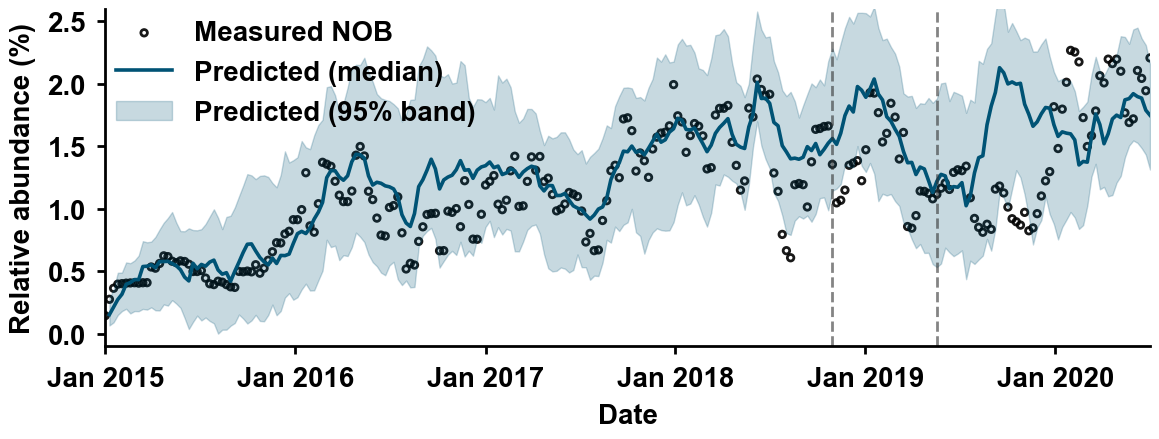

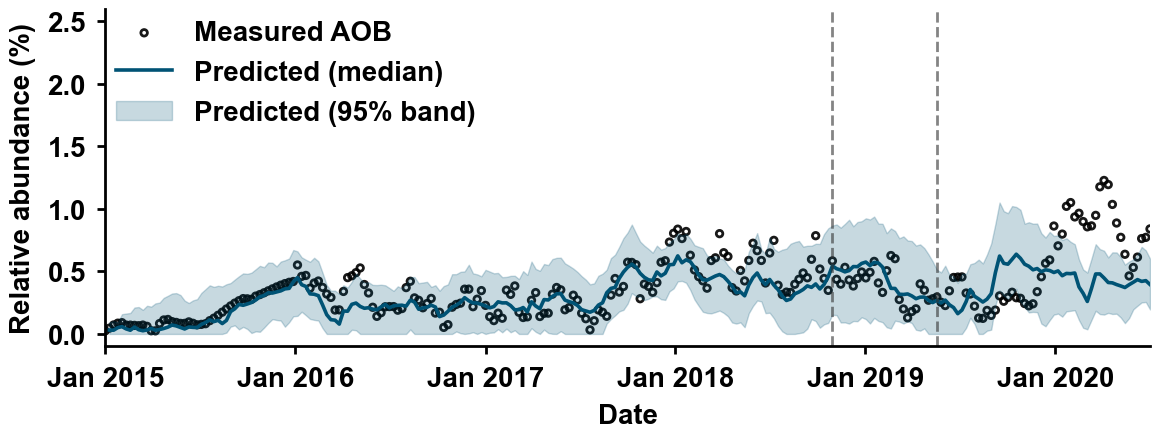

In [7]:
# ==========================
# Full timeline 
# ==========================

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

tf.keras.backend.set_floatx("float64")
NUMBER_TYPE = tf.float64
np.set_printoptions(suppress=True, precision=6)

# ---------- Dependency gates ----------
REQUIRED = [
    "Numerics",
    "aggregate_z_segment",
    "load_trained_model_for_plots",
    "simulate_path_block_ensemble",   # ✅ 必须是你“第一段内核”的那份（全局已定义）
]
missing = [n for n in REQUIRED if n not in globals()]
if missing:
    raise RuntimeError(
        "❌ 缺少必要依赖（请先运行训练/诊断脚本中定义它们的 cell）：\n  - "
        + "\n  - ".join(missing)
    )

# ================== Style (keep yours) ==================
FONT_FAMILY = "Arial"
FONT_SIZE   = 20
FONT_WEIGHT = "bold"

plt.rcParams.update({
    "font.family": FONT_FAMILY,
    "font.size": FONT_SIZE,
    "font.weight": FONT_WEIGHT,
    "font.style": "normal",
    "axes.labelweight": FONT_WEIGHT,
    "axes.titleweight": FONT_WEIGHT,
    "axes.edgecolor": "black",
    "axes.linewidth": 2,
    "xtick.major.width": 2,
    "ytick.major.width": 2,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    "legend.fontsize": FONT_SIZE,
    "legend.frameon": False,
})

ORANGE   = (0/255, 0/255, 0/255)
BLUE     = (0/255, 83/255, 117/255)
REF_LINE = (0.2, 0.2, 0.2)

def _apply_axis_style(ax):
    ax.tick_params(axis="both", which="both",
                   direction="out", length=6, width=2,
                   pad=8, labelsize=FONT_SIZE, colors="black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_position(("outward", 0))
    ax.spines["left"].set_position(("outward", 0))

def _map_times_to_dates(t_vals, T_numeric, dates_T):
    T_numeric = np.asarray(T_numeric, dtype=np.float64)
    t_vals = np.asarray(t_vals, dtype=np.float64).ravel()
    idx_map = np.array([int(np.argmin(np.abs(T_numeric - tt))) for tt in t_vals], dtype=int)
    return dates_T[idx_map]

def plot_full_timeline_ensemble_only_compat(
    cfg,
    n_ens=30,
    clip_std=5.0,
    prefer_best=True,
    clamp_nonneg=True,                # 保留你原来的 clamp 负值到 0
    quantiles=(0.025, 0.5, 0.975),    # 与第一段一致：直接把 quantiles 传下去
):
    plt.close("all")
    tf.keras.backend.clear_session()
    gc.collect()

    np.random.seed(int(cfg["seed"]))
    tf.random.set_seed(int(cfg["seed"]))
    Numerics.set_std_floor(cfg.get("std_min_value", 1e-13))

    # =========================================================
    # 1) ✅ load artifacts (model + meta + data)
    # =========================================================
    out = load_trained_model_for_plots(cfg, prefer_best=prefer_best, build_solver=False)
    if isinstance(out, (tuple, list)) and len(out) == 4:
        full_model, _solver_unused, meta, (df, X, Z, T) = out
    elif isinstance(out, (tuple, list)) and len(out) == 3:
        full_model, meta, (df, X, Z, T) = out
    else:
        raise RuntimeError("load_trained_model_for_plots 返回值不符合预期（需要 3 或 4 个对象）。")

    X = np.asarray(X, dtype=np.float64)
    Z = np.asarray(Z, dtype=np.float64)
    T = np.asarray(T, dtype=np.float64).reshape(-1)
    N = len(T)

    # =========================================================
    # 2) ✅ splits (用于竖线) — 保留你原逻辑
    # =========================================================
    idx_tr = np.asarray(meta.get("idx_tr", np.arange(0, 0)), dtype=np.int64)
    idx_va = np.asarray(meta.get("idx_va", np.arange(0, 0)), dtype=np.int64)

    if len(idx_tr) == 0:
        R_TR, R_VA, _ = cfg["split_ratios"]
        MAXG = max(cfg["gaps"]) if len(cfg.get("gaps", [])) else 1
        split_tr = int(N * R_TR)
        split_va = int(N * (R_TR + R_VA))
        if split_tr <= MAXG:
            split_tr = MAXG + 1
        if split_va <= split_tr:
            split_va = split_tr + 1
        split_tr = int(np.clip(split_tr, 1, N - 1))
        split_va = int(np.clip(split_va, split_tr + 1, N))
        idx_tr = np.arange(0, split_tr)
        idx_va = np.arange(split_tr, split_va)

    # =========================================================
    # 3) ✅ stats (训练空间) — 必须从 meta 来，避免 mismatch
    # =========================================================
    mu_x = meta.get("mu_x", None)
    sd_x = meta.get("sd_x", None)
    mu_z = meta.get("mu_z", None)
    sd_z = meta.get("sd_z", None)

    if cfg.get("standardize_x", False) and (mu_x is None or sd_x is None):
        raise RuntimeError("cfg.standardize_x=True 但 meta 缺少 mu_x/sd_x（请检查训练保存逻辑）。")
    if cfg.get("standardize_z", False) and (mu_z is None or sd_z is None):
        raise RuntimeError("cfg.standardize_z=True 但 meta 缺少 mu_z/sd_z（请检查训练保存逻辑）。")

    # =========================================================
    # 4) 日期轴（保留你原来的“人造日期”方案）
    # =========================================================
    dates_T = pd.date_range("2015-01-01", "2020-07-01", periods=N)
    t_tr_end_date = dates_T[idx_tr[-1]]
    t_va_end_date = dates_T[idx_va[-1]] if len(idx_va) > 0 else dates_T[idx_tr[-1]]

    # =========================================================
    # 5) ✅ ensemble rollout：复用“第一段内核”的 simulate_path_block_ensemble
    #    这一步是“对齐内核”的关键
    # =========================================================
    Qlo_all, Qmd_all, Qhi_all, t_all = simulate_path_block_ensemble(
        full_model, X, Z, T,
        gap=cfg["rollout_gap"],
        cond_mode=cfg["cond_mode"],
        mu_x=mu_x, sd_x=sd_x, mu_z=mu_z, sd_z=sd_z,
        diff_type=cfg["diff_type"],
        n_ens=int(n_ens),
        quantiles=quantiles,
        clip_std=clip_std,
    )
    t_all_dates = _map_times_to_dates(t_all, T, dates_T)

    # =========================================================
    # 6) 绘图（保留你原来的 display 名称与风格）
    # =========================================================
    display_names = []
    for i, raw in enumerate(cfg["state_cols"]):
        if i == 0:
            display_names.append("Measured NOB")
        elif i == 1:
            display_names.append("Measured AOB")
        else:
            display_names.append(f"Measured {raw}")

    TRUE_SCATTER_SIZE = 22
    TRUE_SCATTER_LW   = 2.0
    LW_MEDIAN  = 2.6
    LW_VLINE   = 2.0
    BAND_ALPHA = 0.22

    if clamp_nonneg:
        X_plot   = np.maximum(X, 0.0)
        Qlo_plot = np.maximum(Qlo_all, 0.0)
        Qmd_plot = np.maximum(Qmd_all, 0.0)
        Qhi_plot = np.maximum(Qhi_all, 0.0)
    else:
        X_plot, Qlo_plot, Qmd_plot, Qhi_plot = X, Qlo_all, Qmd_all, Qhi_all

    for i, nm in enumerate(display_names):
        fig, ax = plt.subplots(figsize=(12, 4.8))

        ax.scatter(
            dates_T, X_plot[:, i],
            s=TRUE_SCATTER_SIZE,
            facecolors="none",
            edgecolors=ORANGE,
            linewidths=TRUE_SCATTER_LW,
            alpha=0.9,
            label=f"{nm}",
        )

        ax.plot(
            t_all_dates, Qmd_plot[:, i],
            color=BLUE,
            lw=LW_MEDIAN,
            label="Predicted (median)",
        )

        ax.fill_between(
            t_all_dates, Qlo_plot[:, i], Qhi_plot[:, i],
            alpha=BAND_ALPHA,
            color=BLUE,
            label="Predicted (95% band)",
        )

        ax.axvline(t_tr_end_date, ls="--", lw=LW_VLINE, color=REF_LINE, alpha=0.6)
        ax.axvline(t_va_end_date, ls="--", lw=LW_VLINE, color=REF_LINE, alpha=0.6)

        # ✅ per-axis ylim（保留你原来的 0.5%~99.5%）
        y_series = np.concatenate([X_plot[:, i], Qhi_plot[:, i]])
        lo, hi = np.percentile(y_series, [0.5, 99.5])
        if clamp_nonneg:
            lo = min(lo, 0.0)
        pad = 0.06 * (hi - lo + 1e-12)
        ax.set_ylim(-0.1, 2.6)

        ax.set_xlabel("Date", fontfamily=FONT_FAMILY, fontsize=FONT_SIZE,
                      fontweight=FONT_WEIGHT, labelpad=8)
        ax.set_ylabel("Relative abundance (%)", fontfamily=FONT_FAMILY, fontsize=FONT_SIZE,
                      fontweight=FONT_WEIGHT, labelpad=8)

        ax.legend(
            loc="upper left",
            bbox_to_anchor=(0.0, 1),
            borderaxespad=0.0,
            frameon=False,
        )

        ax.set_xlim(pd.Timestamp("2015-01-01"), pd.Timestamp("2020-07-01"))
        ax.xaxis.set_major_locator(mdates.YearLocator(1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
        ax.tick_params(axis="x", rotation=0)

        _apply_axis_style(ax)
        plt.tight_layout()
        plt.show()

# ===================== run =====================
plot_full_timeline_ensemble_only_compat(CONFIG, n_ens=30, clip_std=5.0, prefer_best=True)


✅ Loaded weights: data/resnetdz1111_best1.h5
✅ Loaded meta   : data/resnetdz1111_best1_meta.npz
[Time split(meta)] train=175, val=25, test=51


d:\jsjs\活性污泥SDE - 副本\sde-identification-master\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 165 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KernelSHAP: GAP=10 | N_BG=165 N_EXPLAIN=165 NSAMPLES=250


100%|██████████| 165/165 [01:16<00:00,  2.15it/s]
Using 165 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 165/165 [01:15<00:00,  2.20it/s]


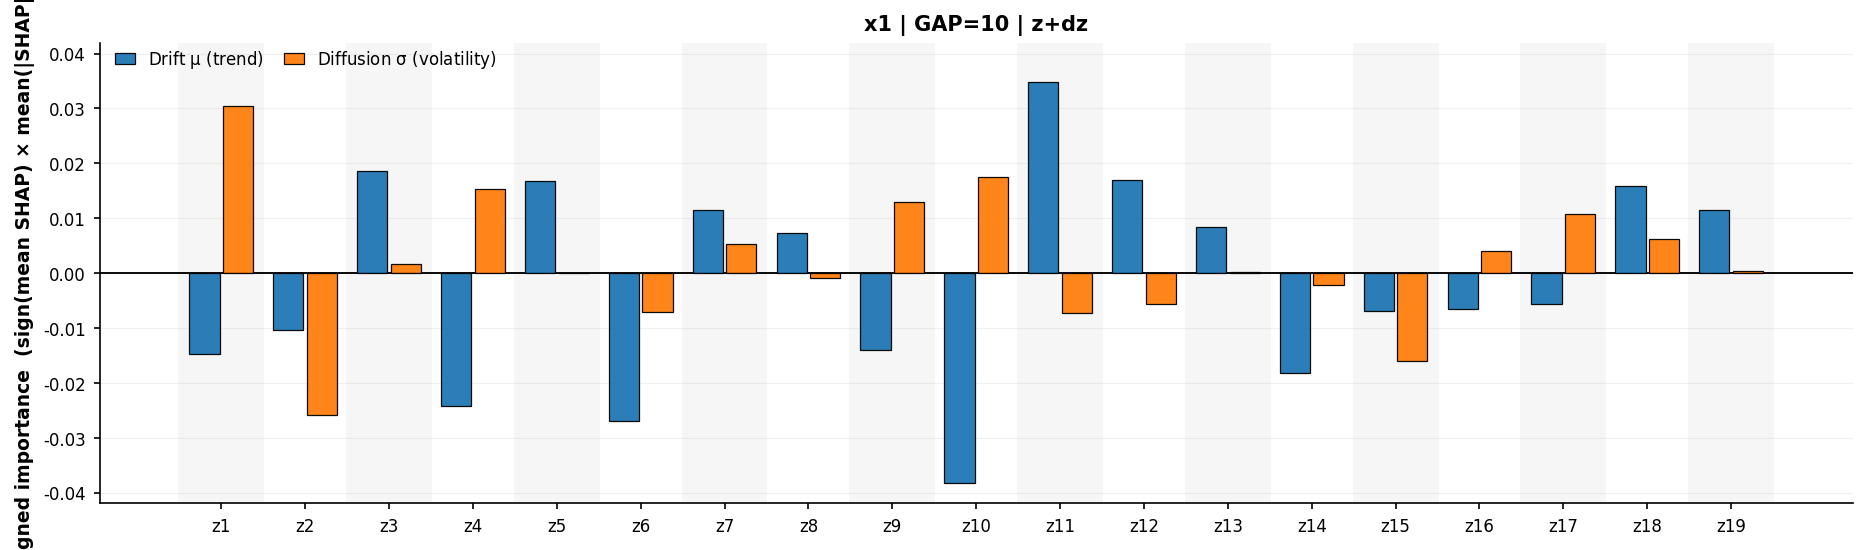

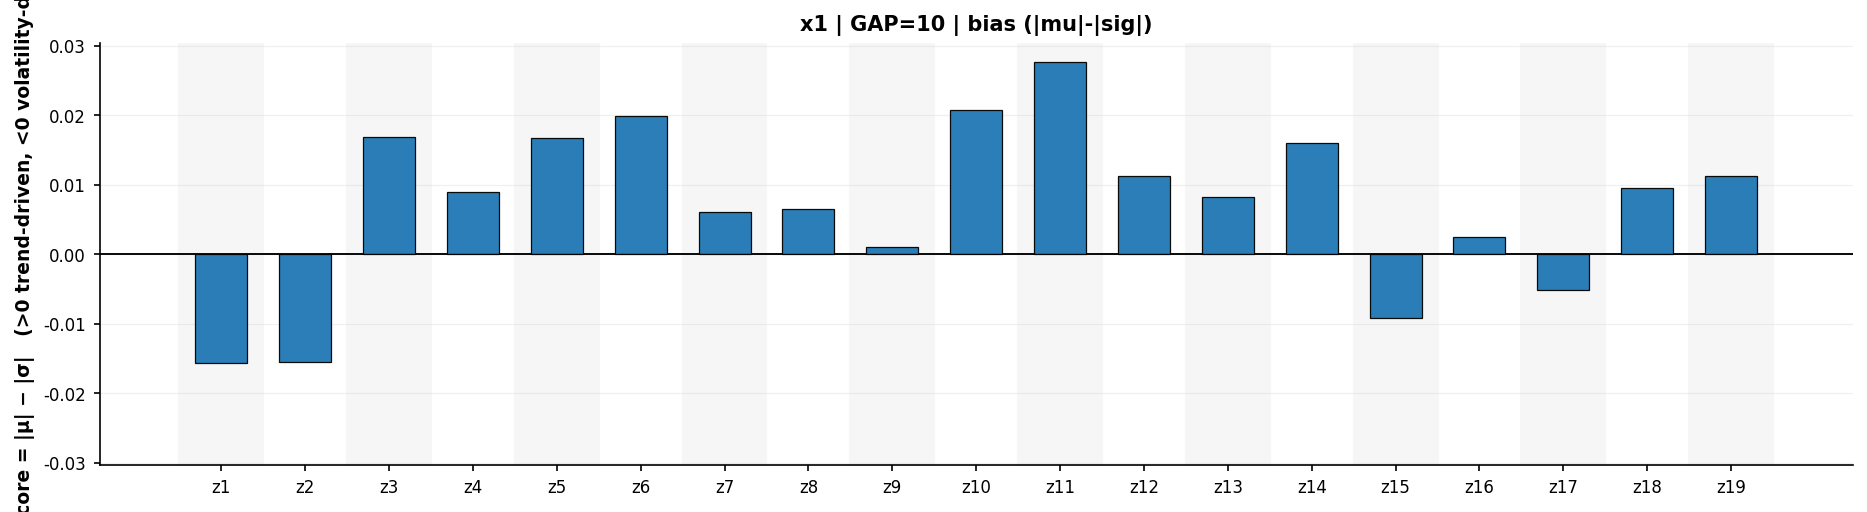

   feature  signed_mu  signed_sig    abs_mu   abs_sig  bias(|mu|-|sig|)  \
0       z1  -0.014716    0.030404  0.014716  0.030404         -0.015688   
1       z2  -0.010415   -0.025841  0.010415  0.025841         -0.015426   
2       z3   0.018542    0.001657  0.018542  0.001657          0.016885   
3       z4  -0.024153    0.015263  0.024153  0.015263          0.008890   
4       z5   0.016767   -0.000039  0.016767  0.000039          0.016728   
5       z6  -0.026992   -0.007059  0.026992  0.007059          0.019934   
6       z7   0.011462    0.005329  0.011462  0.005329          0.006133   
7       z8   0.007372   -0.000833  0.007372  0.000833          0.006538   
8       z9  -0.013946    0.012916  0.013946  0.012916          0.001029   
9      z10  -0.038175    0.017501  0.038175  0.017501          0.020674   
10     z11   0.034832   -0.007222  0.034832  0.007222          0.027610   
11     z12   0.016895   -0.005633  0.016895  0.005633          0.011261   
12     z13   0.008410    

In [8]:
# SHAP
"""
KernelSHAP for Drift μ vs Diffusion σ
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib as mpl
import matplotlib.pyplot as plt

# =========================
# 你要改的参数（计算部分）
# =========================
ANALYZE_BLOCK = "train"   # "train" / "val" / "test" / "all" / "windows"
SPECIES_IDX   = 0         # 0->x1, 1->x2 ...
N_BG          = 250
N_EXPLAIN     = 250
NSAMPLES      = 250
SEED          = 42

# ✅ 新增：GAP（你要的 gap）
GAP = 10

# ✅ 新增：是否用 z_agg（建议 True：更贴近训练 cond_mode）
USE_Z_AGG = False
COND_MODE = "mean"   # "mean"/"sum"/"last"/"start" 需与你训练一致

# ✅ 新增：dz 定义（与你训练一致：Z[t+gap-1]-Z[t]）
DZ_DEF = "end_minus_start"  # "end_minus_start" 或 "end_minus_prev"（不建议）

# ✅ 新增：z 和 dz 是否分开画（2p 特征）
SHOW_Z_AND_DZ_SEPARATELY = False

# =========================
# ✅ 多个“连续窗口”（可选）
# =========================
WINDOWS_STEP = [
    (1, 170),
]
USE_DATE_WINDOWS = False
TIME_COL = "date"
START_DATE = "2015-01-01"
STEP_DELTA = "D"
WINDOWS_DATE = [
    ("2015-01-01", "2016-03-01"),
]

# =========================
# 展示/排版/字体（你原来的保留）
# =========================
FONT_FALLBACKS   = ["DejaVu Sans", "Arial", "Liberation Sans"]
BASE_FONTSIZE    = 9
TITLE_FONTSIZE   = 10
AXISLABEL_FONTSIZE = 9
TICK_FONTSIZE    = 8
LEGEND_FONTSIZE  = 8

Y_SHORT_MODE   = "shortname"   # "zcode" or "shortname"
SAVE_FMT = "pdf"
OUT_DIR  = "out_pdf_like/shap_mu_vs_sigma_gap_general"

XTICK_ROT = 0
ZEBRA_ON = True
ZEBRA_COLOR = "0.965"
BAR_EDGE_LW = 0.6
ZERO_LINE_LW = 0.9
GRID_ALPHA = 0.18
GRID_LW = 0.6

# =========================
# 从 CONFIG 取配置
# =========================
cfg = CONFIG
DATA_XLSX   = cfg["data_xlsx"]
STATE_COLS  = cfg["state_cols"]
PARAM_COLS  = cfg["param_cols"]
STEP_COL    = cfg["step_col"]
DIFF_TYPE = cfg["diff_type"]

WEIGHTS_H5 = cfg.get("save_best_weights_path", None)
if (not WEIGHTS_H5) or (not os.path.exists(WEIGHTS_H5)):
    WEIGHTS_H5 = cfg.get("save_weights_path", None)

rng = np.random.default_rng(SEED)
tfd = tfp.distributions
NUMBER_TYPE = tf.float64

# ============================================================
# 命名映射（你原来的保留：这里略写，你可继续用你那份完整映射）
# ============================================================
def _is_zcode(s: str) -> bool:
    s = str(s)
    return s.startswith("z") and s[1:].isdigit()

Z_SHORT = {f"z{i}": f"z{i}" for i in range(1, 60)}
# 你原来的 Z_SHORT / PARAM_SHORT / full_name / short_name 可直接粘回这里
def to_zcode(var: str) -> str:
    return str(var)

def short_name(var: str) -> str:
    var = str(var)
    if _is_zcode(var):
        return Z_SHORT.get(var, var)
    return var

# =========================
# 风格
# =========================
def set_style():
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 600,
        "font.family": "sans-serif",
        "font.sans-serif": FONT_FALLBACKS,
        "font.size": BASE_FONTSIZE,
        "axes.titlesize": TITLE_FONTSIZE,
        "axes.labelsize": AXISLABEL_FONTSIZE,
        "xtick.labelsize": TICK_FONTSIZE,
        "ytick.labelsize": TICK_FONTSIZE,
        "legend.fontsize": LEGEND_FONTSIZE,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.unicode_minus": False,
        "mathtext.fontset": "dejavusans",
        "mathtext.default": "regular",
    })
    mpl.rcParams["font.weight"] = "normal"

set_style()

# ============================================================
# 0) 优先复用训练 loader（强烈建议）
# ============================================================
meta = None
model_use = None

if "load_trained_model_for_plots" in globals():
    model_use, _solver_unused, meta, (df, X_all, Z_all, T_all) = load_trained_model_for_plots(cfg, build_solver=False)
    idx_tr = np.asarray(meta["idx_tr"], dtype=int)
    idx_va = np.asarray(meta["idx_va"], dtype=int)
    idx_te = np.asarray(meta["idx_te"], dtype=int)
else:
    df = pd.read_excel(DATA_XLSX).sort_values(STEP_COL).reset_index(drop=True)
    X_all = df[STATE_COLS].to_numpy(np.float64)
    Z_all = df[PARAM_COLS].to_numpy(np.float64)
    T_all = df[STEP_COL].to_numpy(np.float64)

    # fallback split（不建议；最好用 meta）
    N_total = len(T_all)
    R_TR, R_VA, R_TE = cfg["split_ratios"]
    split_tr = int(N_total * R_TR)
    split_va = int(N_total * (R_TR + R_VA))
    idx_tr = np.arange(0, split_tr)
    idx_va = np.arange(split_tr, split_va)
    idx_te = np.arange(split_va, N_total)

# ============================================================
# 1) 构造 “t -> t+GAP” 的样本对
#    并构造 z_agg 与 dz（与训练一致）
# ============================================================
def aggregate_z_segment(Z, t, gap, mode='mean'):
    seg = Z[t:t + gap]
    if mode == 'mean':
        return seg.mean(axis=0)
    if mode == 'sum':
        return seg.sum(axis=0)
    if mode == 'last':
        return seg[-1]
    if mode == 'start':
        return seg[0]
    return seg.mean(axis=0)

def make_time_series_for_windows(df_: pd.DataFrame):
    if USE_DATE_WINDOWS:
        if TIME_COL in df_.columns:
            return pd.to_datetime(df_[TIME_COL])
        steps = df_[STEP_COL].to_numpy(np.int64)
        t0 = pd.to_datetime(START_DATE)
        return t0 + pd.to_timedelta(steps, unit=STEP_DELTA)
    return df_[STEP_COL].to_numpy(np.float64)

def build_keep_pairs_windows_lag(time_series, windows, gap):
    """
    keep_pairs[t] 表示 (t, t+gap) 是否同时在窗口内
    返回长度 N-gap 的 bool
    """
    N_ = len(time_series)
    keep = np.zeros(N_ - gap, dtype=bool)

    if isinstance(time_series, (pd.Series, pd.DatetimeIndex)) or np.issubdtype(np.array(time_series).dtype, np.datetime64):
        ts = pd.to_datetime(time_series)
        for a, b in windows:
            t0, t1 = pd.to_datetime(a), pd.to_datetime(b)
            in_win = (ts >= t0) & (ts <= t1)
            keep |= (np.asarray(in_win[:-gap]) & np.asarray(in_win[gap:]))
    else:
        ts = np.asarray(time_series, dtype=np.float64)
        for a, b in windows:
            t0, t1 = float(a), float(b)
            in_win = (ts >= t0) & (ts <= t1)
            keep |= (in_win[:-gap] & in_win[gap:])
    return keep

def select_block_arrays(block):
    if block == "train":
        return X_all[idx_tr], Z_all[idx_tr]
    if block == "val":
        return X_all[idx_va], Z_all[idx_va]
    if block == "test":
        return X_all[idx_te], Z_all[idx_te]
    if block == "all":
        return X_all, Z_all
    return None, None

if ANALYZE_BLOCK == "windows":
    time_series = make_time_series_for_windows(df)
    windows = WINDOWS_DATE if USE_DATE_WINDOWS else WINDOWS_STEP
    keep_pairs = build_keep_pairs_windows_lag(time_series, windows, GAP)

    x_t_raw   = X_all[:-GAP][keep_pairs]
    x_tp_raw  = X_all[GAP:][keep_pairs]
    Z_base    = Z_all[:-GAP][keep_pairs]   # 只是占位，真正用 z_agg / dz 下面算
    t_index   = np.where(keep_pairs)[0]    # 原始 t 索引（在全序列上的 t）
else:
    X_blk, Z_blk = select_block_arrays(ANALYZE_BLOCK)
    if X_blk is None:
        raise ValueError("ANALYZE_BLOCK must be train/val/test/all/windows")

    if len(X_blk) <= GAP:
        raise ValueError(f"Block too short: len={len(X_blk)} <= GAP={GAP}")

    x_t_raw  = X_blk[:-GAP]
    x_tp_raw = X_blk[GAP:]
    # block 内 t 的索引（相对 block）
    t_index = np.arange(0, len(X_blk) - GAP)

p = Z_all.shape[1]
d = X_all.shape[1]

# --- 构造 z_agg 与 dz ---
z_agg_list = []
dz_list = []
if ANALYZE_BLOCK == "windows":
    # t_index 是全局索引
    for t in t_index:
        z_agg = aggregate_z_segment(Z_all, int(t), GAP, COND_MODE) if USE_Z_AGG else Z_all[int(t)]
        if DZ_DEF == "end_minus_start":
            dz = Z_all[int(t + GAP - 1)] - Z_all[int(t)]
        else:
            dz = Z_all[int(t + GAP)] - Z_all[int(t + GAP - 1)]
        z_agg_list.append(z_agg)
        dz_list.append(dz)
else:
    # t_index 是 block 相对索引
    for t in t_index:
        z_agg = aggregate_z_segment(Z_blk, int(t), GAP, COND_MODE) if USE_Z_AGG else Z_blk[int(t)]
        if DZ_DEF == "end_minus_start":
            dz = Z_blk[int(t + GAP - 1)] - Z_blk[int(t)]
        else:
            dz = Z_blk[int(t + GAP)] - Z_blk[int(t + GAP - 1)]
        z_agg_list.append(z_agg)
        dz_list.append(dz)

z_agg_raw = np.vstack(z_agg_list).astype(np.float64)   # (N, p)
dz_raw    = np.vstack(dz_list).astype(np.float64)      # (N, p)
C_raw     = np.concatenate([z_agg_raw, dz_raw], axis=1)  # (N, 2p)

N = len(x_t_raw)
assert C_raw.shape[0] == N and x_tp_raw.shape[0] == N

# ============================================================
# 2) 标准化（用 meta 的 mu_x/sd_x/mu_z/sd_z，保证与训练一致）
# ============================================================
def apply_stats(arr, mu, sd):
    return (arr - mu) / sd

mu_x = meta.get("mu_x", None) if meta is not None else None
sd_x = meta.get("sd_x", None) if meta is not None else None
mu_z = meta.get("mu_z", None) if meta is not None else None
sd_z = meta.get("sd_z", None) if meta is not None else None

if cfg.get("standardize_x", True) and (mu_x is not None) and (sd_x is not None):
    x_t_s  = apply_stats(x_t_raw,  mu_x, sd_x)
else:
    x_t_s  = x_t_raw.copy()

if cfg.get("standardize_z", True) and (mu_z is not None) and (sd_z is not None):
    C_s = apply_stats(C_raw, mu_z, sd_z)
else:
    C_s = C_raw.copy()

F = np.concatenate([x_t_s, C_s], axis=1).astype(np.float64)  # (N, d+2p)

# 索引：C 在 F 中的位置
idxC0 = d
idxC1 = d + 2 * p

# ============================================================
# 3) KernelSHAP
# ============================================================
import shap

bg_idx = rng.choice(N, size=min(N_BG, N), replace=False)
ex_idx = rng.choice(N, size=min(N_EXPLAIN, N), replace=False)
F_bg = F[bg_idx]
F_ex = F[ex_idx]

def pred_mu(F_in):
    F_in = np.asarray(F_in, dtype=np.float64)
    x_in = F_in[:, :d]
    c_in = F_in[:, d:d+2*p]
    x_tf = tf.convert_to_tensor(x_in, dtype=NUMBER_TYPE)
    c_tf = tf.convert_to_tensor(c_in, dtype=NUMBER_TYPE)
    drift, diff = model_use.call_xn(x_tf, c_tf)
    return drift[:, SPECIES_IDX].numpy().reshape(-1, 1)

def pred_sigma(F_in):
    F_in = np.asarray(F_in, dtype=np.float64)
    x_in = F_in[:, :d]
    c_in = F_in[:, d:d+2*p]
    x_tf = tf.convert_to_tensor(x_in, dtype=NUMBER_TYPE)
    c_tf = tf.convert_to_tensor(c_in, dtype=NUMBER_TYPE)
    drift, diff = model_use.call_xn(x_tf, c_tf)
    return diff[:, SPECIES_IDX].numpy().reshape(-1, 1)

print(f"KernelSHAP: GAP={GAP} | N_BG={len(F_bg)} N_EXPLAIN={len(F_ex)} NSAMPLES={NSAMPLES}")
expl_mu = shap.KernelExplainer(pred_mu, F_bg)
shap_mu = expl_mu.shap_values(F_ex, nsamples=NSAMPLES)
shap_mu = shap_mu[0] if isinstance(shap_mu, list) else shap_mu
shap_mu = np.asarray(shap_mu, dtype=np.float64)

expl_sig = shap.KernelExplainer(pred_sigma, F_bg)
shap_sig = expl_sig.shap_values(F_ex, nsamples=NSAMPLES)
shap_sig = shap_sig[0] if isinstance(shap_sig, list) else shap_sig
shap_sig = np.asarray(shap_sig, dtype=np.float64)

# 只取 C=[z_agg, dz] 的 SHAP
shap_mu_C  = shap_mu[:,  idxC0:idxC1]   # (N_EXPLAIN, 2p)
shap_sig_C = shap_sig[:, idxC0:idxC1]

def signed_importance_1d(shap_mat):
    """ sign(mean SHAP) * mean(|SHAP|) """
    m_abs = np.mean(np.abs(shap_mat), axis=0)
    m = np.mean(shap_mat, axis=0)
    return (m_abs * np.sign(m)).astype(np.float64).reshape(-1)

s_mu_2p  = signed_importance_1d(shap_mu_C)   # (2p,)
s_sig_2p = signed_importance_1d(shap_sig_C)  # (2p,)

# ============================================================
# 4) 画图顺序：严格按 z1..z19，再接 dz1..dz19（若分开画）
# ============================================================
def _znum(v):
    z = to_zcode(v)
    try:
        return int(str(z)[1:])
    except Exception:
        return 10**9

order_z = np.argsort([_znum(v) for v in PARAM_COLS])  # 对 z1..z19 排序

# label 构造
z_codes_sorted = [to_zcode(PARAM_COLS[i]) for i in order_z]  # z1..z19
z_short_sorted = [short_name(PARAM_COLS[i]) for i in order_z]

if SHOW_Z_AND_DZ_SEPARATELY:
    # 2p：先 z，再 dz（都按同一 z1.. 顺序）
    feat_names = z_short_sorted + [f"Δ{nm}" for nm in z_short_sorted]
    mu_plot = np.concatenate([s_mu_2p[:p][order_z],  s_mu_2p[p:][order_z]])
    sg_plot = np.concatenate([s_sig_2p[:p][order_z], s_sig_2p[p:][order_z]])
else:
    # 合并成 p（与旧版一致：z+dz）
    mu_plot = (s_mu_2p[:p] + s_mu_2p[p:])[order_z]
    sg_plot = (s_sig_2p[:p] + s_sig_2p[p:])[order_z]
    feat_names = z_short_sorted

bias_plot = np.abs(mu_plot) - np.abs(sg_plot)

# =========================
# 绘图函数（沿用你原来的风格）
# =========================
def _add_zebra_vertical(ax, n, color="0.965"):
    for i in range(n):
        if i % 2 == 0:
            ax.axvspan(i - 0.5, i + 0.5, color=color, zorder=0)

def plot_mu_sigma(feat_names, mu, sg, title, outpath=None, xtick_rot=0):
    feat_names = list(feat_names)
    n = len(feat_names)
    x = np.arange(n)

    m = float(np.max(np.abs(np.concatenate([mu, sg])))) + 1e-12
    ylim = 1.10 * m

    fig_w = max(12.5, 0.50 * n + 2.0)
    fig_h = 4.8
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    fig.subplots_adjust(left=0.06, right=0.995, top=0.86, bottom=0.22)

    if ZEBRA_ON:
        _add_zebra_vertical(ax, n, color=ZEBRA_COLOR)

    bar_w = 0.36
    off = 0.20

    ax.bar(x - off, mu, width=bar_w, label=r"Drift $\mu$ (trend)",
           edgecolor="black", linewidth=BAR_EDGE_LW, alpha=0.95, zorder=3)
    ax.bar(x + off, sg, width=bar_w, label=r"Diffusion $\sigma$ (volatility)",
           edgecolor="black", linewidth=BAR_EDGE_LW, alpha=0.95, zorder=3)

    ax.axhline(0, color="black", linewidth=ZERO_LINE_LW, zorder=2)
    ax.set_ylim(-ylim, ylim)

    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, fontsize=TICK_FONTSIZE,
                       rotation=xtick_rot, ha="right" if xtick_rot else "center")
    ax.grid(axis="y", alpha=GRID_ALPHA, linewidth=GRID_LW, zorder=1)
    ax.set_axisbelow(True)
    ax.set_ylabel("Signed importance  (sign(mean SHAP) × mean(|SHAP|))", fontsize=AXISLABEL_FONTSIZE)
    ax.set_title(title, pad=6, fontsize=TITLE_FONTSIZE)

    ax.legend(frameon=False, ncol=2, loc="upper left",
              bbox_to_anchor=(0.0, 1.02), handlelength=1.2, columnspacing=1.2,
              fontsize=LEGEND_FONTSIZE)

    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    plt.show()
    return fig

def plot_bias(feat_names, bias, title, outpath=None, xtick_rot=0):
    feat_names = list(feat_names)
    n = len(feat_names)
    x = np.arange(n)

    m = float(np.max(np.abs(bias))) + 1e-12
    ylim = 1.10 * m

    fig_w = max(12.5, 0.50 * n + 2.0)
    fig_h = 4.4
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    fig.subplots_adjust(left=0.06, right=0.995, top=0.86, bottom=0.22)

    if ZEBRA_ON:
        _add_zebra_vertical(ax, n, color=ZEBRA_COLOR)

    ax.bar(x, bias, width=0.62, edgecolor="black", linewidth=BAR_EDGE_LW, alpha=0.95, zorder=3)
    ax.axhline(0, color="black", linewidth=ZERO_LINE_LW, zorder=2)
    ax.set_ylim(-ylim, ylim)

    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, fontsize=TICK_FONTSIZE,
                       rotation=xtick_rot, ha="right" if xtick_rot else "center")
    ax.grid(axis="y", alpha=GRID_ALPHA, linewidth=GRID_LW, zorder=1)
    ax.set_axisbelow(True)
    ax.set_ylabel(r"Bias score = |μ| − |σ|   (>0 trend-driven, <0 volatility-driven)",
                  fontsize=AXISLABEL_FONTSIZE)
    ax.set_title(title, pad=6, fontsize=TITLE_FONTSIZE)

    if outpath:
        fig.savefig(outpath, bbox_inches="tight")
    plt.show()
    return fig

# ============================================================
# 5) 输出
# ============================================================
gname = STATE_COLS[SPECIES_IDX]
os.makedirs(OUT_DIR, exist_ok=True)

mu_path   = os.path.join(OUT_DIR, f"{gname}_gap{GAP}_mu_vs_sigma.{SAVE_FMT}")
bias_path = os.path.join(OUT_DIR, f"{gname}_gap{GAP}_bias.{SAVE_FMT}")

plot_mu_sigma(feat_names, mu_plot, sg_plot,
              title=f"{gname} | GAP={GAP} | {'z & dz' if SHOW_Z_AND_DZ_SEPARATELY else 'z+dz'}",
              outpath=mu_path, xtick_rot=XTICK_ROT)

plot_bias(feat_names, bias_plot,
          title=f"{gname} | GAP={GAP} | bias (|mu|-|sig|)",
          outpath=bias_path, xtick_rot=XTICK_ROT)

# 导出表
out = pd.DataFrame({
    "feature": feat_names,
    "signed_mu":  mu_plot,
    "signed_sig": sg_plot,
    "abs_mu":     np.abs(mu_plot),
    "abs_sig":    np.abs(sg_plot),
    "bias(|mu|-|sig|)": bias_plot,
    "dominant":   np.where(np.abs(mu_plot) >= np.abs(sg_plot), "mu(trend)", "sigma(vol)")
})

out_xlsx = os.path.join(OUT_DIR, f"{gname}_gap{GAP}_{'z_and_dz' if SHOW_Z_AND_DZ_SEPARATELY else 'z_plus_dz'}.xlsx")
out.to_excel(out_xlsx, index=False)

print(out)
print("✅ Saved:", out_xlsx)
print("✅ Saved:", mu_path)
print("✅ Saved:", bias_path)
